In [1]:
import json
from pathlib import Path
from datetime import timedelta

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
input_data = list(Path("../matched-infoboxes-extracted/").rglob("*.json"))
files = [x for x in input_data if x.is_file()]
len(files) 

52

In [3]:
num_edits = 0
change_tuples = []
for file in tqdm(files[:50]):
    with open(file, 'r', encoding='utf-8') as f:
        for jsonObj in f:
            single_edit = json.loads(jsonObj)
            num_edits += 1
            #entries.append(single_edit)
            key = single_edit['key'] # is needed as there could be multiple infoboxes on the same page which could change at the same time
            title = single_edit['pageTitle']#['key']
            changes = single_edit['changes']
            timestamp = single_edit['validFrom']
            try:
                template = single_edit['template']
            except KeyError:
                template = ''
            for change in changes:
                name = change['property']['name']
                current_value = change['currentValue'] if 'currentValue' in change.keys() else None
                previous_value = change['previousValue'] if 'previousValue' in change.keys() else None
                change_tuples.append((key, title, name, previous_value, current_value, timestamp, template))
print(num_edits) # 1934309 for 50
len(change_tuples) # 9715201 for 50

  0%|          | 0/50 [00:00<?, ?it/s]

1987357


9970155

In [4]:
data = pd.DataFrame(change_tuples, columns=['key', 'title', 'name', 'previous_value', 'current_value', 'timestamp', 'template'])
data['timestamp'] = pd.to_datetime(data['timestamp'])

In [27]:
data.shape[0]

22807979

Number of times the same infobox was changed at the same second

In [6]:
len(data[['key', 'title', 'name', 'timestamp']]) - len(data[['key', 'title', 'name', 'timestamp']].drop_duplicates()) 

1004

--> Can be ignored as it is so low

## Filter out creations and deletions

In [5]:
#Creations
data[data['previous_value'].isna()].shape[0]

2574444

In [5]:
data['creation'] = data['previous_value'].isna()

In [7]:
#Deletions
data[data['current_value'].isna()].shape[0]

1086573

In [6]:
data['deletion'] = data['current_value'].isna()

--> About three quarters of the changes of the subset are creational or deletional changes

In [19]:
data = data.dropna(subset=['previous_value','current_value'])

In [6]:
data.shape[0]

18118106

In [16]:
data.head()

key          title         name  \
29  140030416-0  American Eats     narrated   
30  140030416-0  American Eats        genre   
31  140030416-0  American Eats    show_name   
34  140030416-0  American Eats  first_aired   
35  140030416-0  American Eats   last_aired   

                                     previous_value  \
29                                  Jeremy Schwartz   
30  [[Documentary film|Documentary]], [[Food|Food]]   
31                                    American Eats   
34                            [[June 29]], [[2006]]   
35                        [[November 23]], [[2006]]   

                                 current_value                 timestamp  \
29                Mason Adams, Jeremy Schwartz 2007-08-28 02:47:38+00:00   
30  [[Documentary film|Documentary]], [[Food]] 2007-11-27 04:46:48+00:00   
31                                America Eats 2008-06-15 21:44:48+00:00   
34                               June 29, 2006 2009-12-15 07:19:46+00:00   
35                           November 23, 2006 2009-12-15 07:19:46+00:00   

              template  
29  infobox television  
30  infobox television  
31  infobox television  
34  infobox television  
35  infobox television

## Look at popular properties 

In [55]:
changes_per_property = data['name'].value_counts()

In [56]:
changes_per_property[:30]

image          382563
name           296450
template       228672
caption        197057
genre          184228
birth_date     125568
birth_place    117947
released       105716
website         87570
pcupdate        84870
currentclub     66964
occupation      66706
country         63423
type            62697
starring        58246
producer        57024
death_date      53837
position        53649
label           53644
location        51863
spouse          51633
caps(goals)     48481
nickname        47510
height          45585
reviews         44870
clubnumber      43946
death_place     41107
writer          40054
next album      39673
years           39119
Name: name, dtype: int64

## Analyze number of changes per key

In [37]:
changes_per_key = data['key'].value_counts()

In [17]:
changes_per_key

100170704-0    11821
9022080-0       6087
45647758-0      4494
133467261-0     4493
25597471-0      4208
               ...  
441686297-2        1
468323715-2        1
82060526-2         1
366096823-1        1
79873547-0         1
Name: key, Length: 9570, dtype: int64

In [18]:
frequ_of_changes = changes_per_key.value_counts()

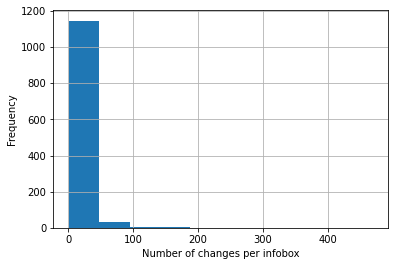

In [19]:
frequ_of_changes.hist(bins=10)
plt.xlabel("Number of changes per infobox")
plt.ylabel("Frequency")
plt.show()

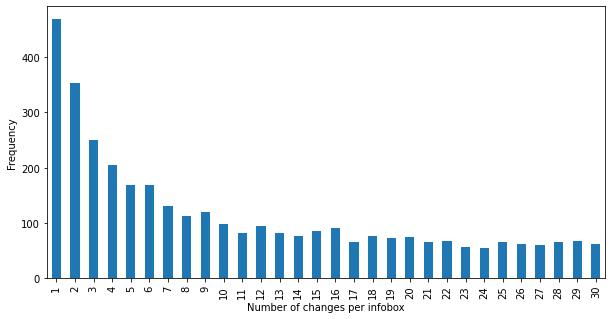

In [20]:
frequ_of_changes.sort_index(ascending=True)[:30].plot.bar(figsize=(10,5))
plt.xlabel("Number of changes per infobox")
plt.ylabel("Frequency")
plt.show()

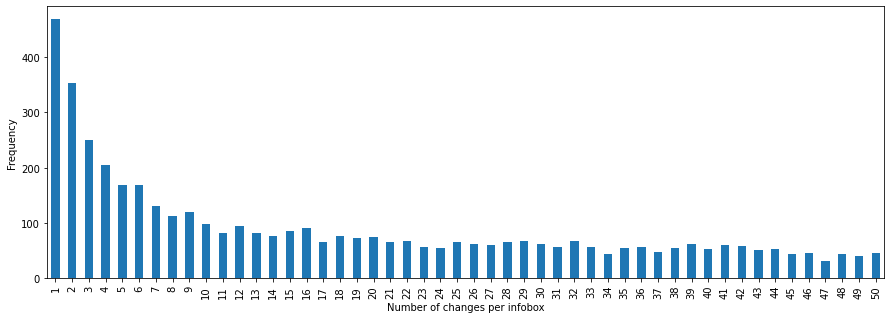

In [21]:
frequ_of_changes.sort_index(ascending=True)[:50].plot.bar(figsize=(15,5))
plt.xlabel("Number of changes per infobox")
plt.ylabel("Frequency")
plt.show()

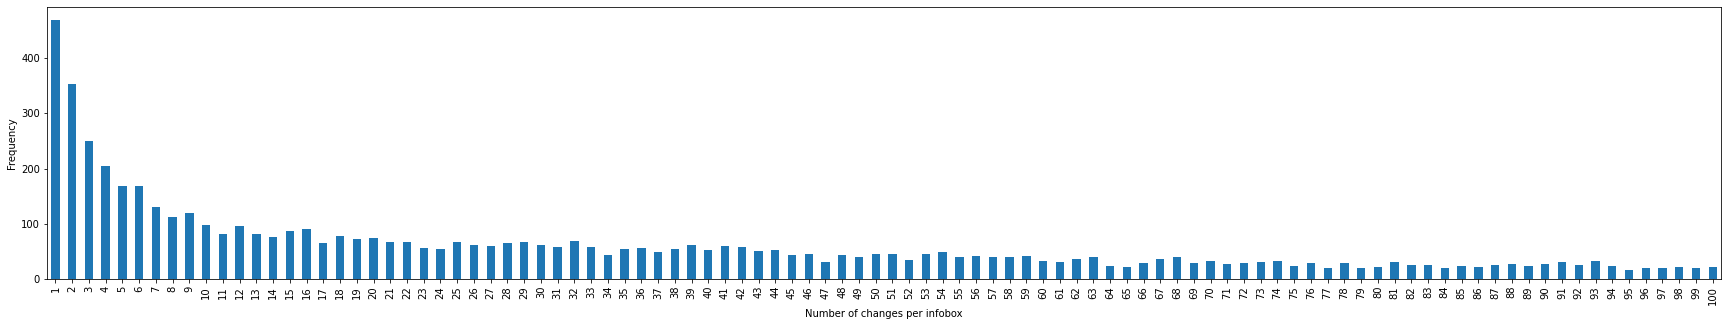

In [22]:
frequ_of_changes.sort_index(ascending=True)[:100].plot.bar(figsize=(30,5))
plt.xlabel("Number of changes per infobox")
plt.ylabel("Frequency")
plt.show()

## What is a good threshold? How many changes should be our minimum to make reliable predictions?

Start with at least 100 changes

In [38]:
changes_per_key_many_changes = changes_per_key[changes_per_key>=100]

In [25]:
print('Only {} unique infoboxes left in the subset.'.format(changes_per_key_many_changes.shape[0]))

Only 3614 unique infoboxes left in the subset.


In [39]:
data = data[data['key'].isin(changes_per_key_many_changes.index)]

In [27]:
data

key                 title          name  \
364      11977384-0  Australian Democrats      ideology   
365      11977384-0  Australian Democrats      ideology   
366      11977384-0  Australian Democrats      template   
368      11977384-0  Australian Democrats    party_logo   
369      11977384-0  Australian Democrats    foundation   
...             ...                   ...           ...   
8087081  65523991-0          Cameron Diaz  years_active   
8087082  65523991-0          Cameron Diaz    occupation   
8087083  65523991-0          Cameron Diaz  years_active   
8087084  65523991-0          Cameron Diaz    occupation   
8087085  65523991-0          Cameron Diaz    occupation   

                                       previous_value  \
364                     [[liberalism|social liberal]]   
365                             Social [[Liberalism]]   
366                           infobox_political_party   
368              [[Image:Australiandemocratlogo.gif]]   
369                                          [[1977]]   
...                                               ...   
8087081                                     1994–2014   
8087082         Retired actress, writer, former model   
8087083                                     1990–2014   
8087084         Artist, actress, writer, former model   
8087085  {{hlist|Artist|actress|writer|former model}}   

                                             current_value  \
364                                  Social [[Liberalism]]   
365                          [[liberalism|social liberal]]   
366                     infobox_australian_political_party   
368                     [[Image:Ausdem_newlogo.JPG|200px]]   
369                                                   1977   
...                                                    ...   
8087081                                          1990–2014   
8087082              Artist, actress, writer, former model   
8087083                                          1990–2016   
8087084       {{hlist|Artist|actress|writer|former model}}   
8087085  {{hlist|Artist|writer|former actress|former mo...   

                        timestamp  
364     2005-07-04 22:29:15+00:00  
365     2005-07-05 00:56:54+00:00  
366     2005-09-23 07:26:21+00:00  
368     2005-10-15 06:06:44+00:00  
369     2005-12-17 13:54:59+00:00  
...                           ...  
8087081 2019-07-30 15:28:45+00:00  
8087082 2019-08-11 05:22:26+00:00  
8087083 2019-08-25 01:25:27+00:00  
8087084 2019-08-30 02:56:02+00:00  
8087085 2019-09-01 14:31:25+00:00  

[1715146 rows x 6 columns]

## Look at changes per (key, propertyName) tuple

In [14]:
changes_per_key_and_name = data[['key','name']].value_counts()

In [15]:
changes_per_key_and_name

key          name           
118964357-0  num_episodes       2962
37799480-0   genre              1595
528594712-0  current_members    1315
95362092-0   judges             1077
321925250-0  num_episodes        781
                                ... 
61370503-0   term_end              1
             template              1
300431242-0  released              1
             template              1
100002730-0  coordinates           1
Length: 2130670, dtype: int64

In [21]:
changes_per_key_and_name[:50]

key          name                
118964357-0  num_episodes            2962
37799480-0   genre                   1595
528594712-0  current_members         1315
95362092-0   judges                  1077
321925250-0  num_episodes             781
24291635-0   genre                    770
127788329-0  gross                    762
72362254-0   current champions        678
31536085-0   genre                    676
89677820-0   misc                     664
37149965-0   result                   658
173468547-0  incumbent                654
19402539-3   name                     653
269976299-0  awards                   638
57793854-0   updated                  638
545084225-0  ideology                 621
628311504-0  num_episodes             592
57793854-0   singlesrecord            586
90429869-0   currentclub              586
40487670-0   nickname                 564
504878331-0  starring                 556
134131257-0  years                    556
212998861-0  type                     552


Filter out combinations with <100 changes again

In [16]:
changes_per_key_and_name_many_changes  = changes_per_key_and_name[changes_per_key_and_name>=100]

In [17]:
print('Only {} unique (infobox, property) combinations left in the subset.'.format(changes_per_key_and_name_many_changes.shape[0]))

Only 2327 unique (infobox, property) combinations left in the subset.


In [18]:
data = data[data[['key','name']].apply(tuple, axis=1).isin(changes_per_key_and_name_many_changes.index)]

In [19]:
data.shape[0]

387096

## Look at widely used template types

In [7]:
popular_template_types = data.groupby(['template'])['title'].nunique().reset_index().rename(columns={'title':'count'})

In [65]:
popular_template_types['percentage'] = popular_template_types['count']*100 / popular_template_types['count'].sum()

Only look at the top 10 most popular template types

In [78]:
top10_template_types = popular_template_types.sort_values('count', ascending=False)[1:11]

In [79]:
top10_template_types

template  count  percentage
6817           infobox person   1156    2.853264
8627       infobox settlement    625    1.542639
5902   infobox musical artist    469    1.157596
10012          infobox writer    421    1.039121
8073          infobox royalty    404    0.997162
422             infobox actor    365    0.900901
8389        infobox scientist    365    0.900901
6533     infobox officeholder    363    0.895964
271                   infobox    337    0.831791
5612          infobox monarch    295    0.728125

In [77]:
data[(data['template']=='') & (data['deletion']==False)]

Empty DataFrame
Columns: [key, title, name, previous_value, current_value, timestamp, template, creation, deletion]
Index: []

If the template type is the empty string, the property has been deleted. Therefore we can ignore it in our future research.

<AxesSubplot:xlabel='template'>

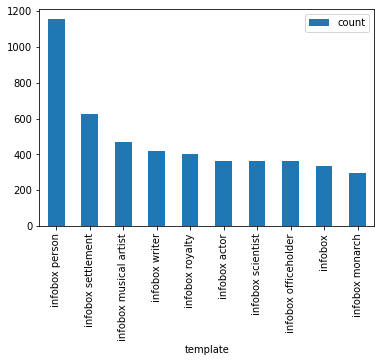

In [19]:
top10_template_types.plot.bar(x='template')

In [22]:
top10_template_types_list = top10_template_types['template'].tolist()

In [23]:
top10_template_types_list

['infobox person',
 'infobox settlement',
 'infobox musical artist',
 'infobox writer',
 'infobox royalty',
 'infobox actor',
 'infobox scientist',
 'infobox officeholder',
 'infobox',
 'infobox monarch']

In [48]:
data_popular_temp = data[data['template'].isin(top10_template_types_list)]

In [53]:
data_popular_temp.shape[0]*100/data.shape[0]

17.689063008549013

--> Using only the top 10 template types, we are left with 17% of the data

In [39]:
popular_properties = data.groupby(['name'])['title'].nunique().reset_index().rename(columns={'title':'count'})

In [40]:
popular_properties['percentage'] = popular_properties['count']*100 / popular_properties['count'].sum()

Only look at top 10 property types

In [59]:
top10_properties = popular_properties.sort_values('count', ascending=False)[:10]

In [60]:
top10_properties

name  count  percentage
35250     template  10849    2.020761
24262         name   8728    1.625698
18052        image   8137    1.515617
7889       caption   7354    1.369774
37802      website   3591    0.668868
6754    birth_date   3500    0.651918
6846   birth_place   3450    0.642605
11621   death_date   3273    0.609637
11665  death_place   3182    0.592687
18660   image_size   2998    0.558415

In [61]:
top10_properties_list = top10_properties['name'].tolist()

In [51]:
data_popular_prop = data[data['name'].isin(popular_properties_top_list)]

In [52]:
data_popular_prop.shape[0]*100/data.shape[0]

15.355809413193677

--> Using only the top 10 properties, we are left with 15% of the data

Intersection of both

In [96]:
data_pop = data[data['name'].isin(top10_properties_list) & data['template'].isin(top10_template_types_list)]

In [80]:
data_pop.shape[0]*100/data.shape[0]

4.073467263046562

--> Finally the intersection of both leaves us with 4% of the original data

## Draw boxplots for change frequencies

In [97]:
data_pop

key               title         name  \
94       463083871-0  Alappuzha district     template   
114      463083871-0  Alappuzha district      website   
117      463083871-0  Alappuzha district         name   
157      463083871-0  Alappuzha district      website   
168      463083871-0  Alappuzha district      website   
...              ...                 ...          ...   
9968948   44480494-0      Sandra Bullock      caption   
9968950   44480494-0      Sandra Bullock  birth_place   
9968958   44480494-0      Sandra Bullock      caption   
9968959   44480494-0      Sandra Bullock      caption   
9968960   44480494-0      Sandra Bullock   birth_date   

                                            previous_value  \
94                             infobox indian jurisdiction   
114                                                   None   
117                                                   None   
157                                                          
168               http://alappuzha.nic.in/home/default.htm   
...                                                    ...   
9968948                                    Bullock in 2013   
9968950               [[Arlington County, Virginia]], U.S.   
9968958  Bullock at an event for ''[[The Heat (film)|Th...   
9968959                               Bullock in July 2013   
9968960           {{Birth date and age|mf=yes|1964|07|26}}   

                                             current_value  \
94                                      infobox settlement   
114                                                          
117                                     Alappuzha district   
157               http://alappuzha.nic.in/home/default.htm   
168      [http://alappuzha.nic.in/home/default.htm alap...   
...                                                    ...   
9968948  Bullock at an event for ''[[The Heat (film)|Th...   
9968950                      [[Arlington, Virginia]], U.S.   
9968958                               Bullock in July 2013   
9968959  Bullock at an event for ''[[The Heat (film)|Th...   
9968960           {{birth date and age|mf=yes|1964|07|26}}   

                        timestamp            template  creation  deletion  
94      2012-05-30 11:03:09+00:00  infobox settlement     False     False  
114     2012-05-30 11:03:09+00:00  infobox settlement      True     False  
117     2012-05-30 11:03:09+00:00  infobox settlement      True     False  
157     2013-03-15 17:58:00+00:00  infobox settlement     False     False  
168     2013-03-26 21:11:43+00:00  infobox settlement     False     False  
...                           ...                 ...       ...       ...  
9968948 2018-12-29 09:56:53+00:00      infobox person     False     False  
9968950 2019-02-08 13:37:42+00:00      infobox person     False     False  
9968958 2019-02-08 13:37:42+00:00      infobox person     False     False  
9968959 2019-06-26 06:46:11+00:00      infobox person     False     False  
9968960 2019-07-26 07:15:27+00:00      infobox person     False     False  

[406131 rows x 9 columns]

In [110]:
data_pop['time_diff'] = data_pop.sort_values(['key','timestamp']).groupby(['key','title','name','template'])['timestamp'].diff()
data_pop.dropna(subset=['time_diff'],inplace=True)

/opt/homebrew/Caskroom/miniforge/base/envs/wikipedia/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/homebrew/Caskroom/miniforge/base/envs/wikipedia/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


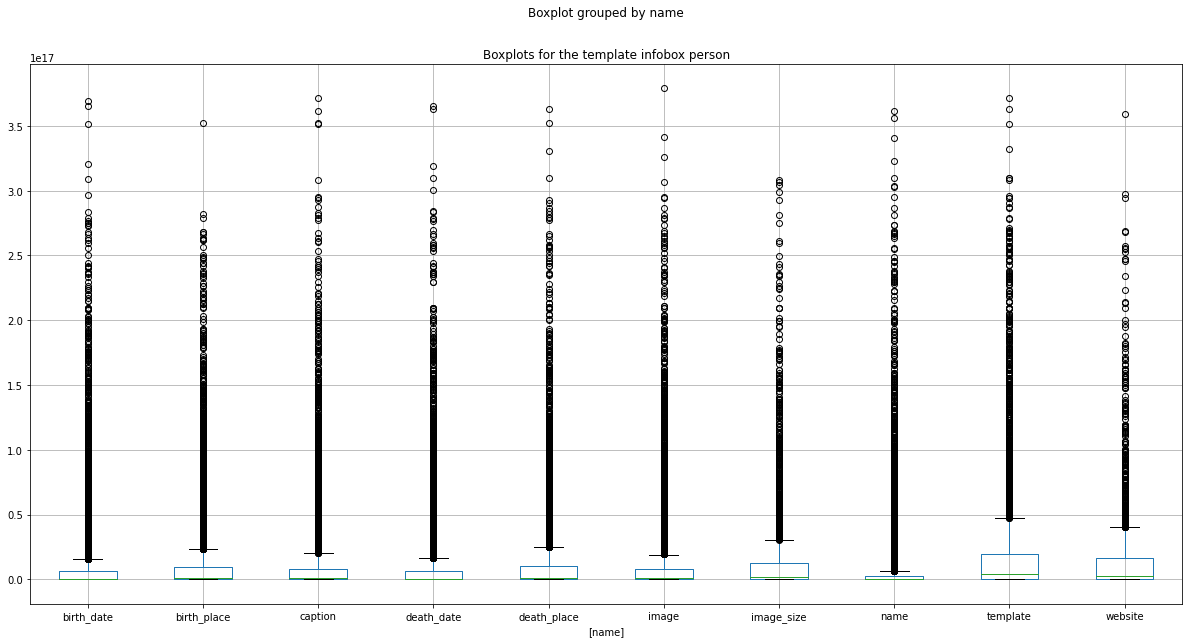

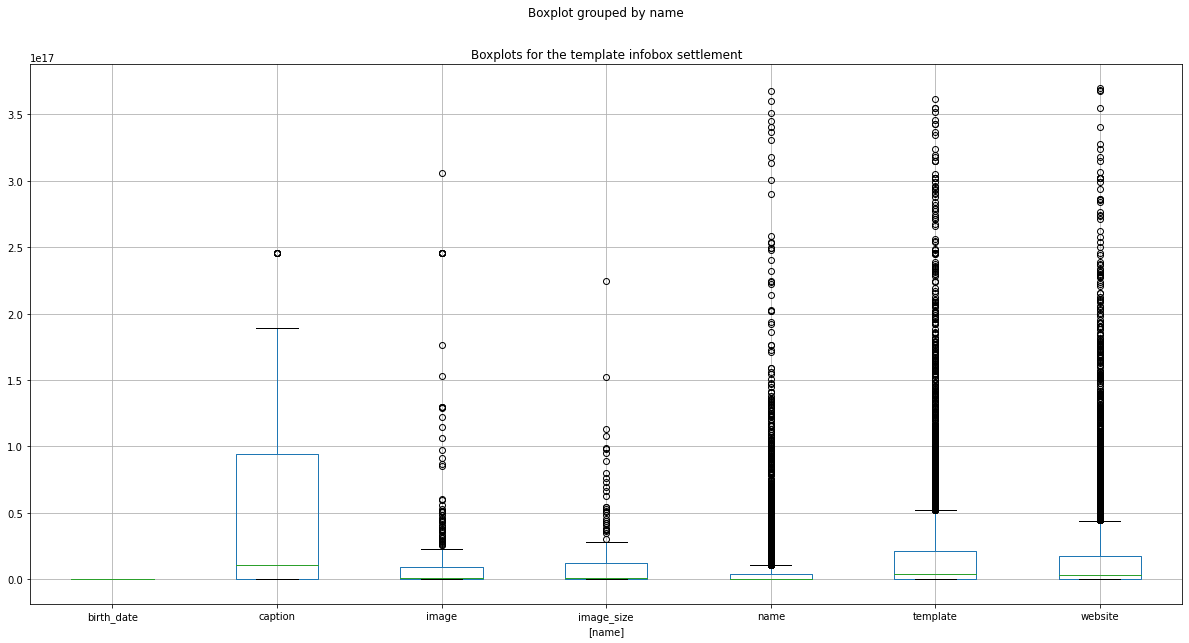

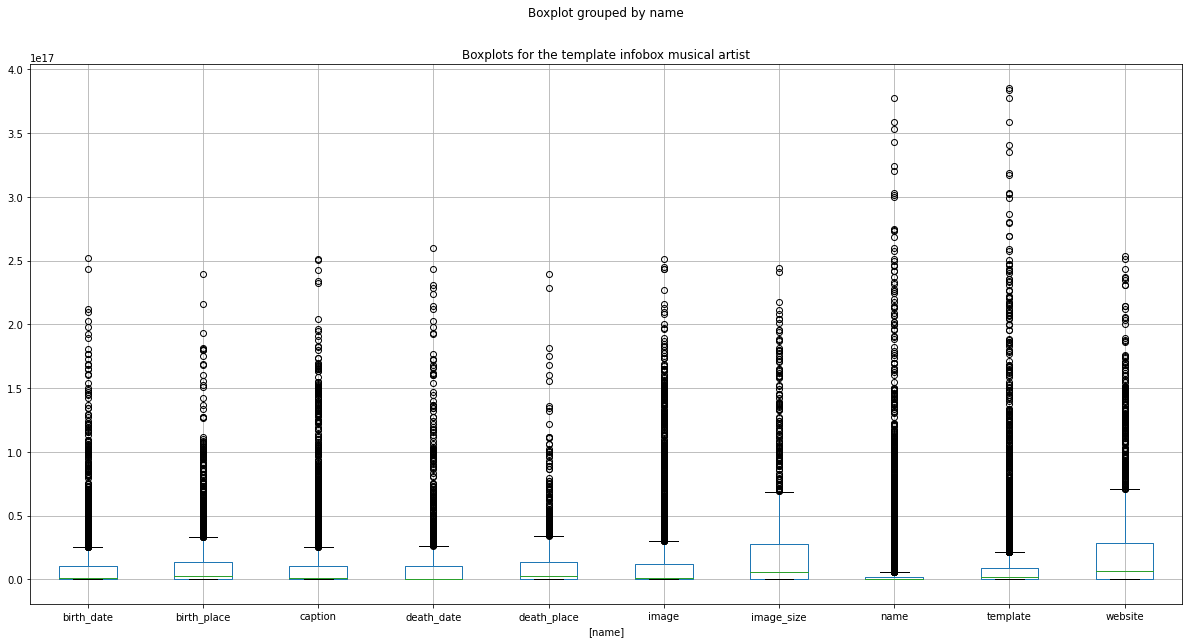

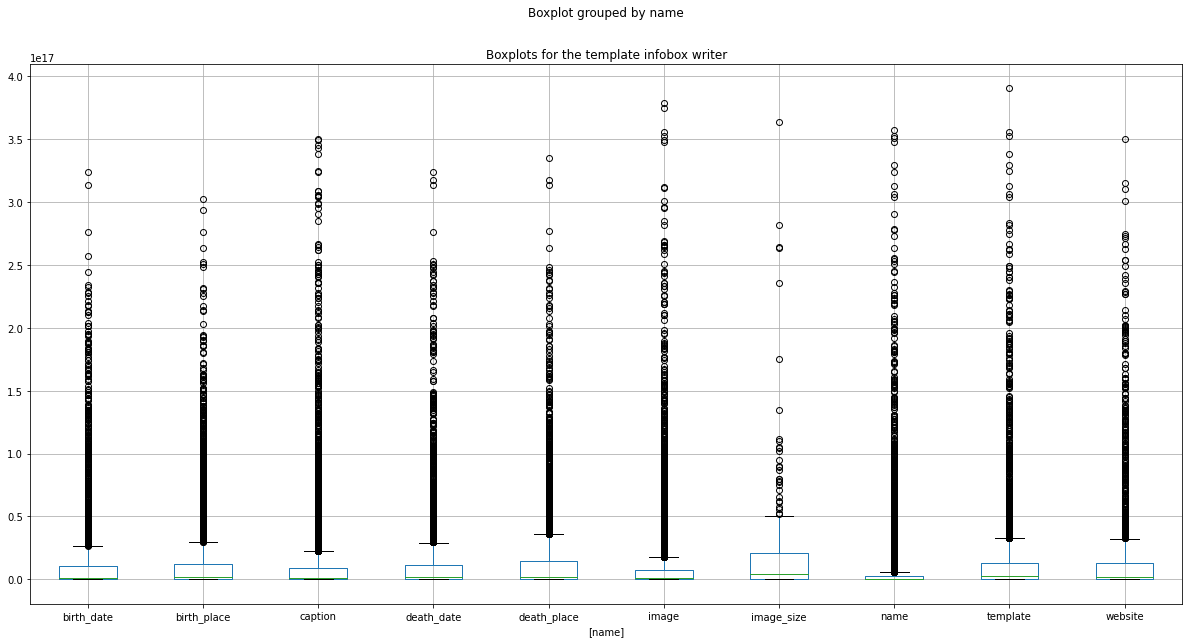

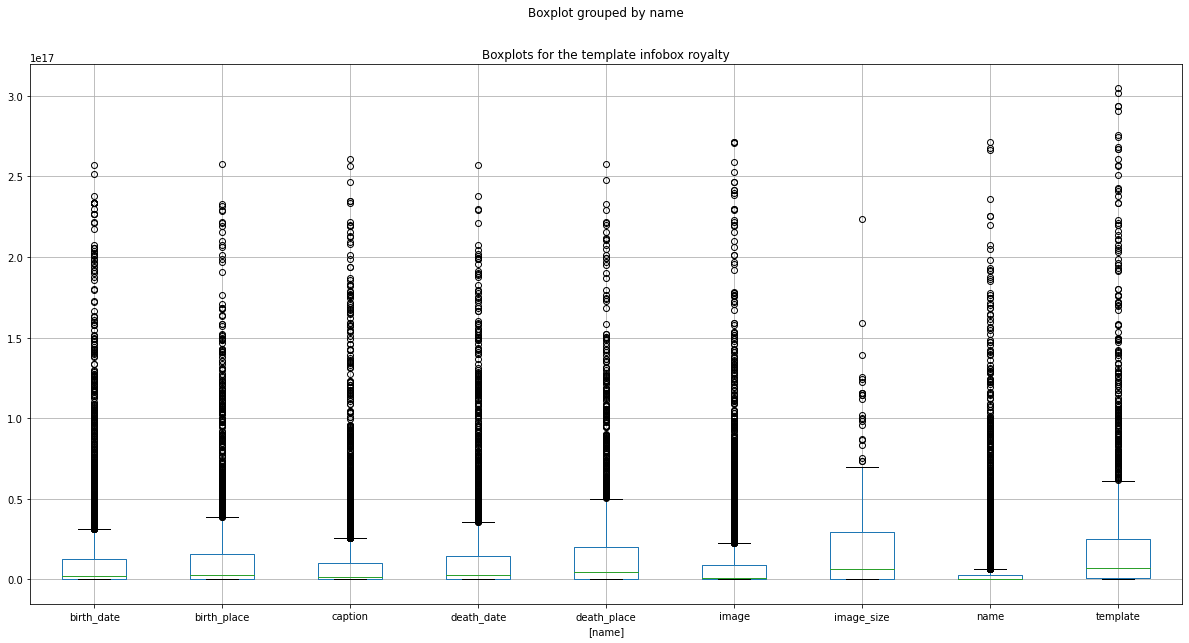

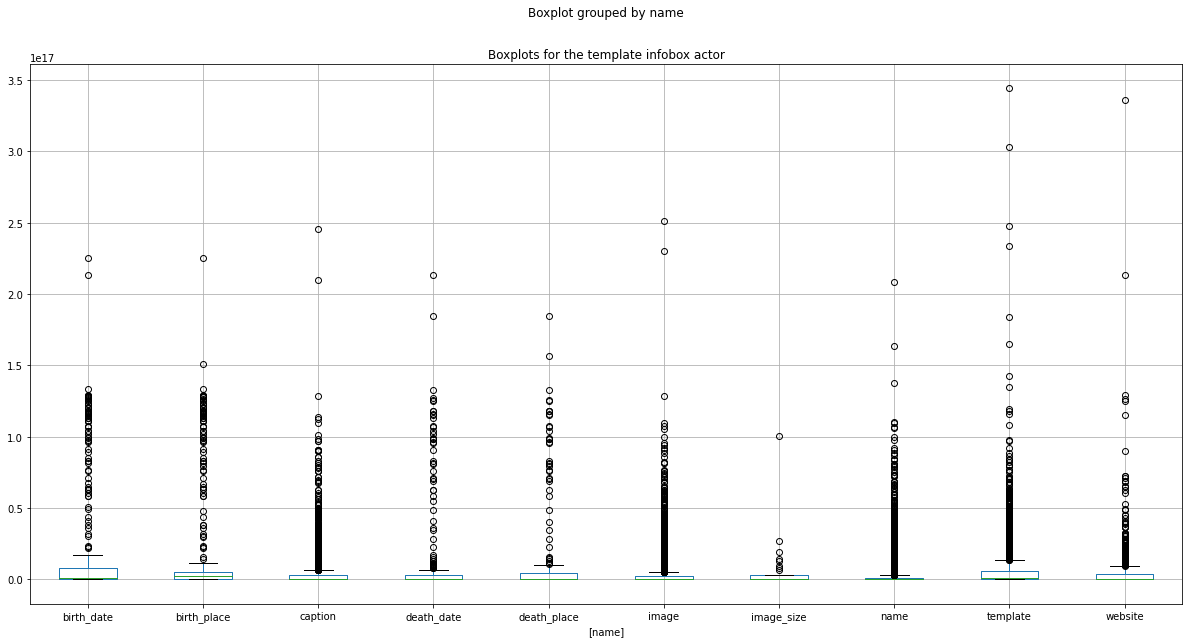

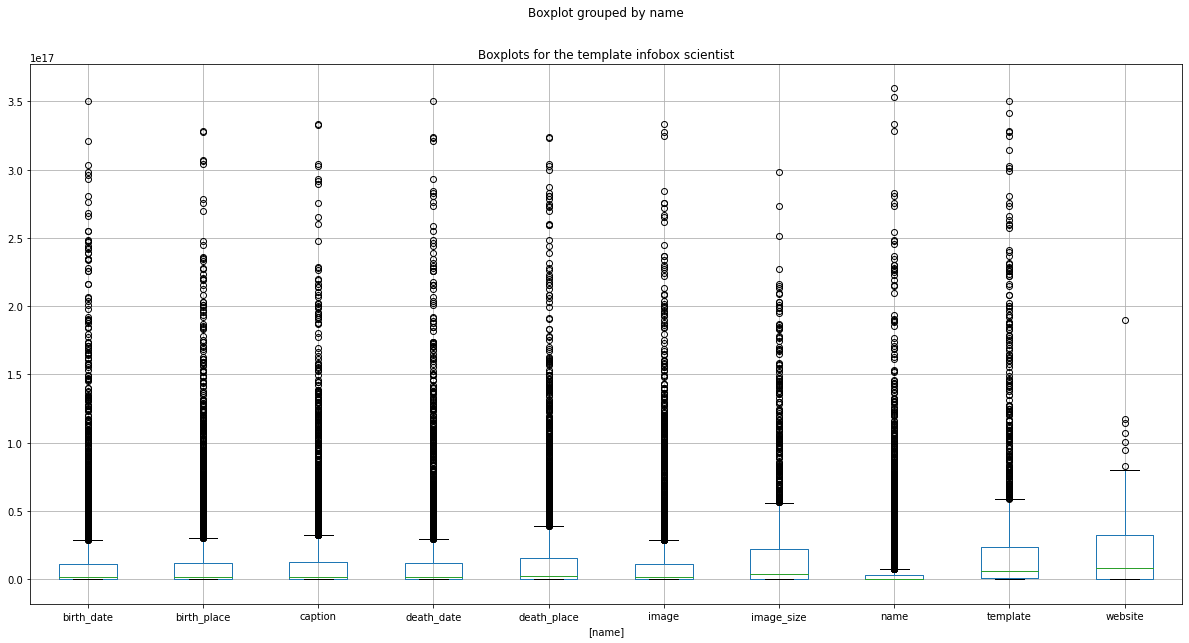

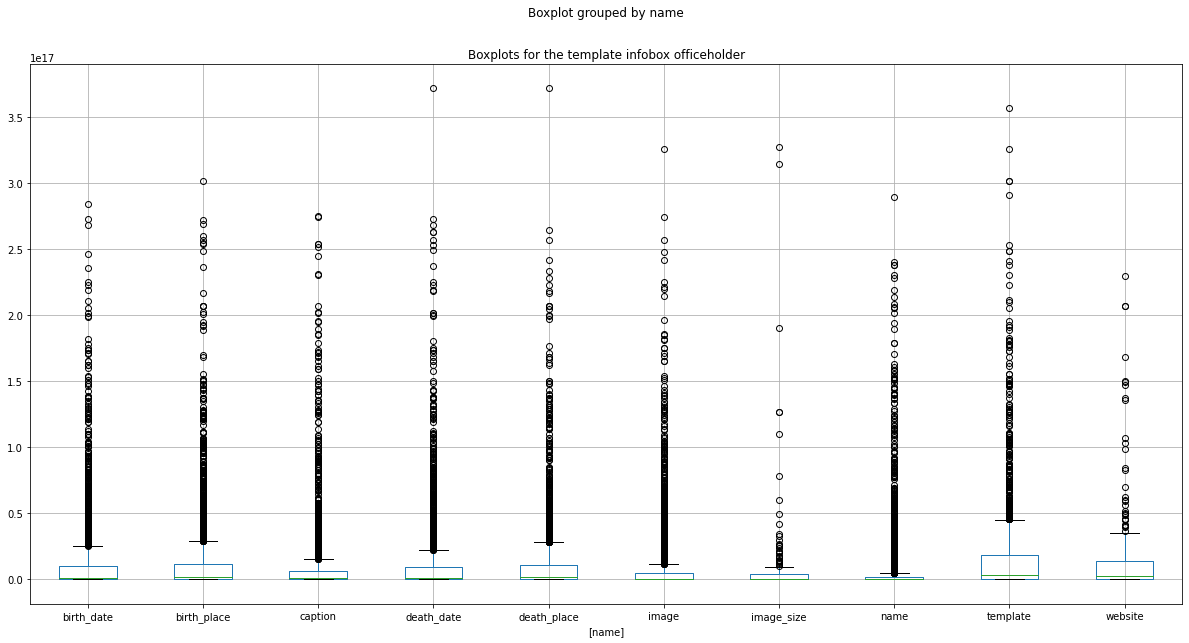

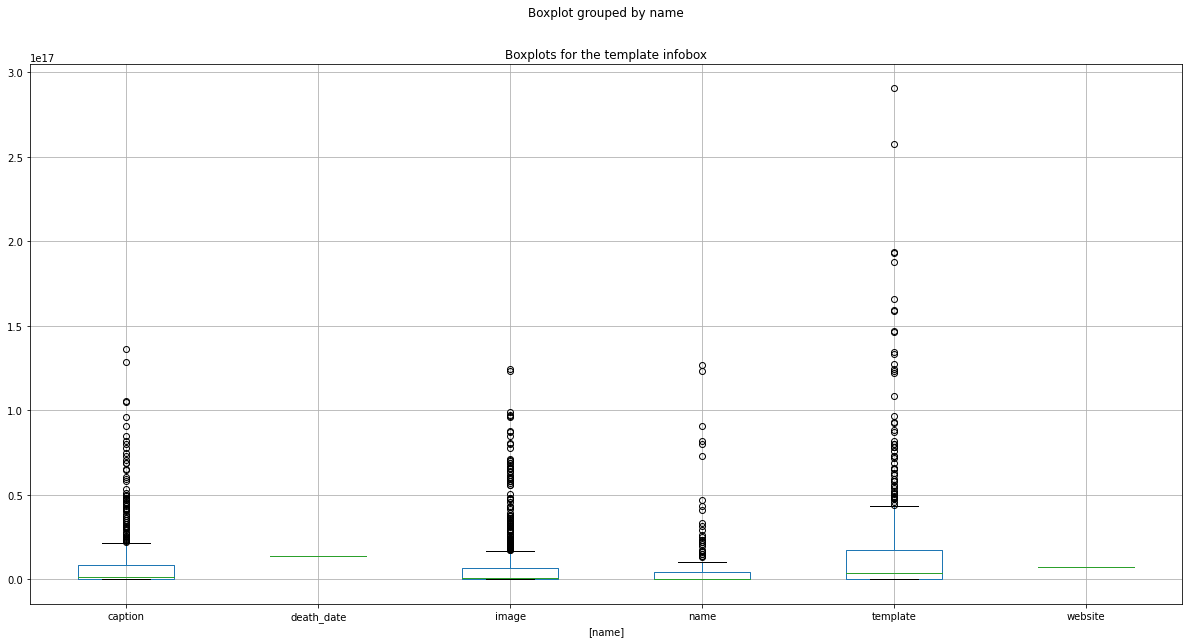

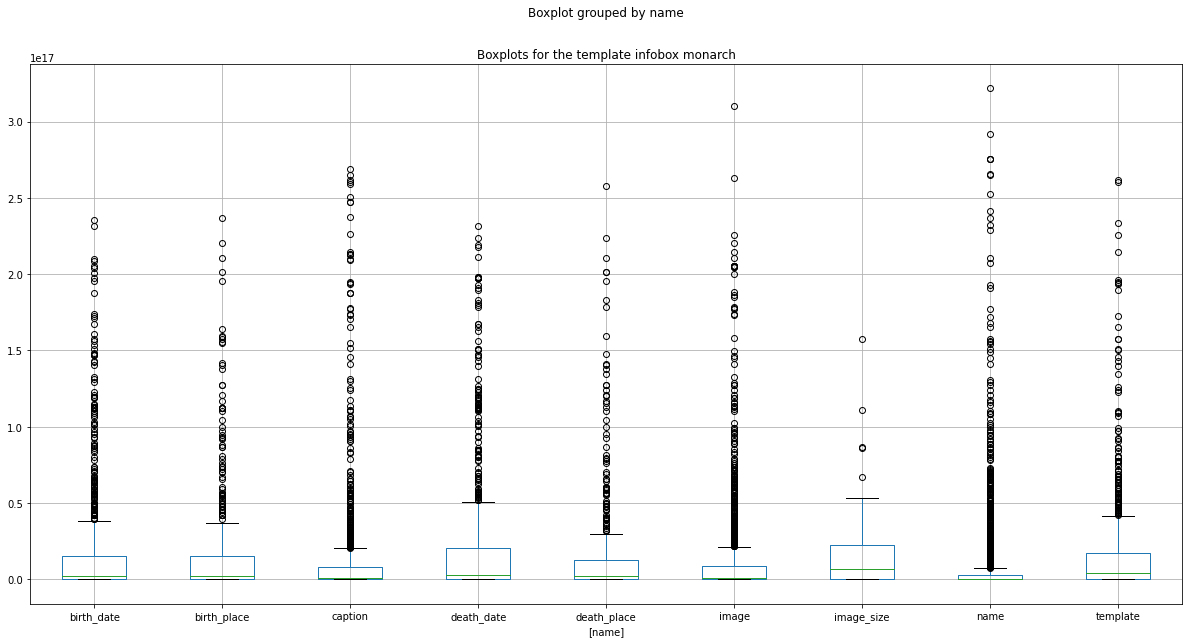

In [115]:
for temp in top10_template_types_list:
    data_pop[data_pop['template']==temp].boxplot(column='time_diff', by=['name'], figsize=(20,10))
    plt.title('Boxplots for the template {}'.format(temp))
    plt.show()

In [82]:
avg_time_diff = data_popular.groupby(['key','name','template']).apply(lambda x: x['timestamp'].sort_values().diff().mean()).reset_index()
avg_time_diff.rename(columns={0:'avgChangeFrequ'},inplace=True)

In [84]:
avg_time_diff

key         name            template  \
0      100081181-0     template  infobox settlement   
1      100081181-0      website  infobox settlement   
2       10021127-0     template             infobox   
3      100214928-0   birth_date      infobox person   
4      100214928-0  birth_place      infobox person   
...            ...          ...                 ...   
33293   99958006-0   image_size     infobox royalty   
33294   99958006-0         name     infobox monarch   
33295   99958006-0         name     infobox royalty   
33296   99958006-0     template     infobox monarch   
33297   99958006-0     template     infobox royalty   

                   avgChangeFrequ  
0              1794 days 16:33:48  
1               532 days 19:11:27  
2                             NaT  
3     149 days 02:49:01.346153846  
4        204 days 12:31:14.850000  
...                           ...  
33293                         NaT  
33294  23 days 11:31:59.441441441  
33295  15 days 10:37:23.142857142  
33296    100 days 20:43:58.240000  
33297     65 days 09:48:35.800000  

[33298 rows x 4 columns]

In [ ]:
avg_time_diff['avgBinnedChangeFrequ'] = pd.cut(avg_time_diff['avgChangeFrequ'].fillna(pd.Timedelta(minutes = -1)), bins, labels = labels, include_lowest=True)

In [ ]:
plt.boxplot()

In [111]:
g = data_popular[data_popular['template']=='infobox person'].groupby(['key','name','template'])#['timestamp'].diff().mean()
avg_time_diff = g.apply(lambda x: x['timestamp'].sort_values().diff().mean()).reset_index()
avg_time_diff.rename(columns={0:'avgChangeFrequ'},inplace=True)
avg_time_diff['avgBinnedChangeFrequ'] = pd.cut(avg_time_diff['avgChangeFrequ'].fillna(pd.Timedelta(minutes = -1)), bins, labels = labels, include_lowest=True)

binned_counts = avg_time_diff.groupby(['name','avgBinnedChangeFrequ']).size().unstack(fill_value=0)

In [112]:
binned_counts = binned_counts.div(binned_counts.sum(axis=1), axis=0).mul(100)

In [113]:
properties=binned_counts.index

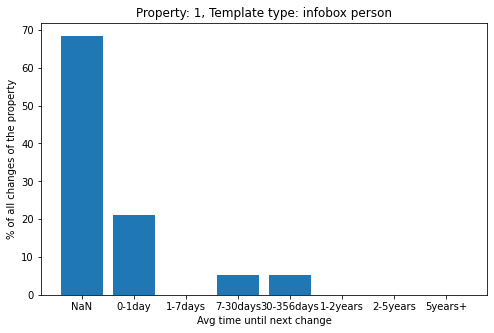

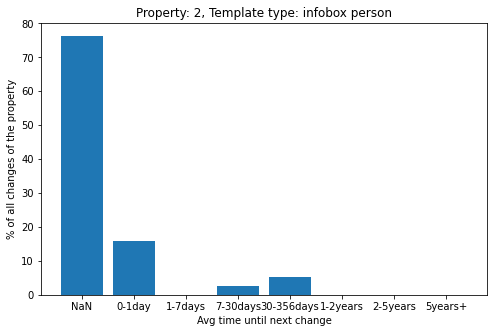

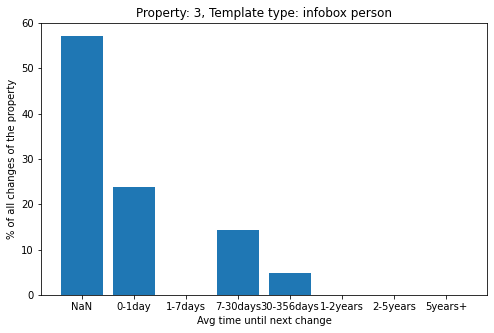

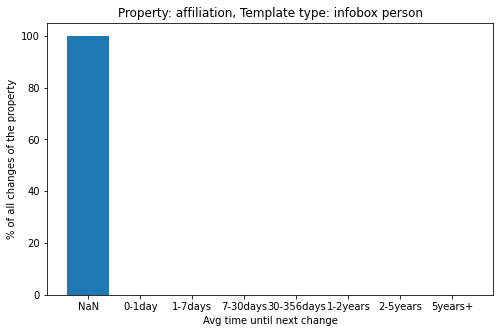

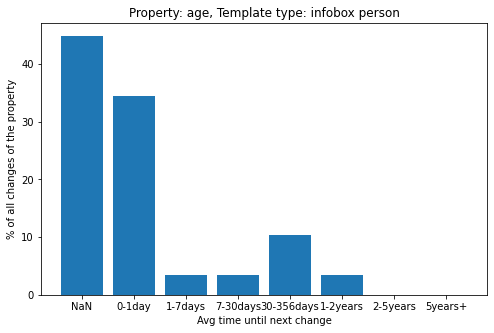

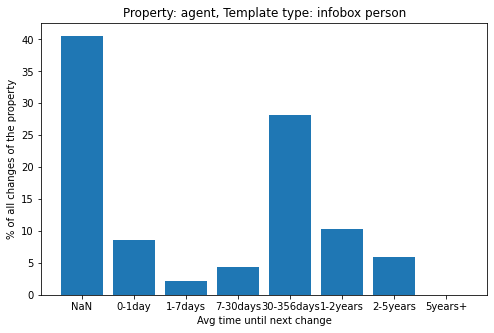

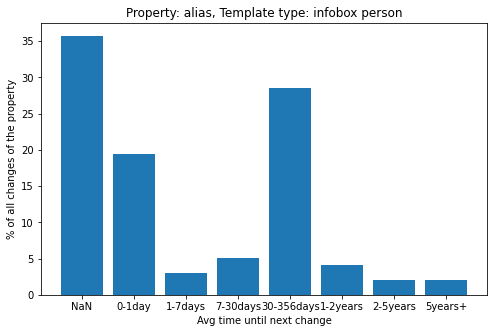

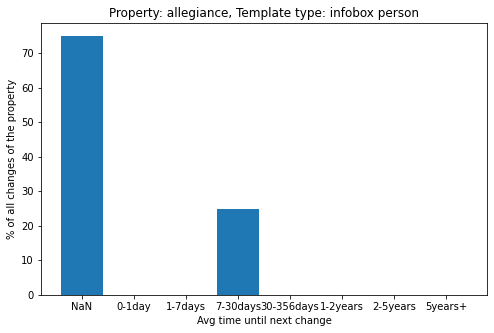

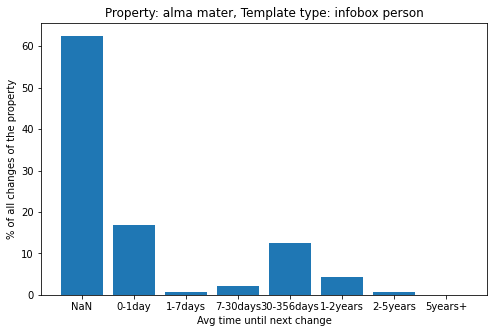

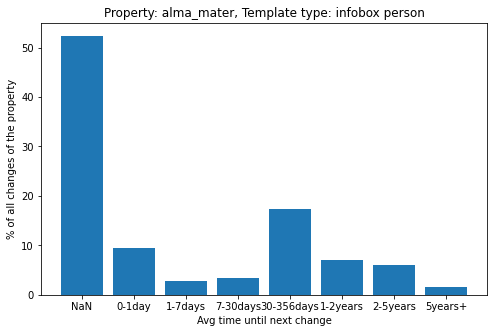

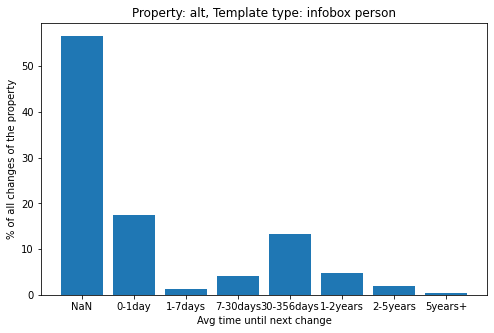

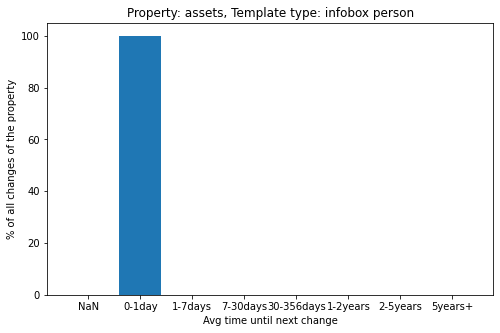

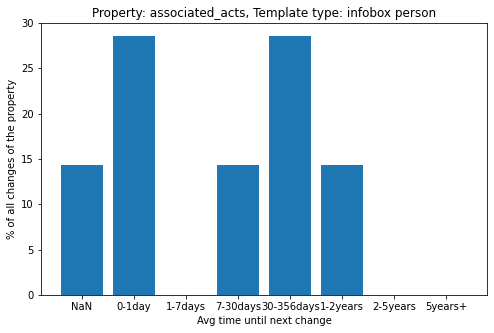

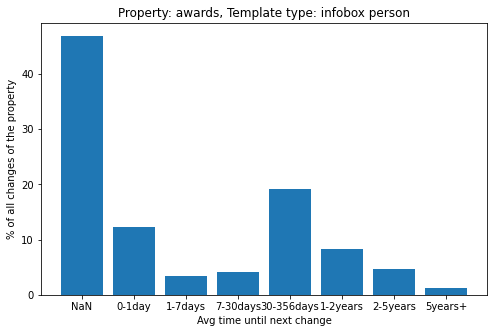

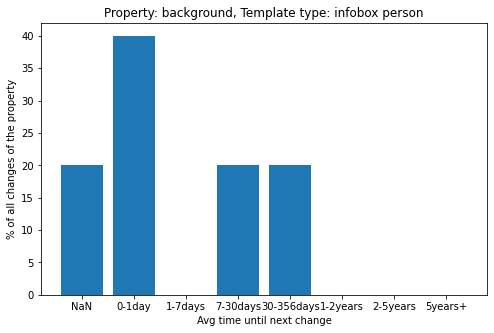

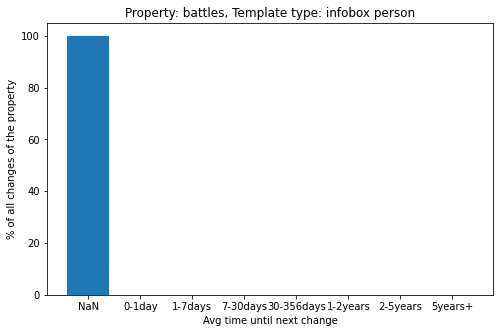

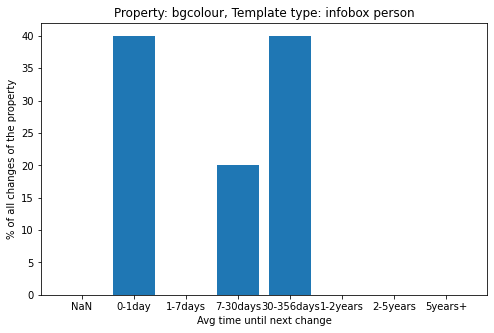

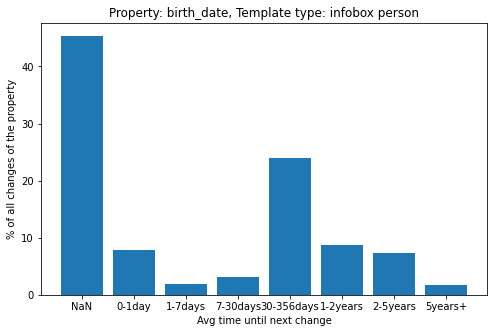

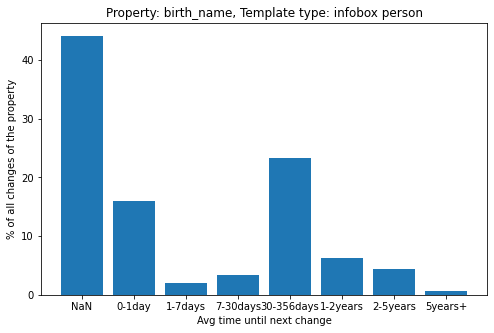

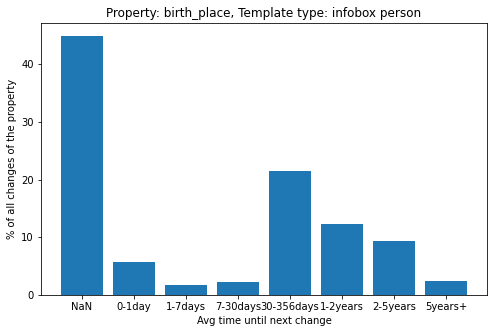

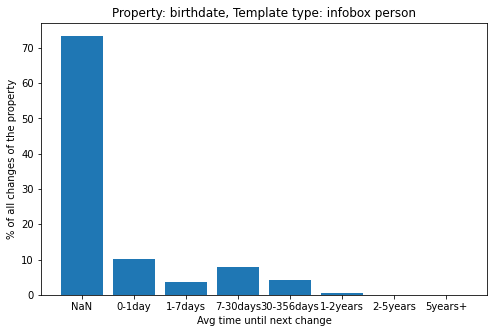

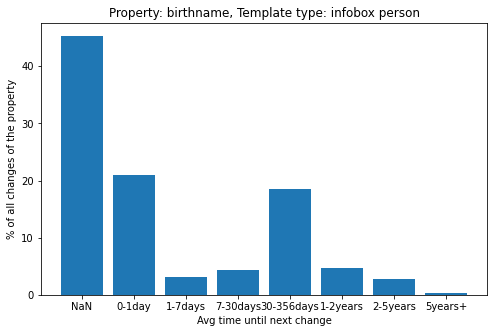

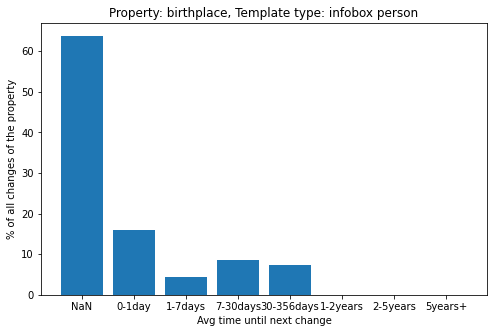

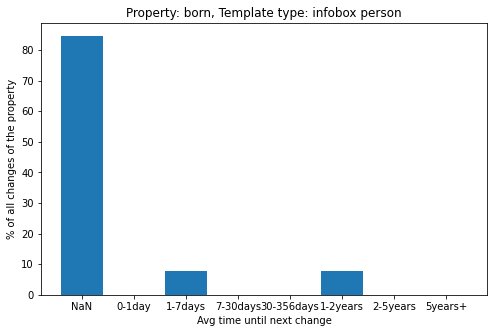

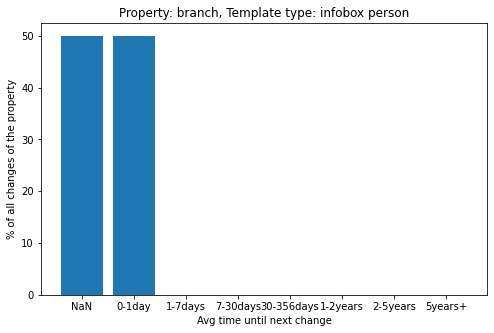

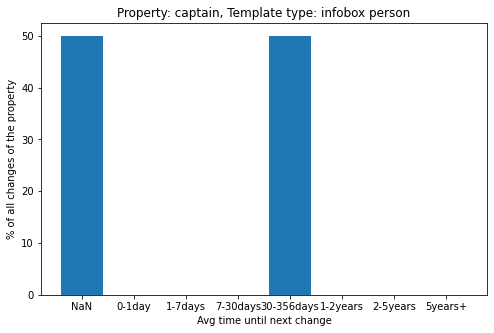

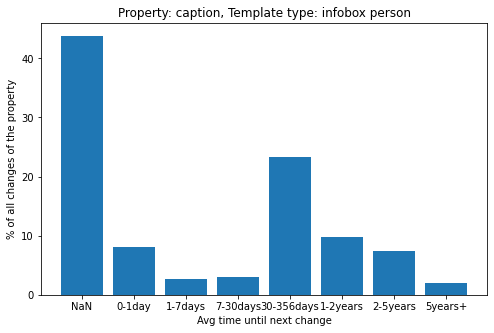

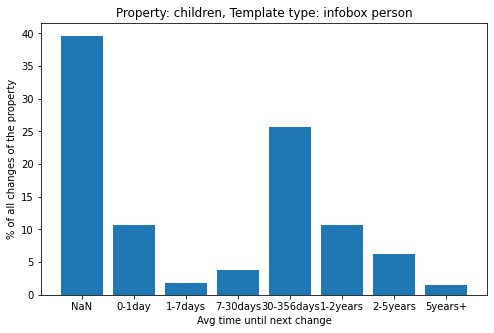

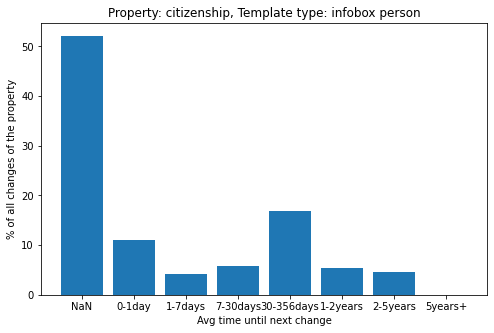

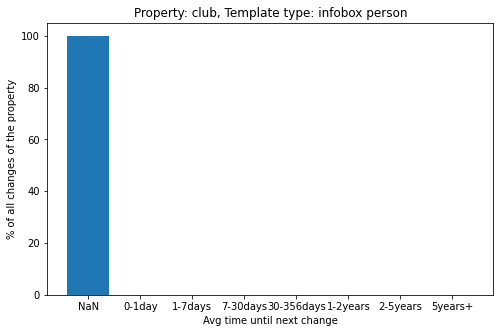

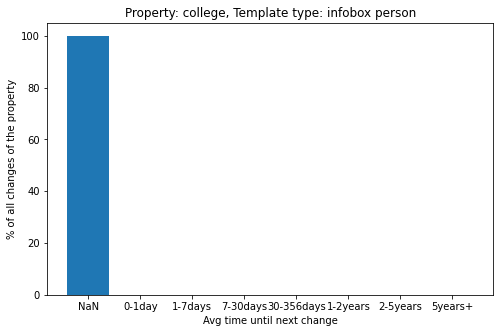

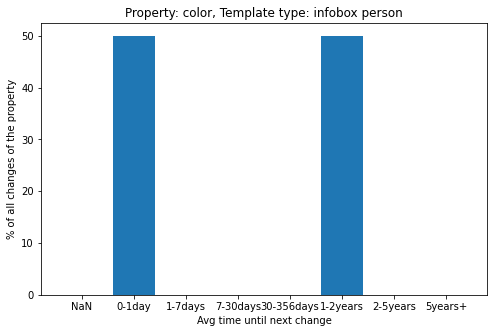

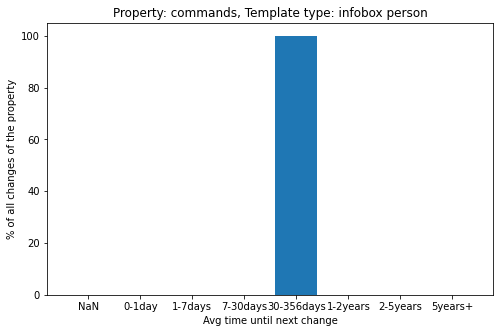

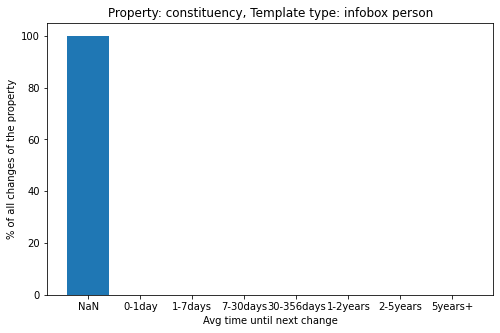

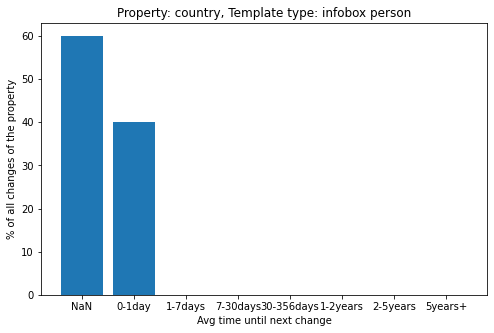

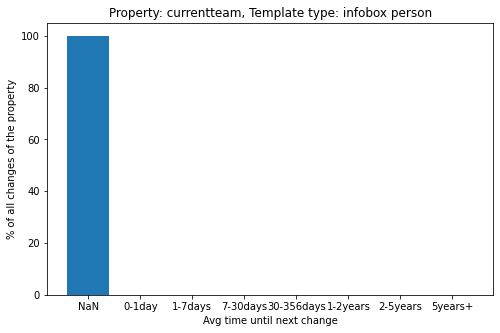

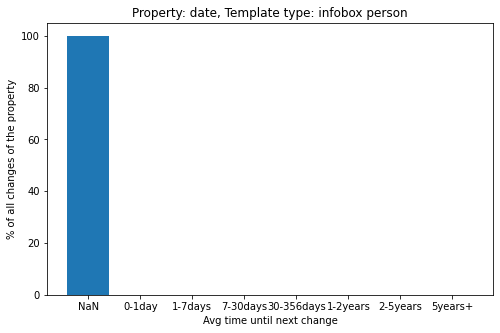

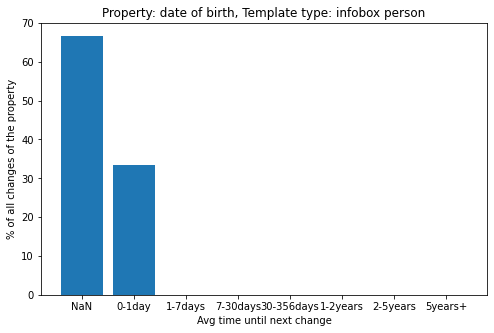

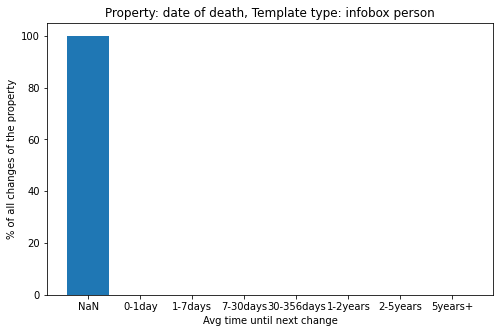

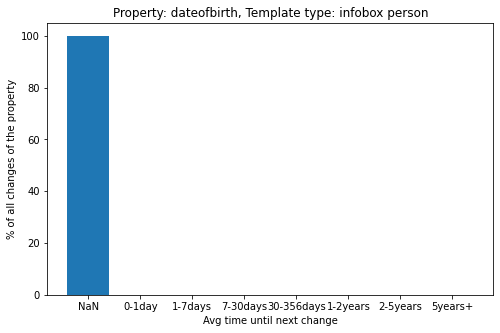

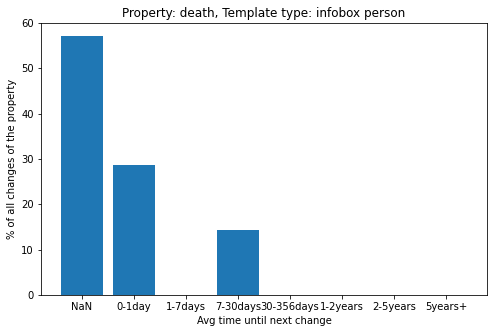

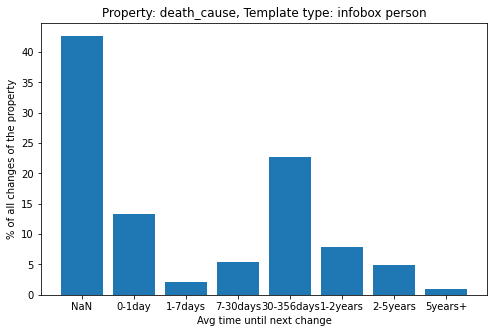

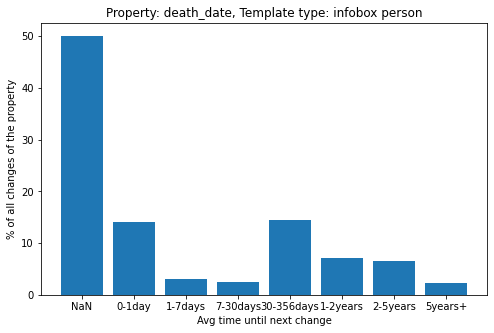

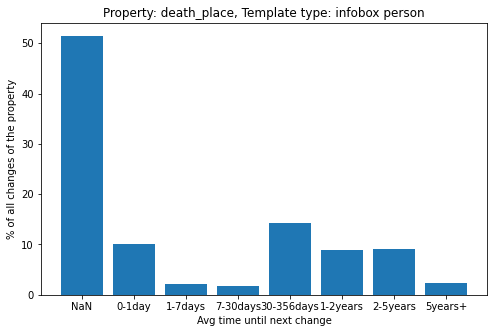

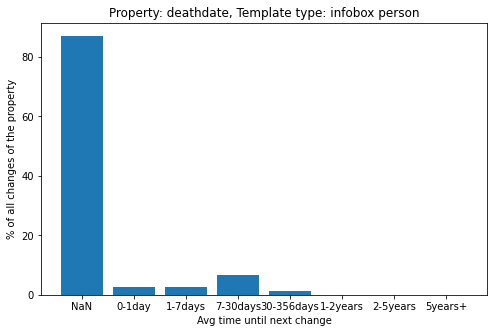

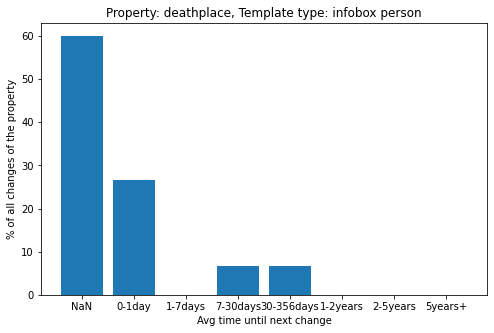

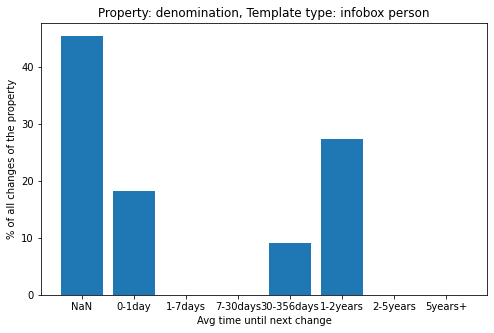

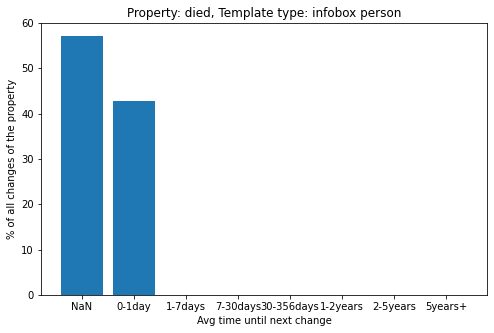

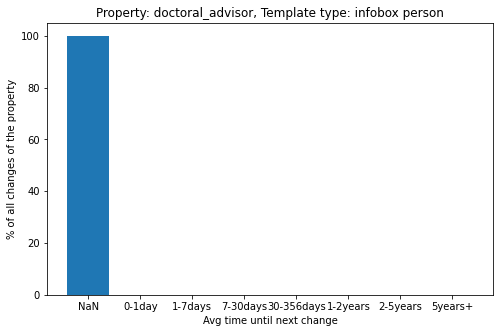

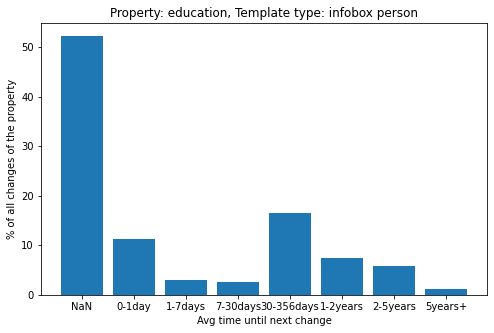

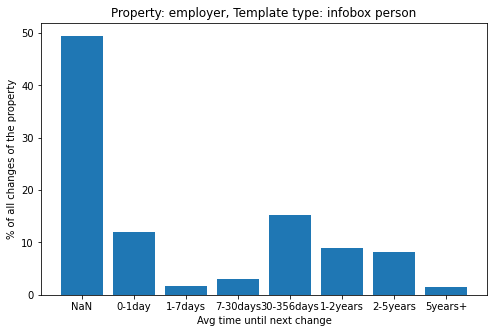

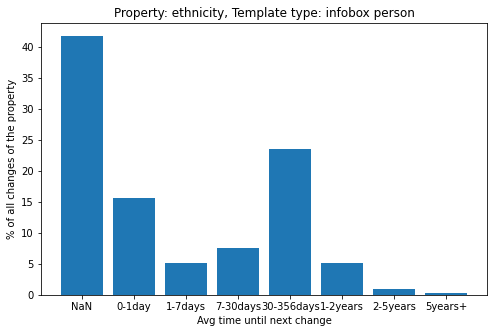

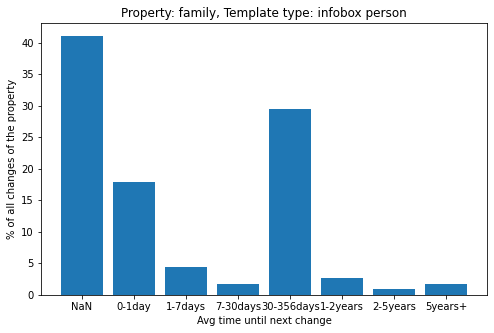

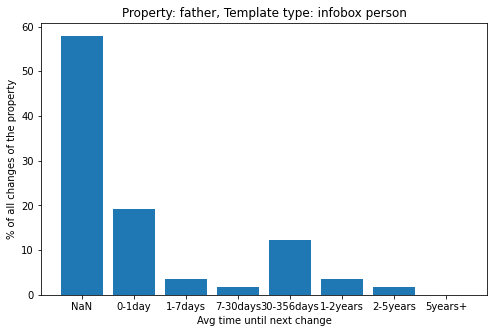

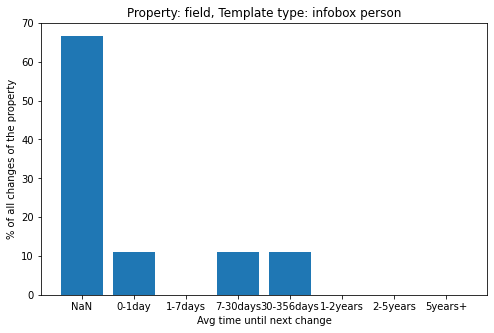

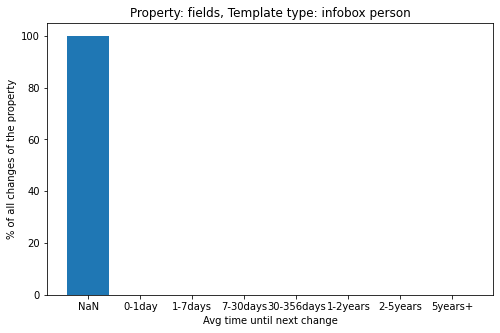

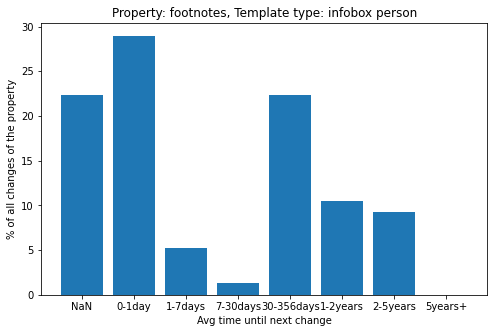

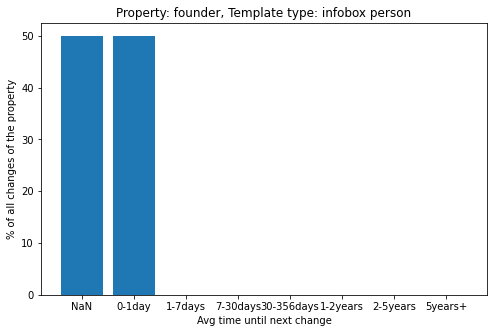

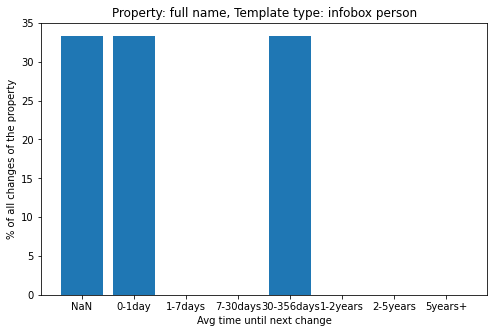

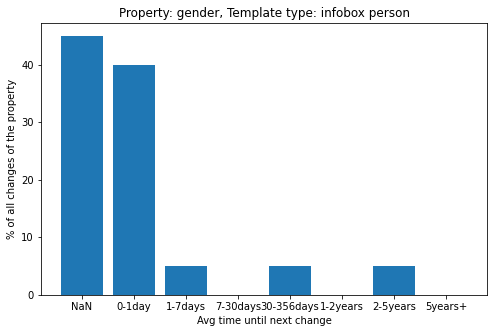

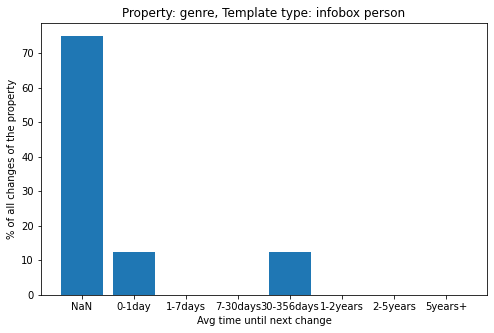

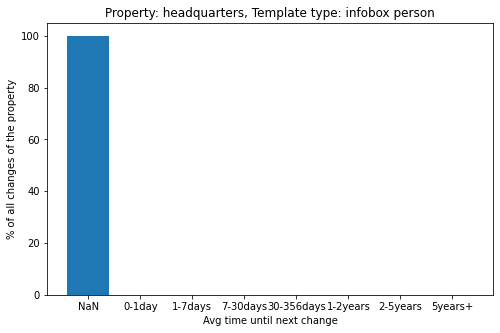

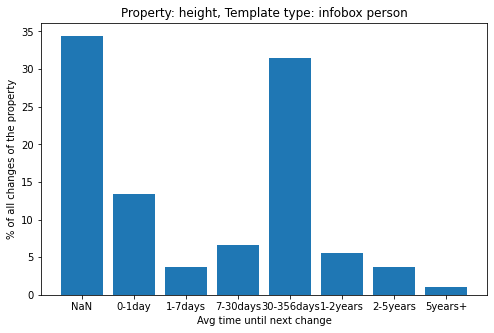

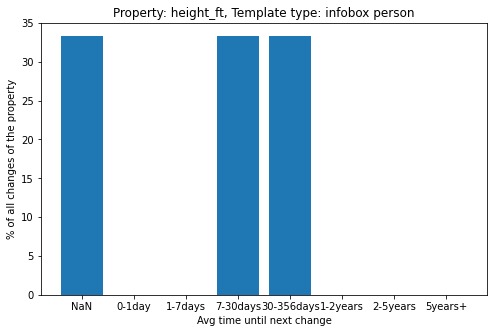

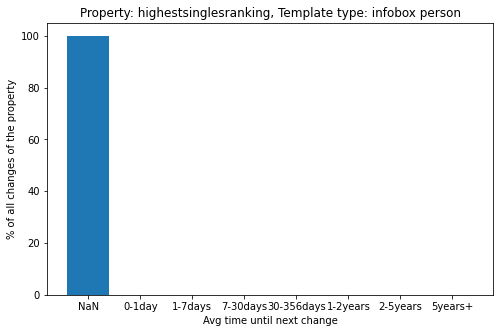

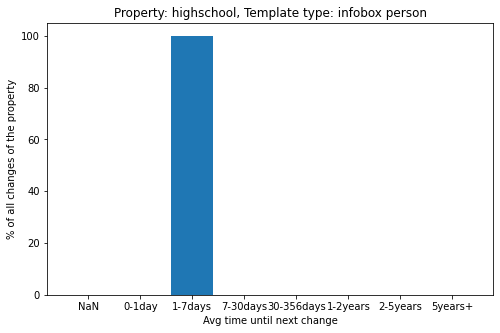

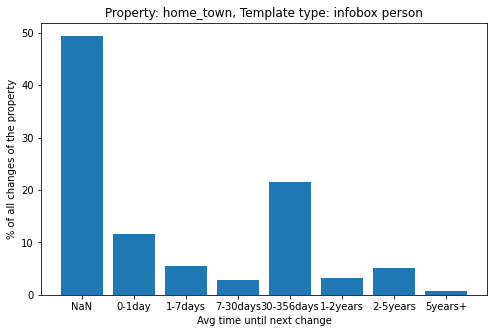

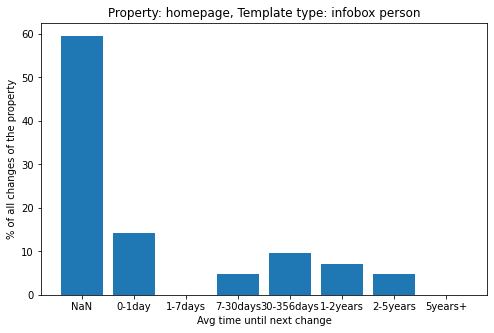

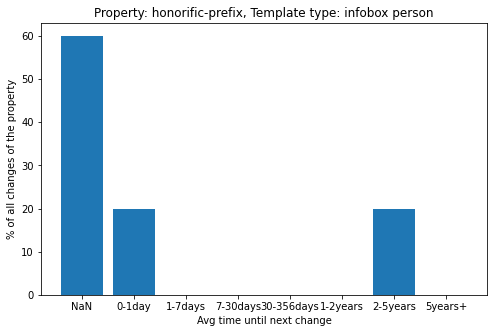

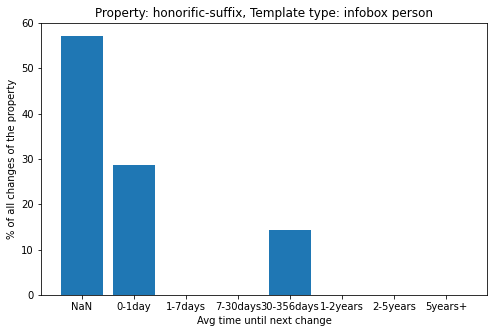

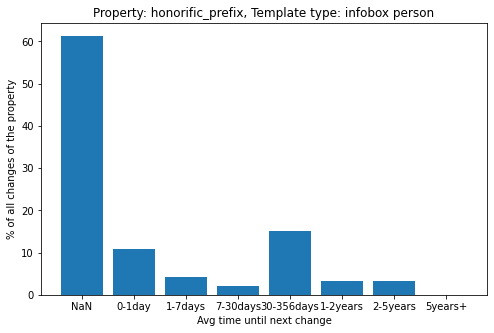

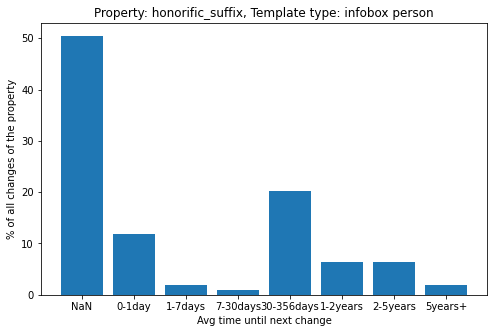

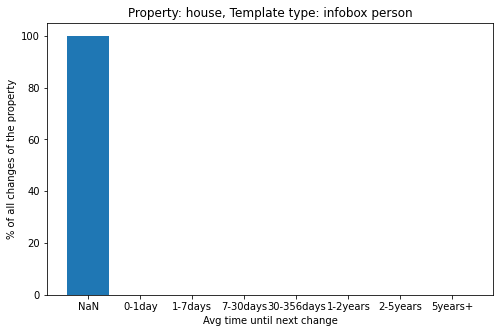

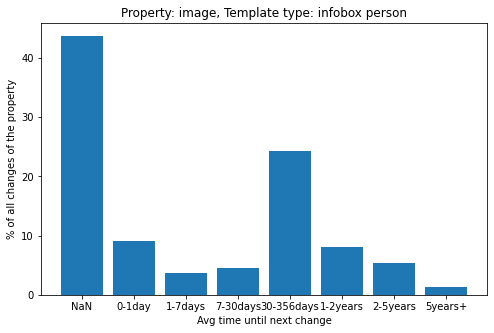

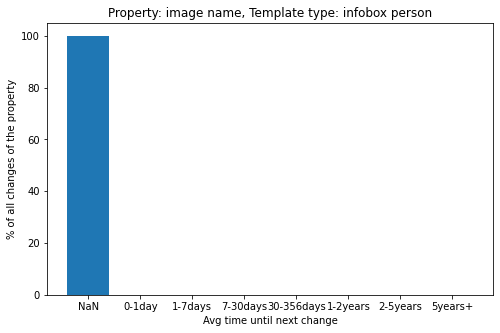

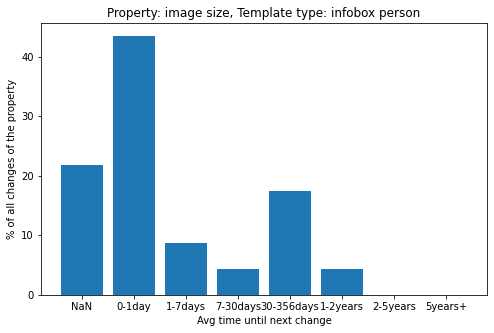

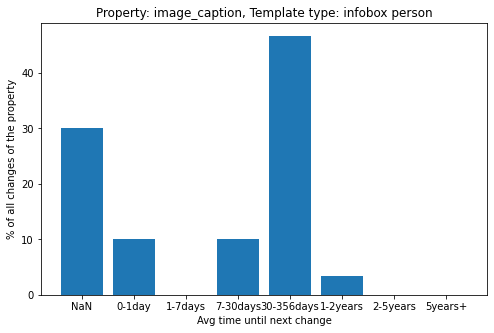

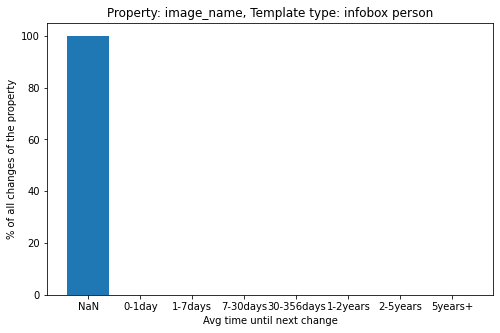

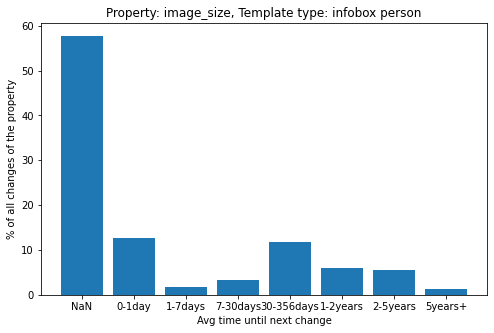

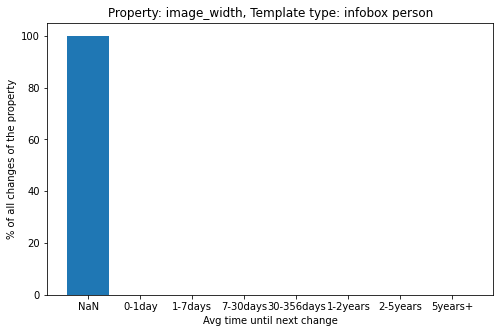

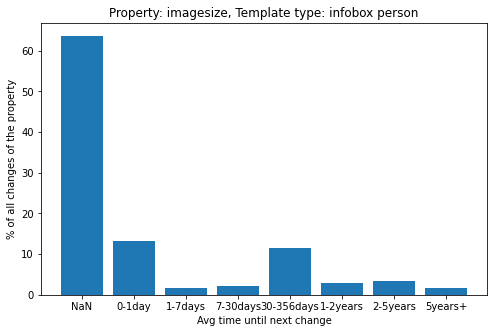

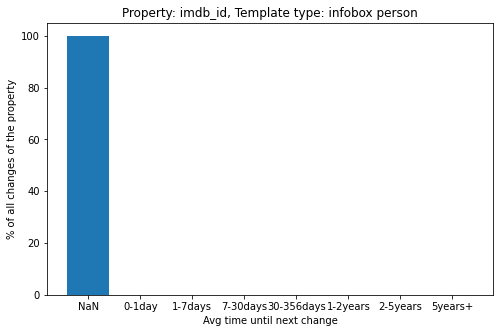

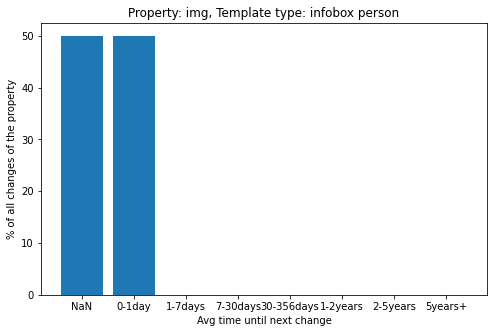

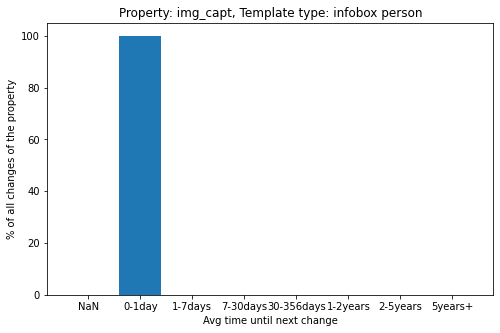

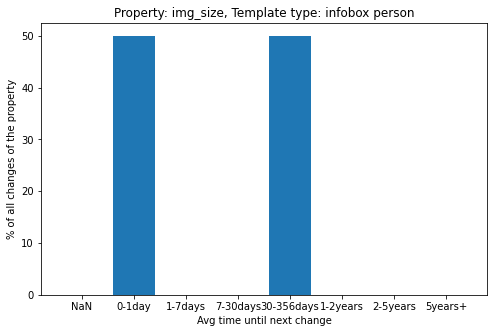

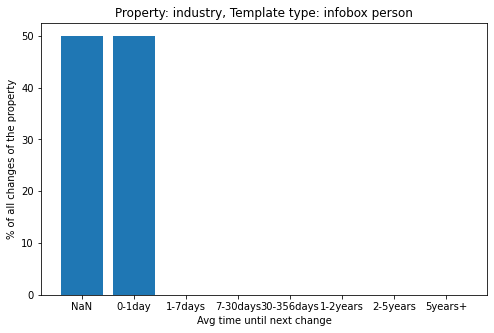

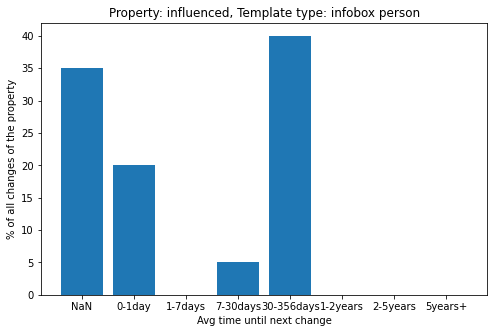

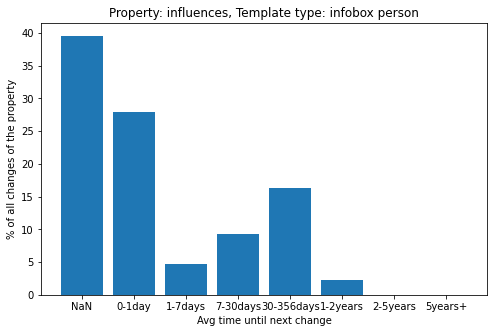

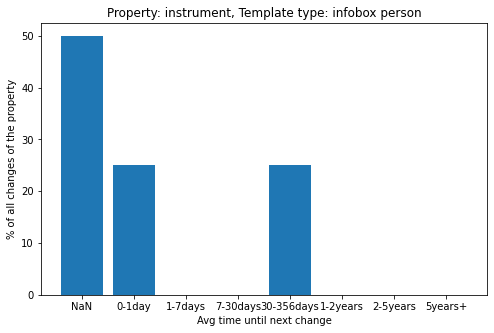

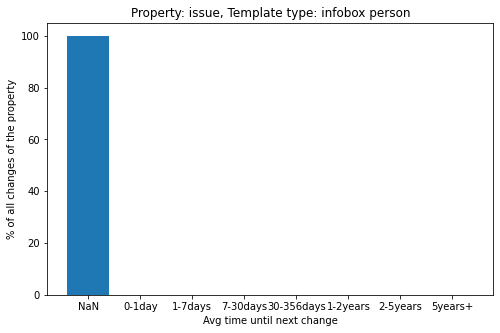

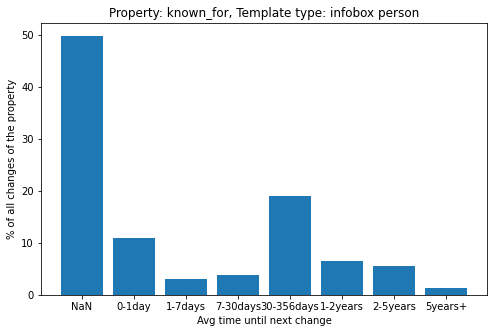

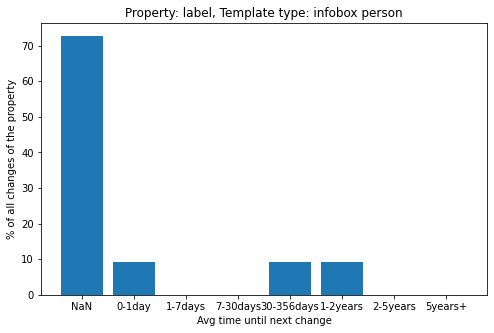

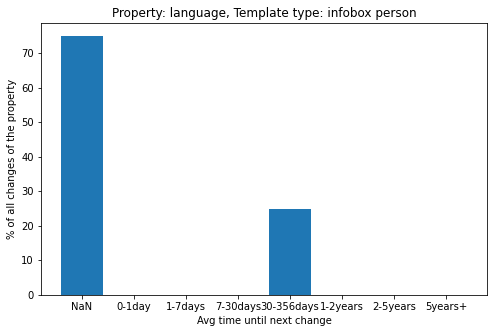

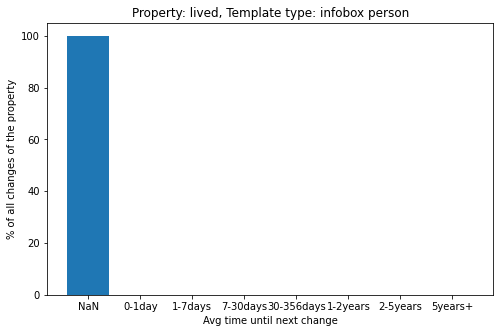

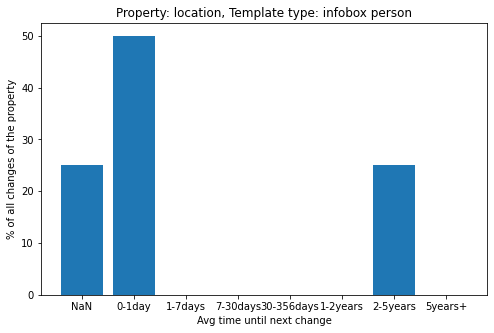

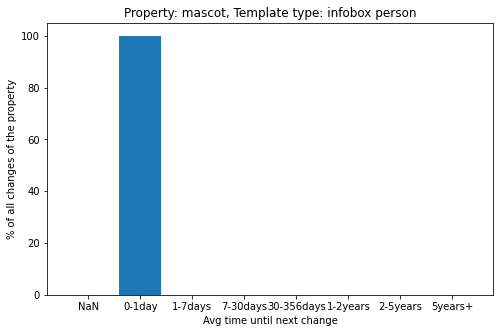

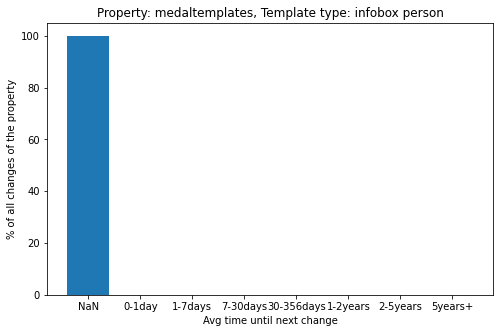

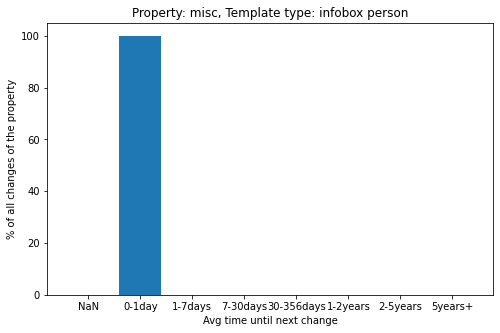

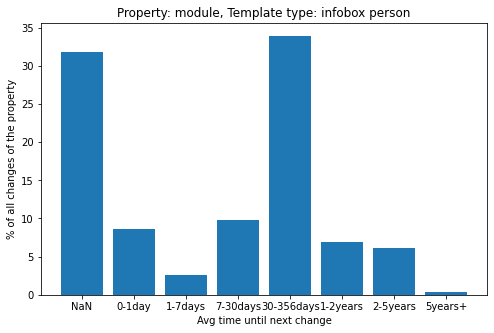

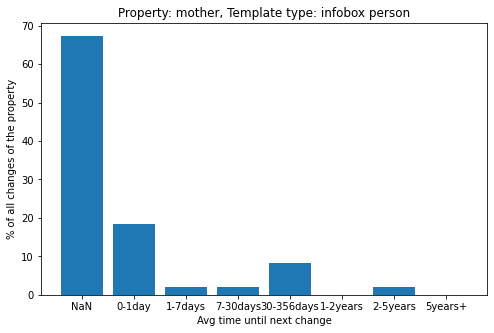

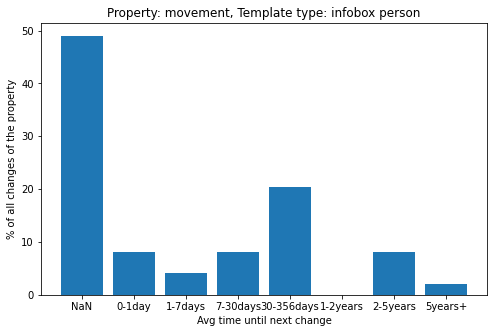

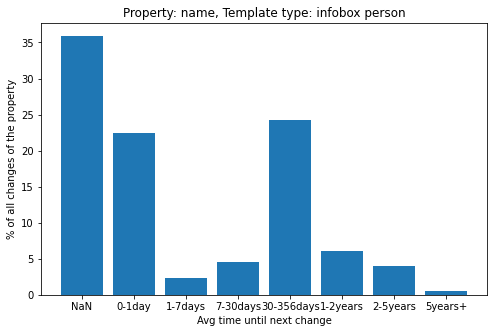

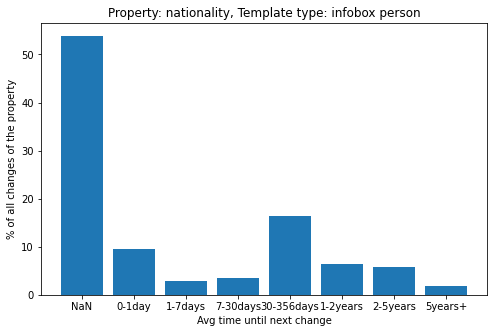

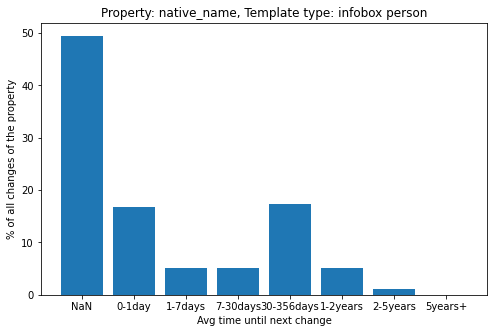

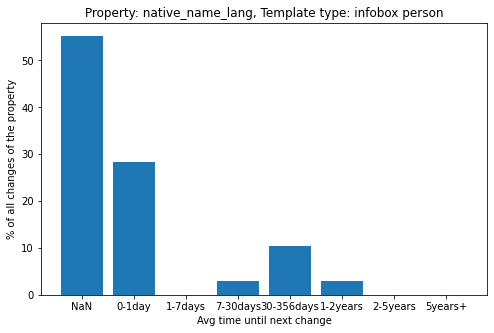

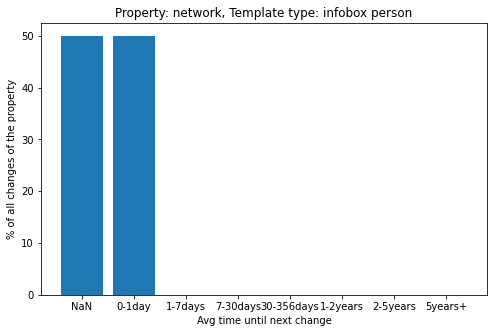

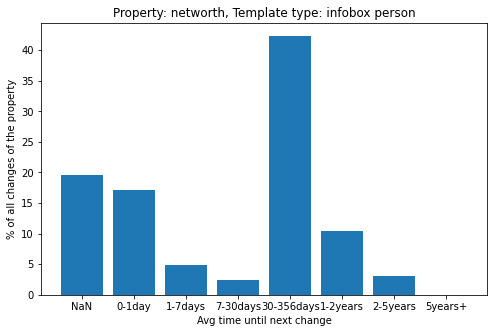

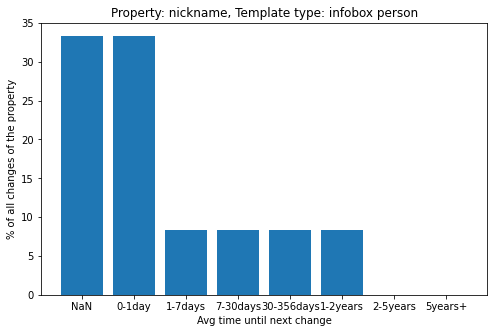

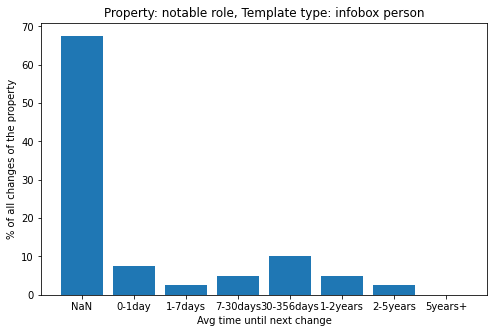

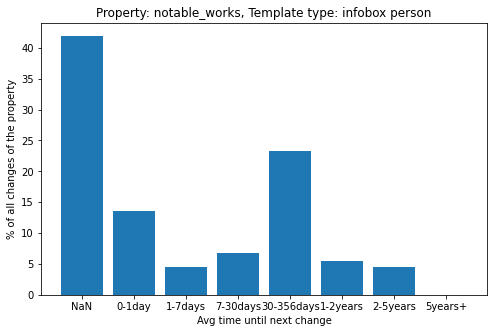

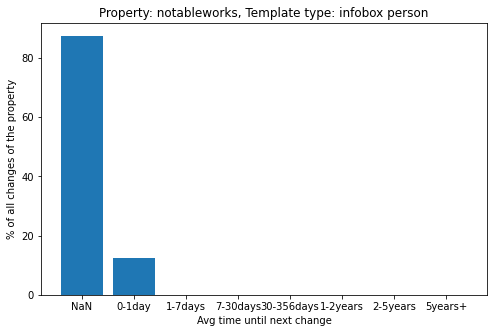

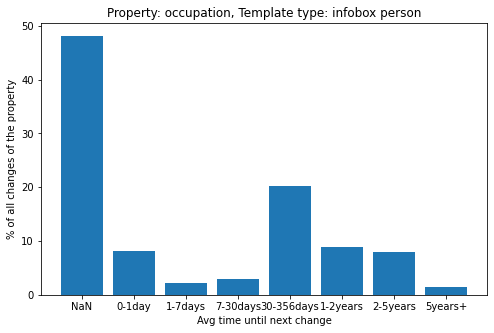

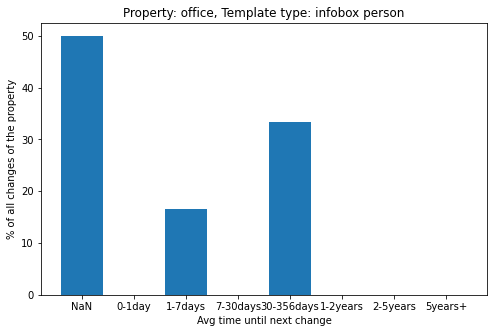

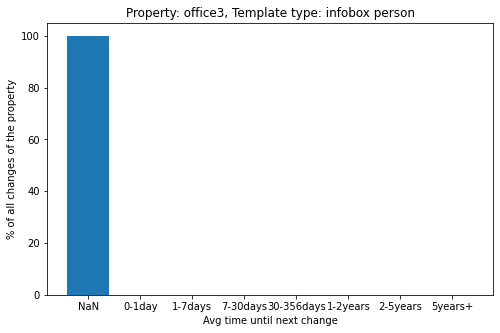

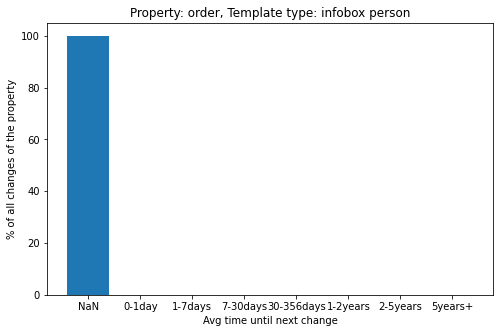

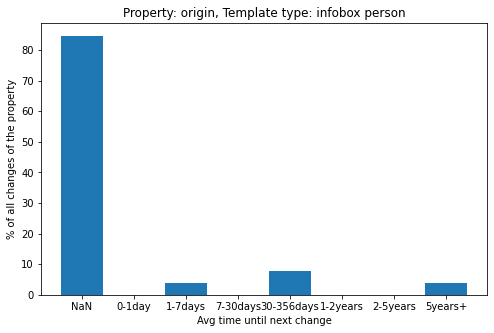

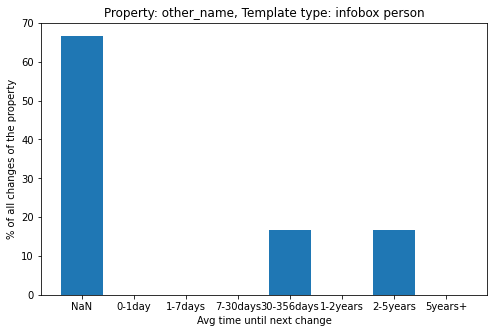

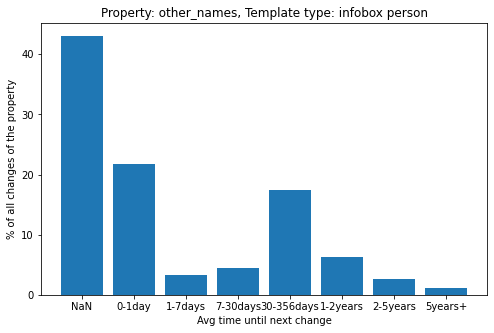

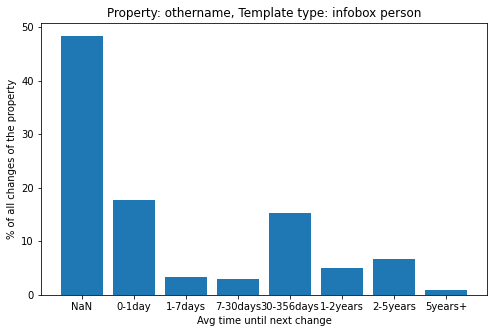

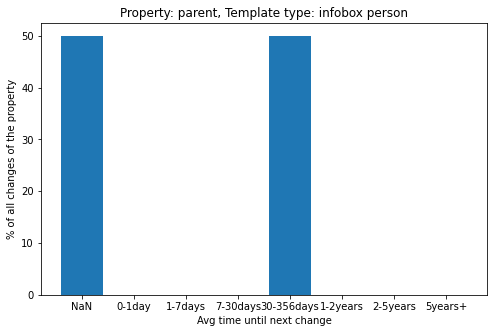

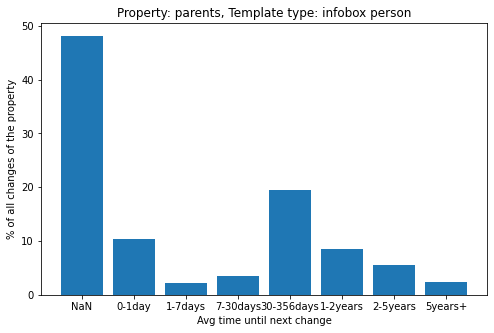

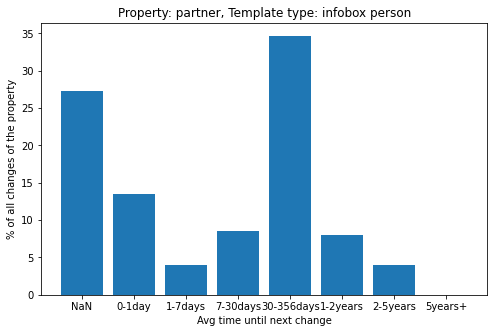

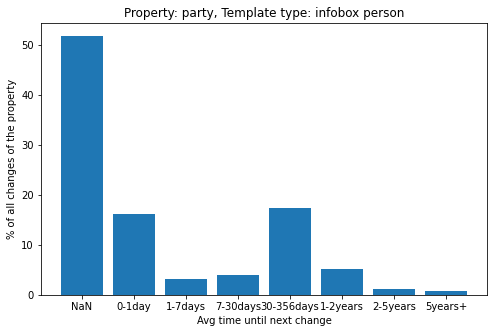

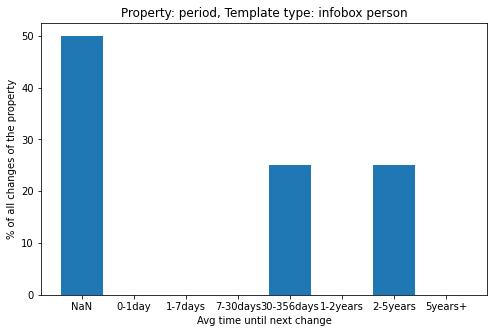

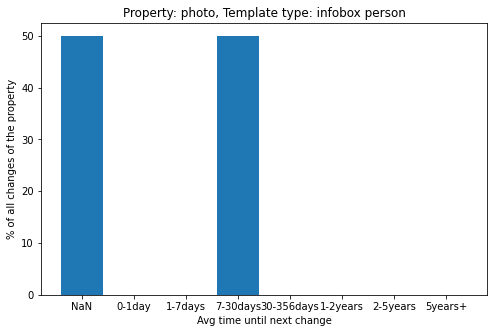

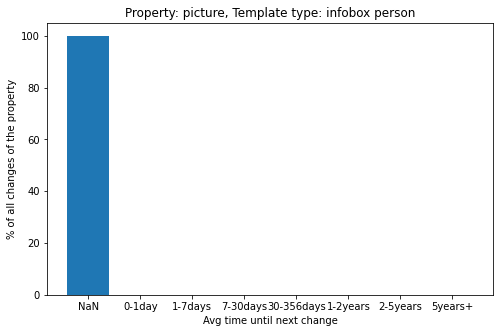

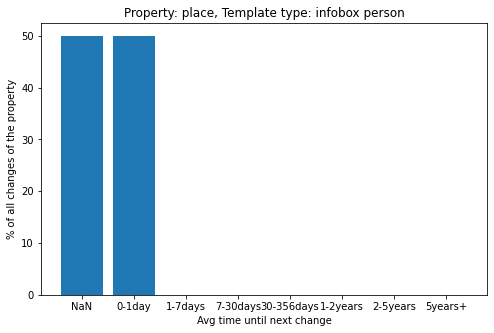

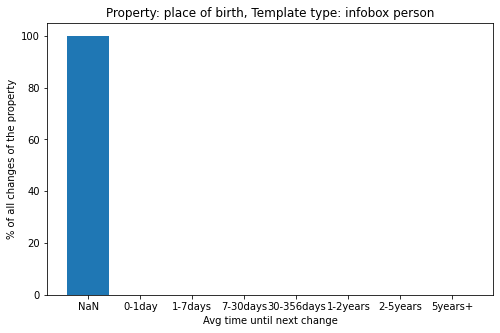

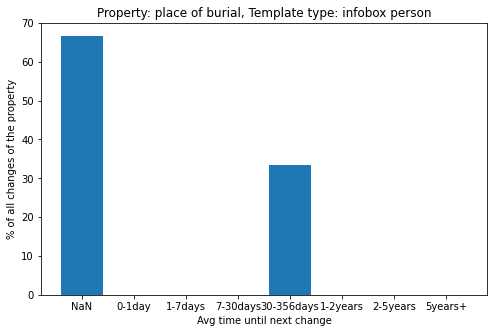

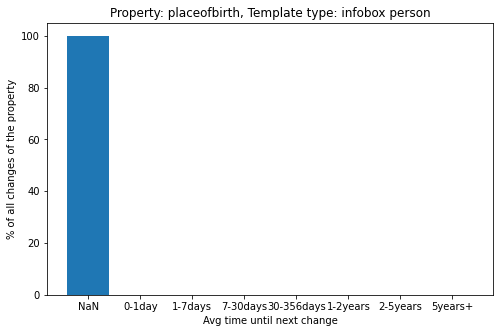

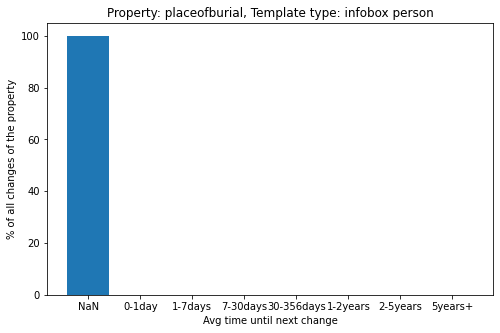

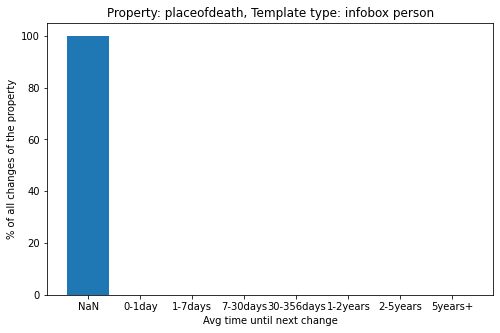

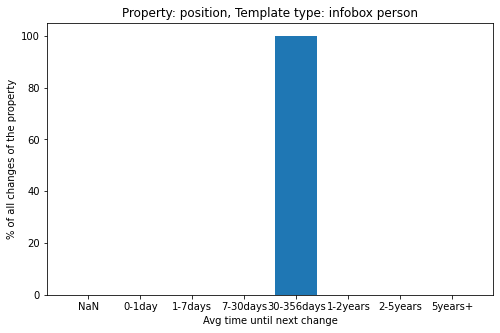

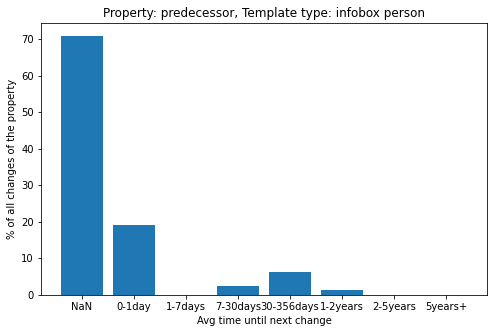

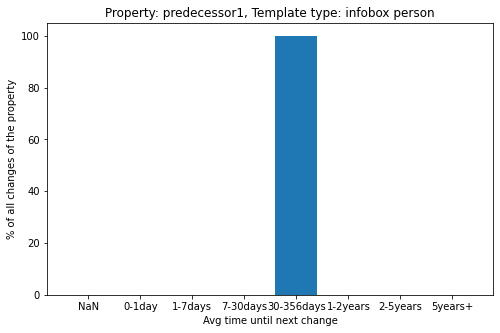

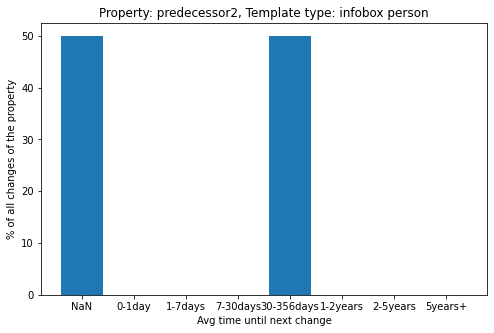

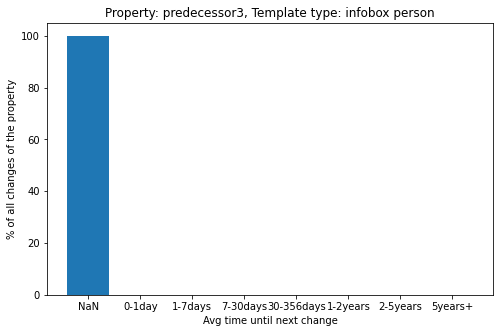

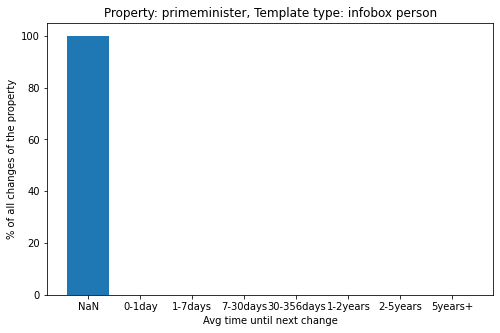

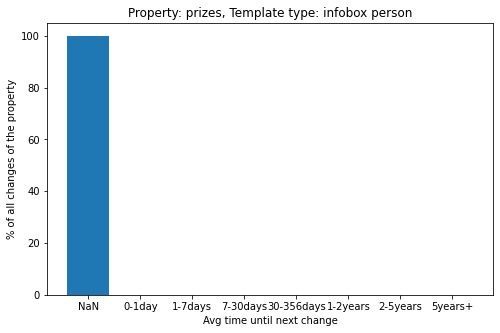

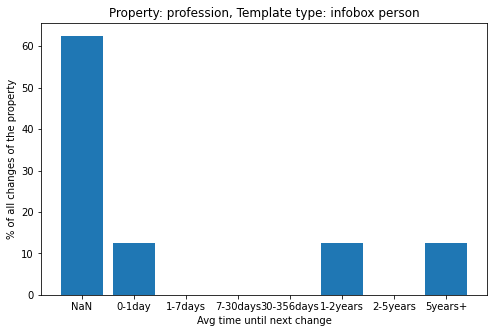

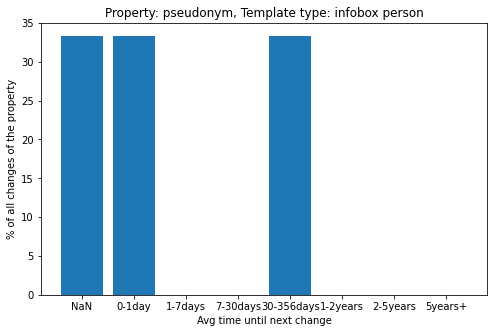

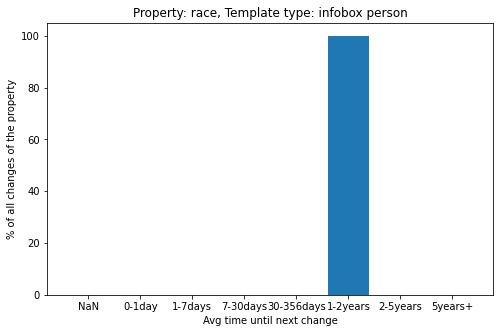

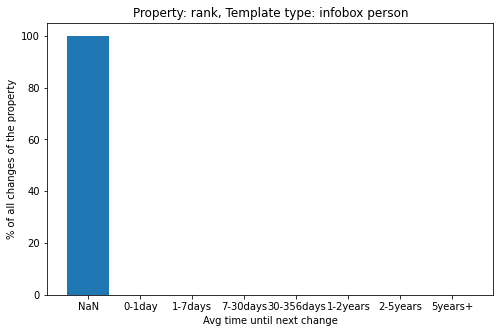

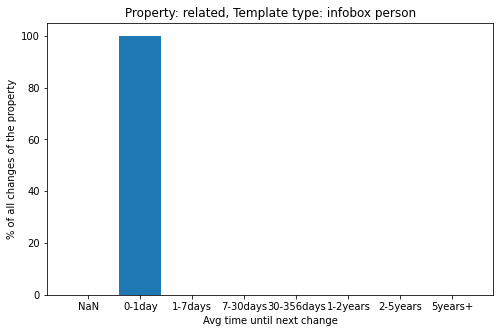

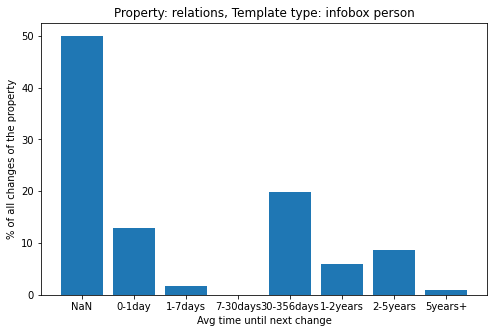

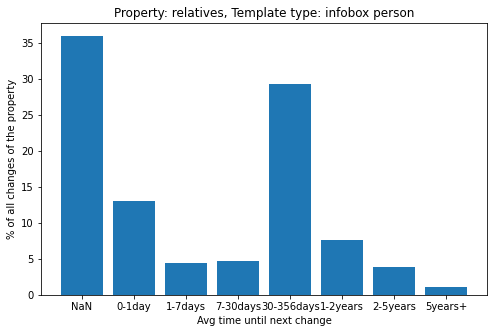

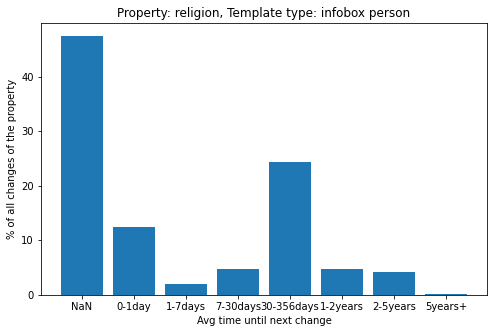

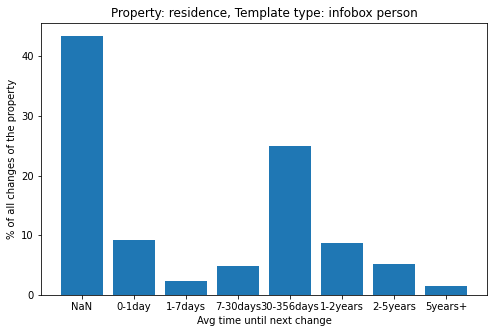

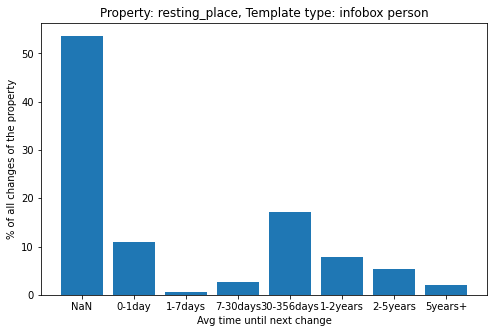

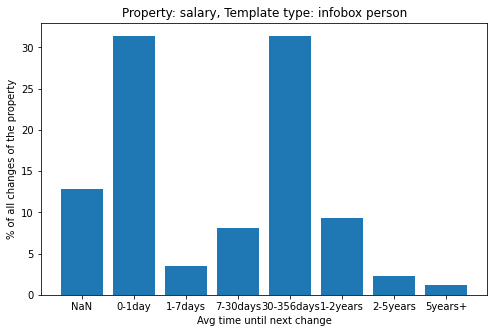

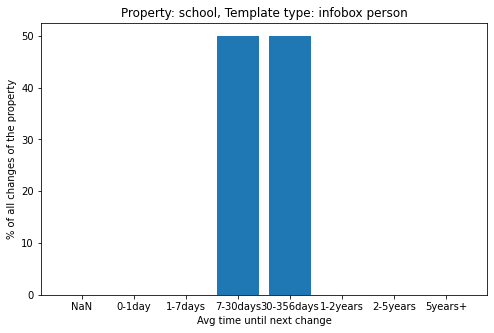

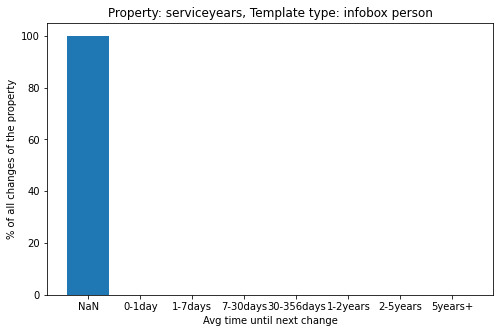

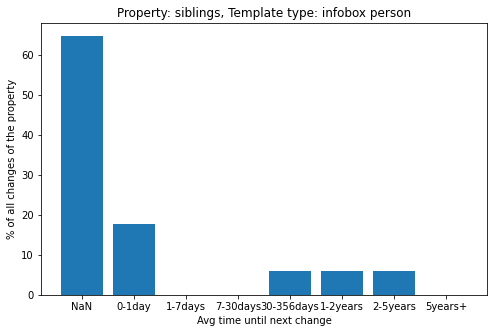

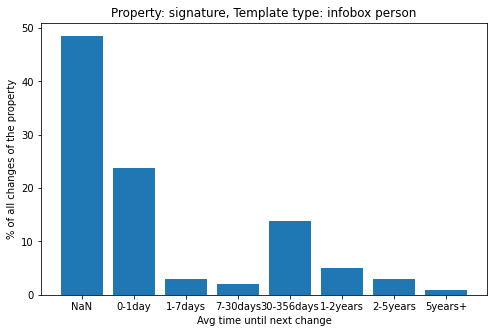

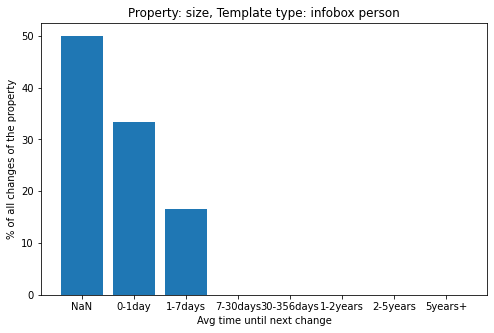

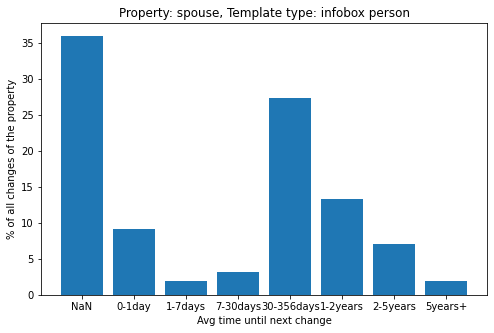

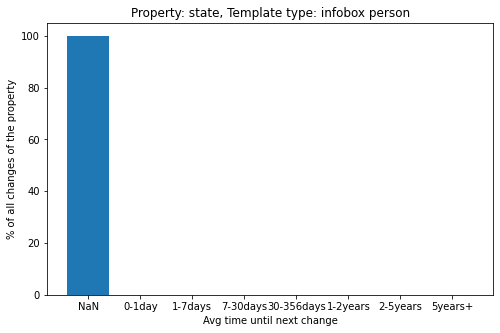

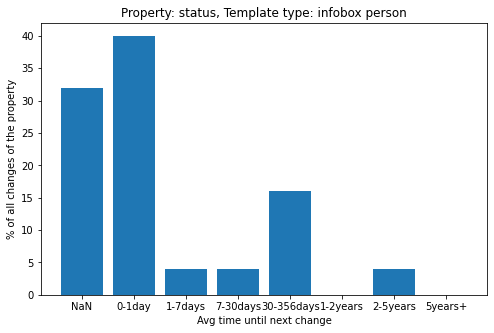

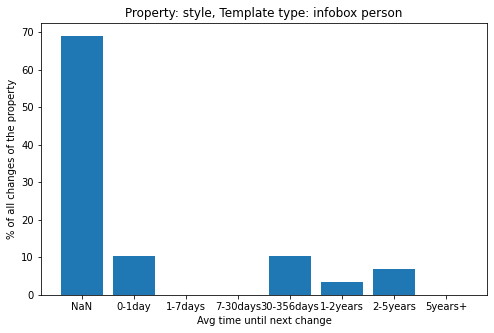

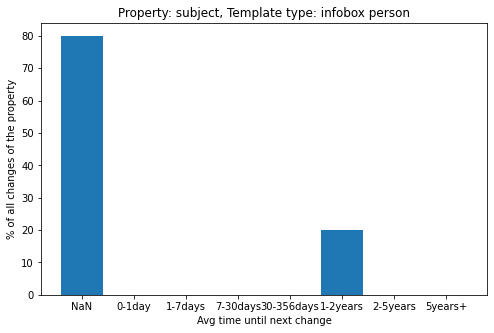

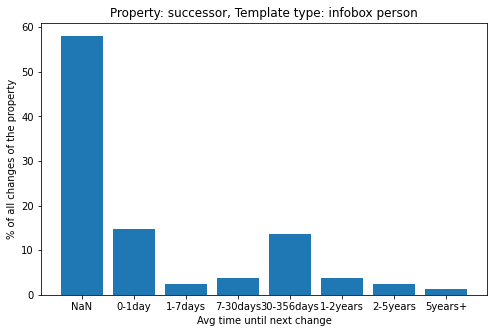

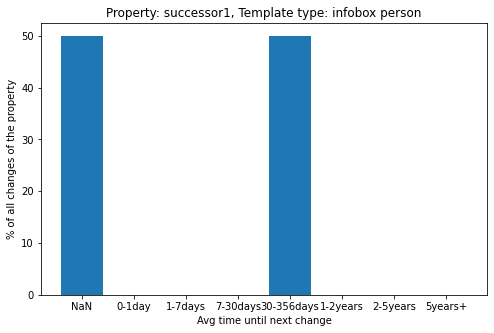

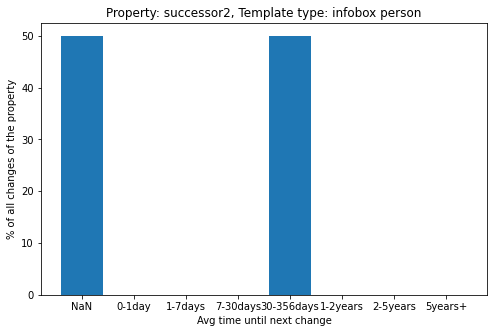

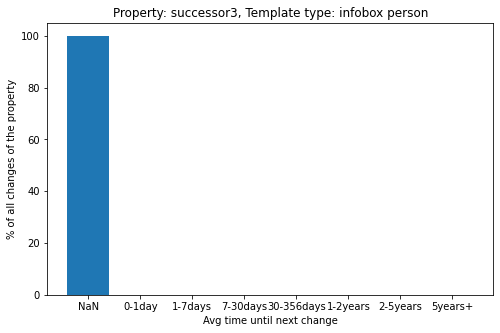

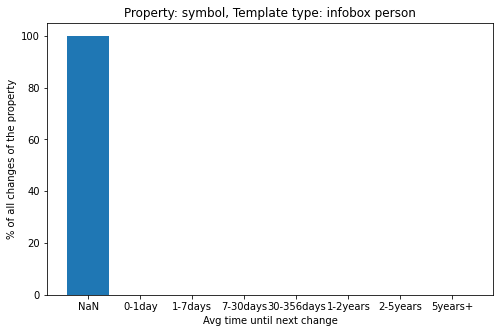

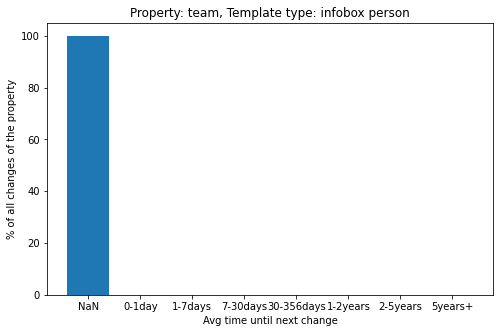

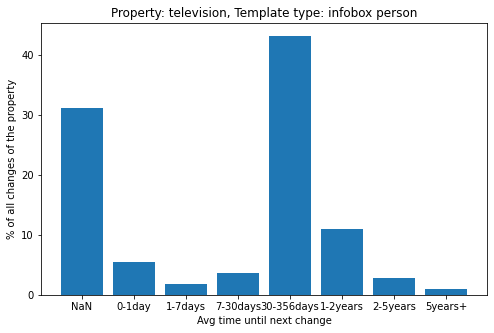

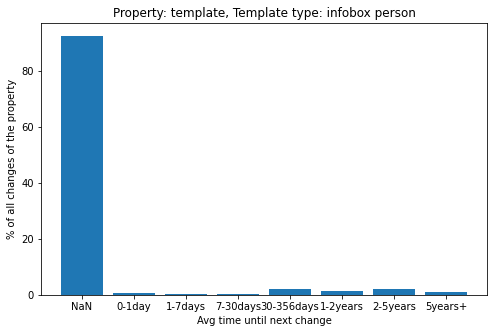

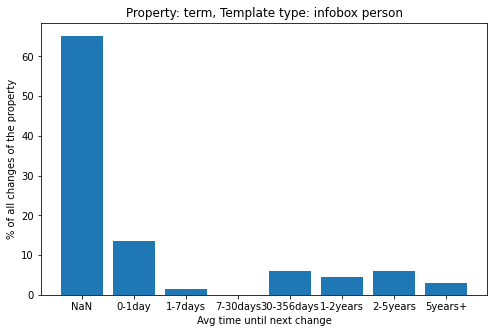

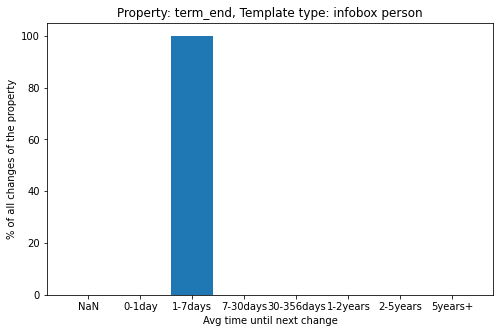

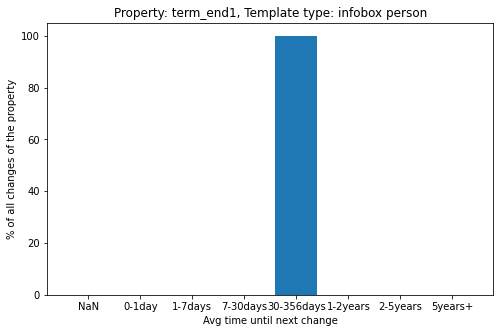

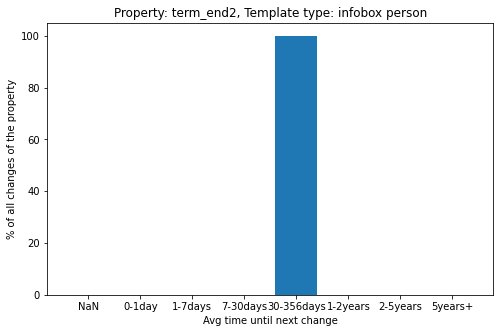

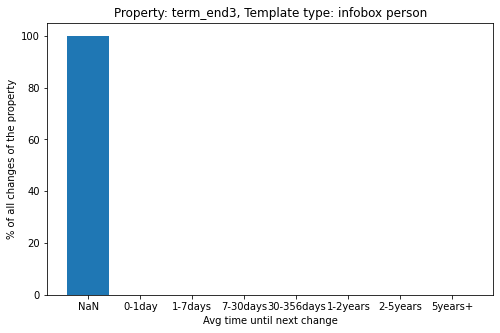

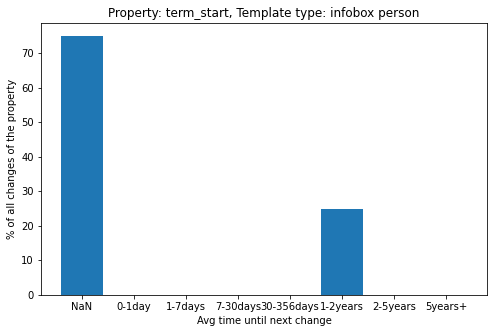

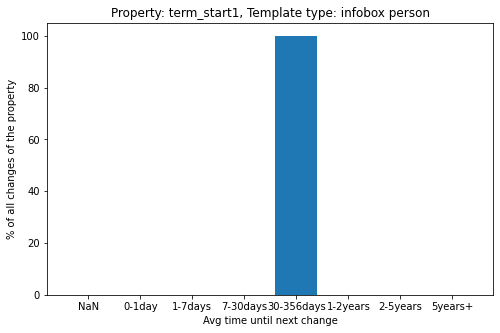

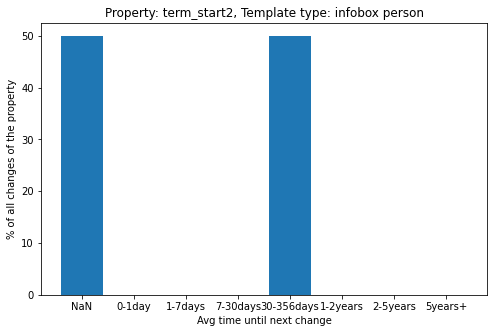

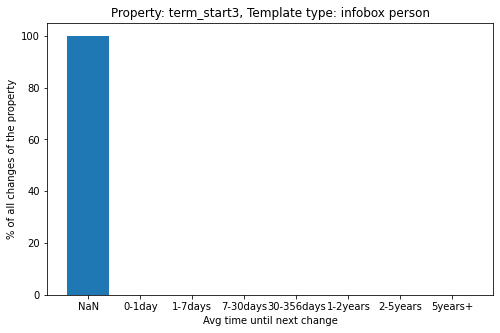

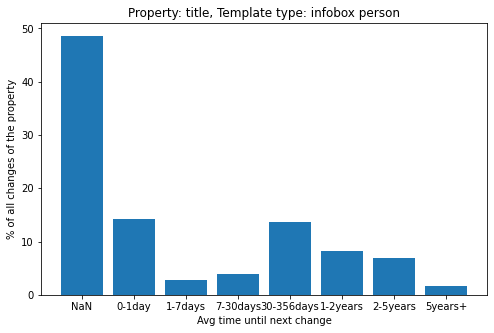

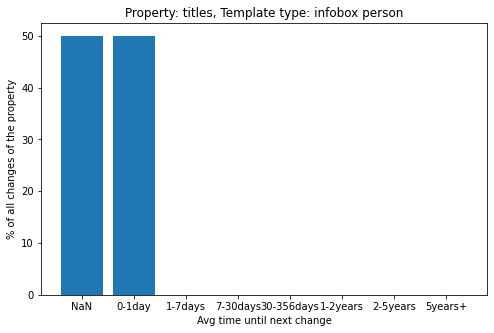

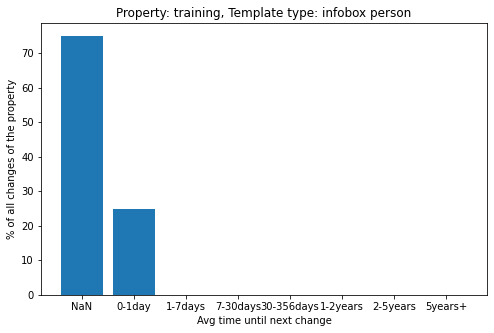

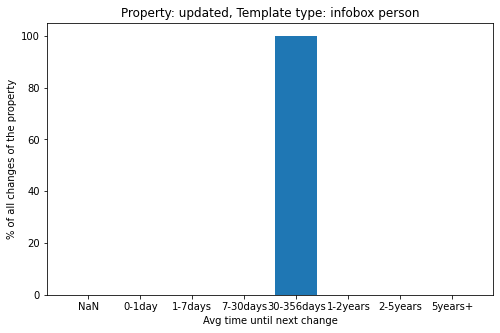

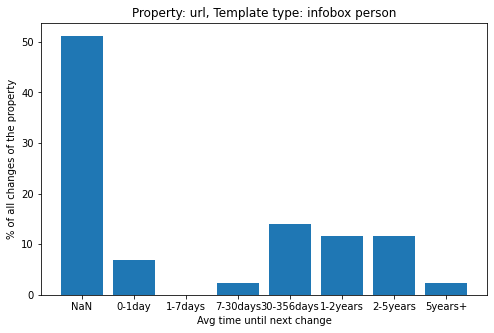

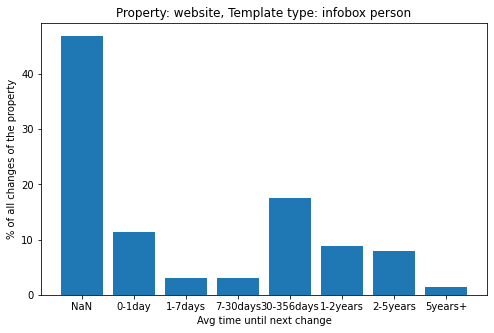

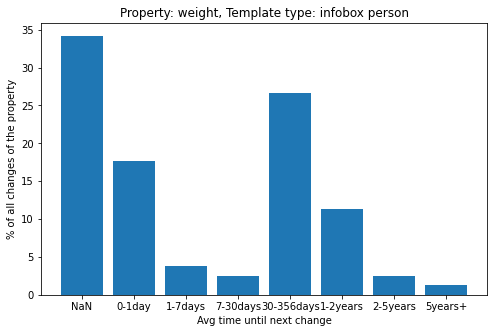

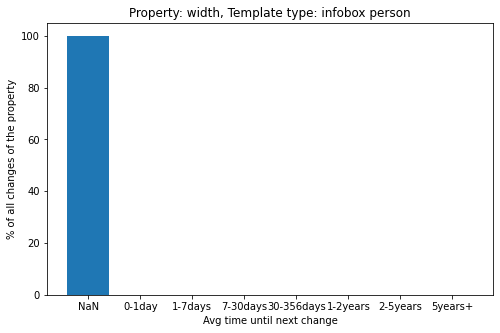

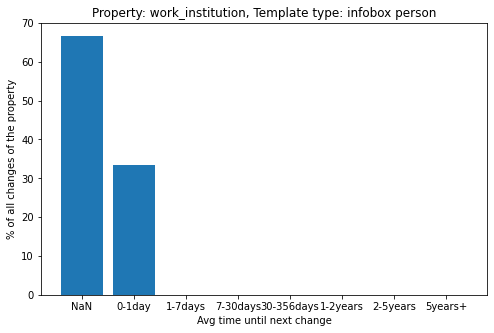

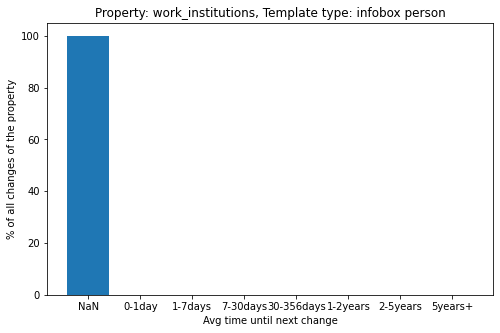

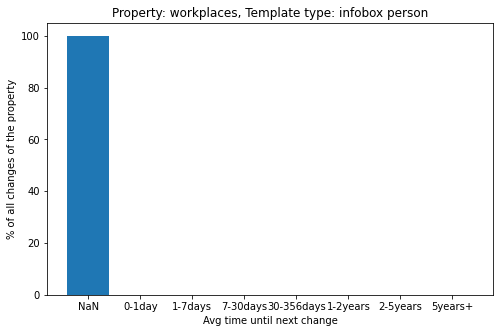

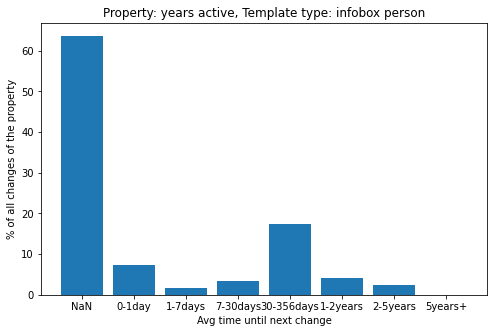

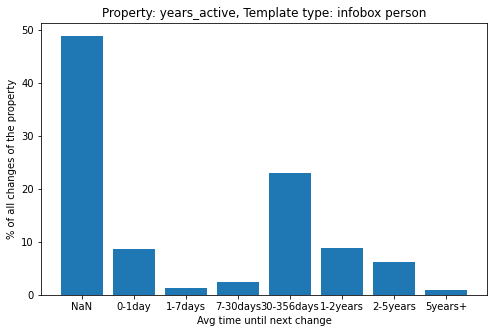

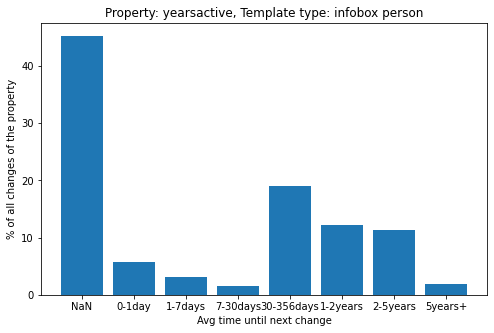

In [114]:
for prop in properties:
    plt.figure(figsize=(8,5))
    plt.bar(labels,\
            binned_counts.filter(items = [prop], axis=0).values[0])
    plt.title('Property: {}, Template type: infobox person'.format(prop))
    plt.ylabel('% of all changes of the property')
    plt.xlabel('Avg time until next change')
    plt.show()

## Investigate regularly changing properties

In [35]:
data[data['name']=='born']

key                             title  name  \
17227     166646306-0               Hope Williams Brady  born   
17228     166646306-0               Hope Williams Brady  born   
17263     166646306-0               Hope Williams Brady  born   
17295     166646306-0               Hope Williams Brady  born   
17384     166646306-0               Hope Williams Brady  born   
...               ...                               ...   ...   
22800707  368717948-0                         Omar Musa  born   
22800710  368717948-0                         Omar Musa  born   
22800711  368717948-0                         Omar Musa  born   
22803876  367292223-0                   Dylan Mattingly  born   
22807508  369373939-0  John Pott (British Army officer)  born   

                                             previous_value  \
17227                                                         
17228     [[December 24]], [[1974]]) (onscreen; SORASed ...   
17263                    Onscreen [[December 24]], [[1974]]   
17295                            Onscreen December 24, 1974   
17384     Onscreen January 10, 1974 (orginial)<br> Decem...   
...                                                     ...   
22800707  {{birth date|1984|1|09}} (age 25) <br /> [[Que...   
22800710  {{birth date|1984|1|09}} (age 25) <br /> [[Que...   
22800711  {{birth date and age|1984|1|09}}  <br /> [[Que...   
22803876                                   March 18th, 1991   
22807508                          {{Birth date|1919|07|14}}   

                                              current_value  \
17227     [[December 24]], [[1974]]) (onscreen; SORASed ...   
17228                    Onscreen [[December 24]], [[1974]]   
17263                            Onscreen December 24, 1974   
17295     Onscreen January 10, 1974 (orginial)<br> Decem...   
17384     Onscreen January 10, 1974 (original)<br> Decem...   
...                                                     ...   
22800707  {{birth date|1984|1|09}} (age 25) <br /> [[Que...   
22800710  {{birth date and age|1984|1|09}}  <br /> [[Que...   
22800711  {{birth date and age|df=yes|1984|1|09}}  <br /...   
22803876                                               1991   
22807508                   {{Birth date|1919|07|14|df=yes}}   

                         timestamp  
17227    2007-10-28 19:04:36+00:00  
17228    2007-10-29 12:48:03+00:00  
17263    2008-11-07 15:00:41+00:00  
17295    2009-06-19 17:13:53+00:00  
17384    2011-01-26 02:54:28+00:00  
...                            ...  
22800707 2010-10-08 05:08:37+00:00  
22800710 2011-03-14 10:28:31+00:00  
22800711 2011-07-22 02:55:05+00:00  
22803876 2010-06-11 20:57:37+00:00  
22807508 2010-06-22 11:33:22+00:00  

[11614 rows x 6 columns]

In [49]:
data[data['name']=='born']['key'].value_counts().value_counts()[:10]

1     990
2     538
3     275
4     186
5     118
6      84
7      73
8      55
9      29
10     25
Name: key, dtype: int64

Observation: Sometimes "born" refers to only the date of birth, but sometimes it includes the age of the person which needs to be updated regularly.
Apparently "Born" is  not a basic parameter and normally refers to a section of "birth_date", "birth_name", "birth_place

In [63]:
data[data['name']=='birth_name']['key'].value_counts().value_counts()[:10

1     2509
2     1192
3      460
4      352
5      188
6      145
8       98
7       92
9       52
11      49
Name: key, dtype: int64

"Birth name" seems to be less prone to many changes, as it should be unambigous and stay the same, however there is a long tail to the frequency distribution.

In [60]:
data[data['name']=='birth_date']['key'].value_counts().value_counts()[:10]

1     19682
2      7781
3      3725
4      2001
5      1189
6       764
7       533
8       338
9       300
10      272
Name: key, dtype: int64

In [63]:
data[data['name']=='birth_place']['key'].value_counts().value_counts()[:10]

1     20377
2      8006
3      3856
4      2117
5      1223
6       796
7       539
8       374
9       301
10      234
Name: key, dtype: int64

"Birth date" and "birth place" are quite stable but again have a very long tails.

In [7]:
g = data[data['name']==property_name].groupby(['key','name'])

NameError: name 'property_name' is not defined

Sort values after group by

In [ ]:
g.apply(lambda x: x['timestamp'].sort_values(ascending=True))

In [ ]:
avg_time_diff_pop = g.apply(lambda x: x['timestamp'].diff().mean())

In [35]:
avg_time_diff_pop

key          name      
100142209-0  population      405 days 18:07:38.200000
10026100-0   population             623 days 13:18:18
10026107-0   population             935 days 07:54:47
10026111-0   population             935 days 07:51:57
10026118-0   population   623 days 04:19:05.666666664
                                      ...            
98770238-0   population      208 days 09:25:00.100000
99099388-0   population            1364 days 19:09:51
9936565-0    population             693 days 20:15:25
99635527-0   population            3020 days 23:51:09
99872403-0   population                           NaT
Length: 8281, dtype: timedelta64[ns]

In [38]:
deltas = pd.cut(avg_time_diff_pop, bins, labels = labels)

<AxesSubplot:>

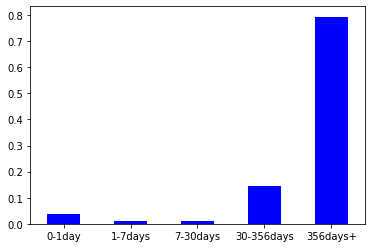

In [52]:
deltas.value_counts(normalize=True, sort=False).plot.bar(rot=0, color="b", figsize=(6,4), title='Property: {}'.format(property_name))

In [82]:
g = data[data['name']=='population'].groupby(['key','name','template'])#['timestamp'].diff().mean()
avg_time_diff = g.apply(lambda x: x['timestamp'].sort_values().diff().mean()).reset_index()
avg_time_diff.rename(columns={0:'avgChangeFrequ'},inplace=True)
avg_time_diff['avgBinnedChangeFrequ'] = pd.cut(avg_time_diff['avgChangeFrequ'].fillna(pd.Timedelta(minutes = -1)), bins, labels = labels, include_lowest=True)

binned_counts = avg_time_diff.groupby(['template','avgBinnedChangeFrequ']).size().unstack(fill_value=0)

In [76]:
binned_counts

avgBinnedChangeFrequ                                NaN  0-1day  1-7days  \
template                                                                   
infobox algerian municipality                         0       1        0   
infobox amphoe                                       18       0        0   
infobox anglican church                               1       0        0   
infobox anglican church‎                              1       0        0   
infobox asturian municipality                         1       0        0   
...                                                 ...     ...      ...   
infobox_warsaw                                        0       0        0   
pakistan district infobox                             1       0        0   
subst:infobox province vietname/sandbox               1       0        0   
template:infobox region of italy                      2       0        0   
user:piccolo modificatore laborioso/template:in...    1       0        0   

avgBinnedChangeFrequ                                7-30days  30-356days  \
template                                                                   
infobox algerian municipality                              0           0   
infobox amphoe                                             0           1   
infobox anglican church                                    0           1   
infobox anglican church‎                                   0           0   
infobox asturian municipality                              0           0   
...                                                      ...         ...   
infobox_warsaw                                             0           1   
pakistan district infobox                                  0           0   
subst:infobox province vietname/sandbox                    0           0   
template:infobox region of italy                           1           3   
user:piccolo modificatore laborioso/template:in...         0           0   

avgBinnedChangeFrequ                                1-2years  2-5years  \
template                                                                 
infobox algerian municipality                              0         0   
infobox amphoe                                             0         1   
infobox anglican church                                    0         0   
infobox anglican church‎                                   0         0   
infobox asturian municipality                              0         0   
...                                                      ...       ...   
infobox_warsaw                                             0         0   
pakistan district infobox                                  0         0   
subst:infobox province vietname/sandbox                    0         0   
template:infobox region of italy                           0         0   
user:piccolo modificatore laborioso/template:in...         0         0   

avgBinnedChangeFrequ                                5years+  
template                                                     
infobox algerian municipality                             0  
infobox amphoe                                            0  
infobox anglican church                                   0  
infobox anglican church‎                                  0  
infobox asturian municipality                             0  
...                                                     ...  
infobox_warsaw                                            0  
pakistan district infobox                                 0  
subst:infobox province vietname/sandbox                   0  
template:infobox region of italy                          0  
user:piccolo modificatore laborioso/template:in...        0  

[174 rows x 8 columns]

In [78]:
binned_counts = binned_counts.div(binned_counts.sum(axis=1), axis=0).mul(100)

In [79]:
binned_counts

avgBinnedChangeFrequ                                       NaN  0-1day  \
template                                                                 
infobox algerian municipality                         0.000000   100.0   
infobox amphoe                                       90.000000     0.0   
infobox anglican church                              50.000000     0.0   
infobox anglican church‎                            100.000000     0.0   
infobox asturian municipality                       100.000000     0.0   
...                                                        ...     ...   
infobox_warsaw                                        0.000000     0.0   
pakistan district infobox                           100.000000     0.0   
subst:infobox province vietname/sandbox             100.000000     0.0   
template:infobox region of italy                     33.333333     0.0   
user:piccolo modificatore laborioso/template:in...  100.000000     0.0   

avgBinnedChangeFrequ                                1-7days   7-30days  \
template                                                                 
infobox algerian municipality                           0.0   0.000000   
infobox amphoe                                          0.0   0.000000   
infobox anglican church                                 0.0   0.000000   
infobox anglican church‎                                0.0   0.000000   
infobox asturian municipality                           0.0   0.000000   
...                                                     ...        ...   
infobox_warsaw                                          0.0   0.000000   
pakistan district infobox                               0.0   0.000000   
subst:infobox province vietname/sandbox                 0.0   0.000000   
template:infobox region of italy                        0.0  16.666667   
user:piccolo modificatore laborioso/template:in...      0.0   0.000000   

avgBinnedChangeFrequ                                30-356days  1-2years  \
template                                                                   
infobox algerian municipality                              0.0       0.0   
infobox amphoe                                             5.0       0.0   
infobox anglican church                                   50.0       0.0   
infobox anglican church‎                                   0.0       0.0   
infobox asturian municipality                              0.0       0.0   
...                                                        ...       ...   
infobox_warsaw                                           100.0       0.0   
pakistan district infobox                                  0.0       0.0   
subst:infobox province vietname/sandbox                    0.0       0.0   
template:infobox region of italy                          50.0       0.0   
user:piccolo modificatore laborioso/template:in...         0.0       0.0   

avgBinnedChangeFrequ                                2-5years  5years+  
template                                                               
infobox algerian municipality                            0.0      0.0  
infobox amphoe                                           5.0      0.0  
infobox anglican church                                  0.0      0.0  
infobox anglican church‎                                 0.0      0.0  
infobox asturian municipality                            0.0      0.0  
...                                                      ...      ...  
infobox_warsaw                                           0.0      0.0  
pakistan district infobox                                0.0      0.0  
subst:infobox province vietname/sandbox                  0.0      0.0  
template:infobox region of italy                         0.0      0.0  
user:piccolo modificatore laborioso/template:in...       0.0      0.0  

[174 rows x 8 columns]

In [80]:
template_types=binned_counts.index

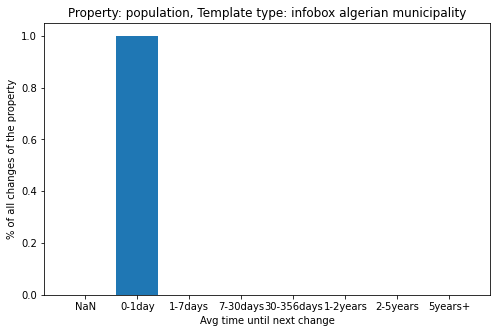

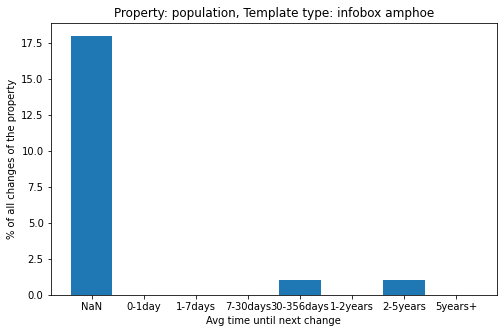

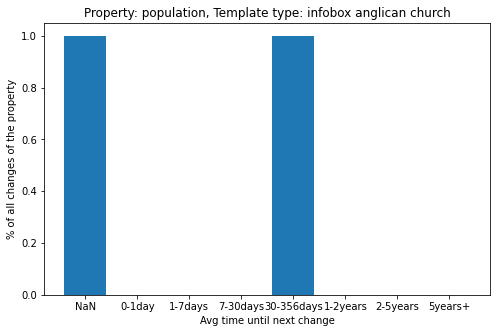

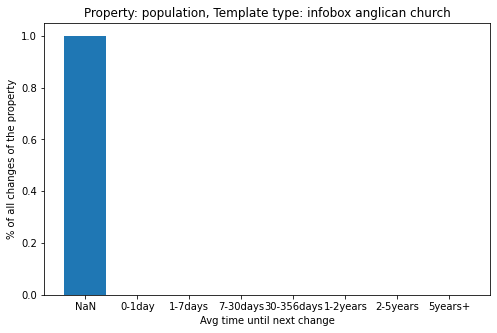

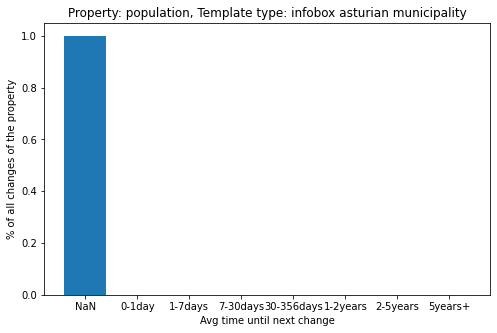

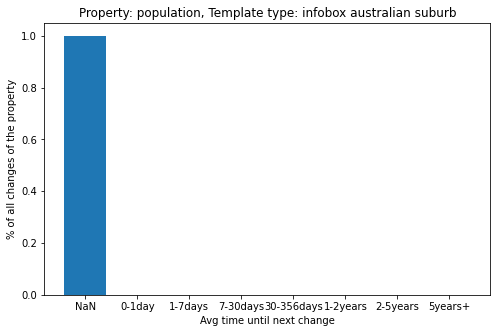

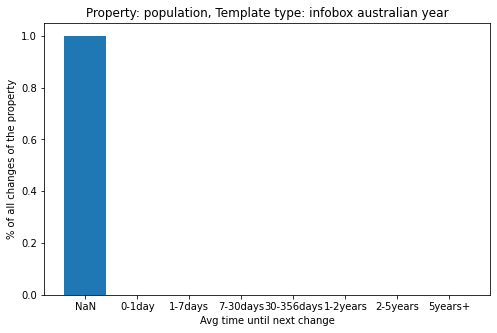

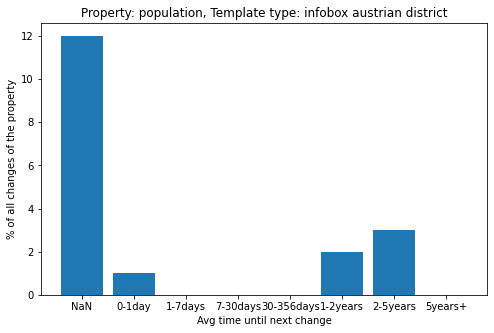

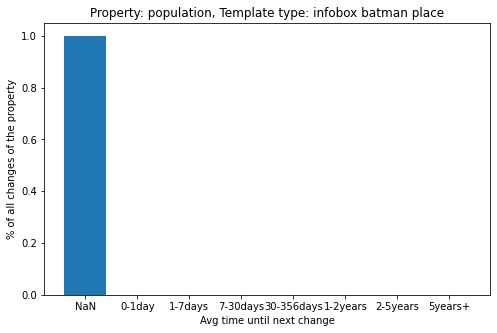

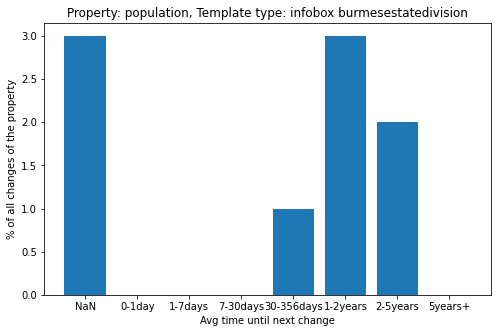

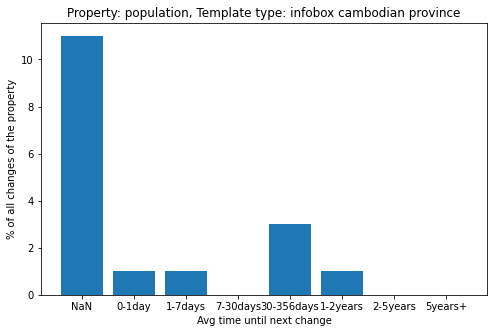

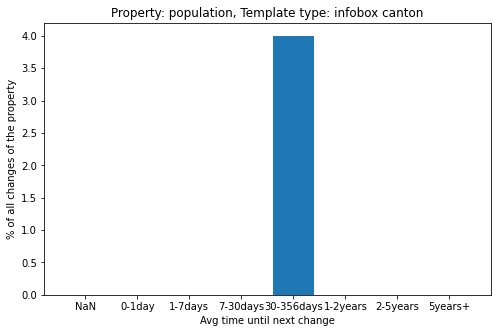

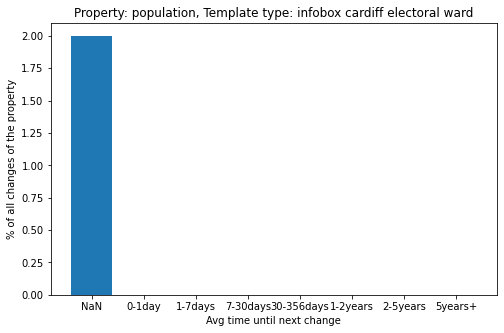

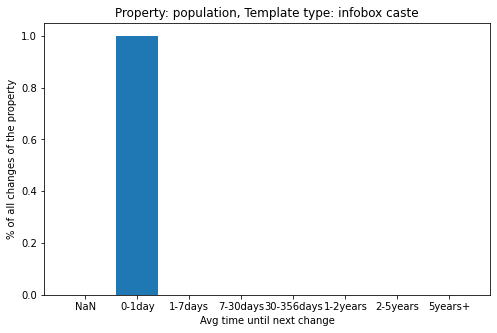

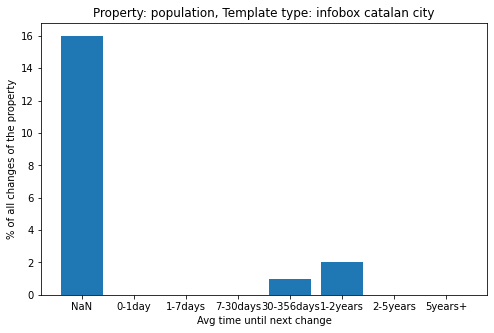

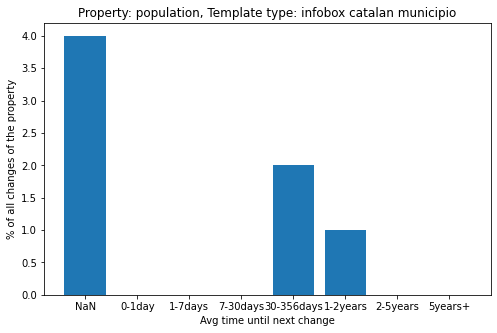

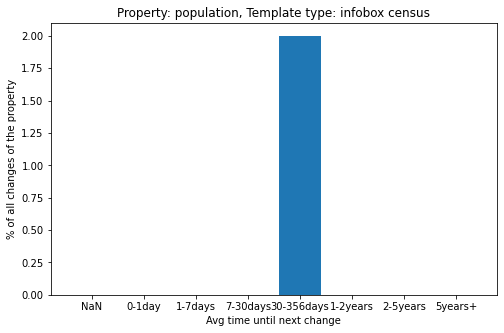

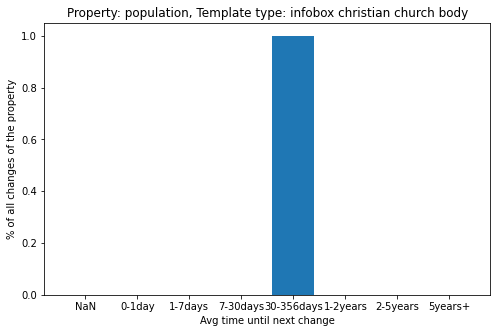

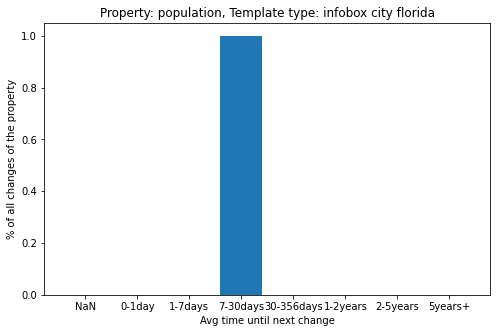

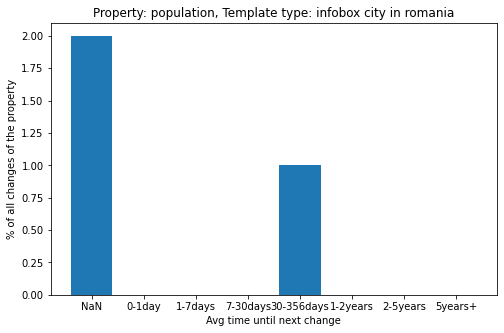

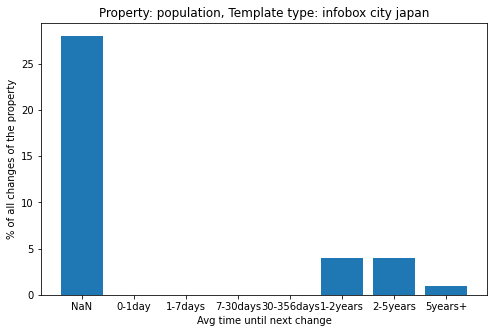

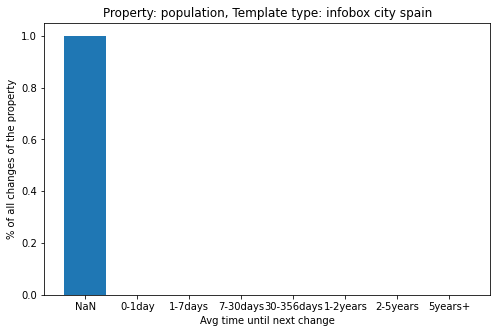

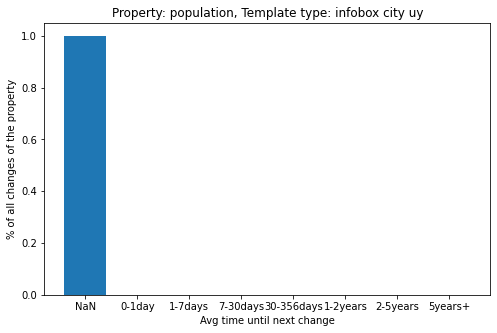

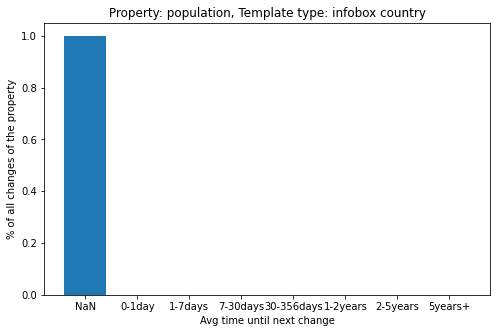

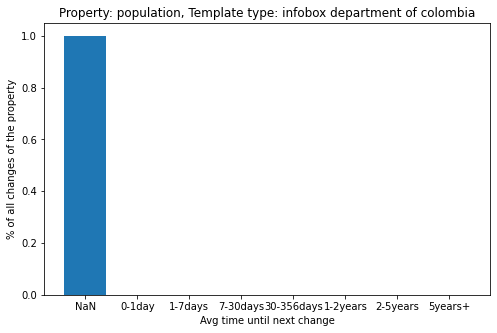

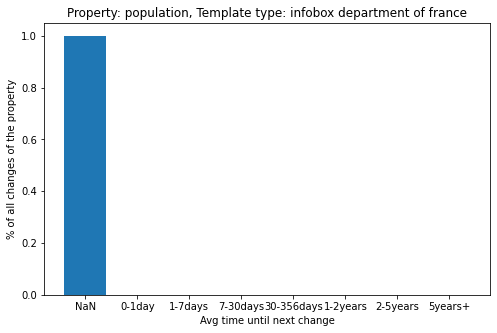

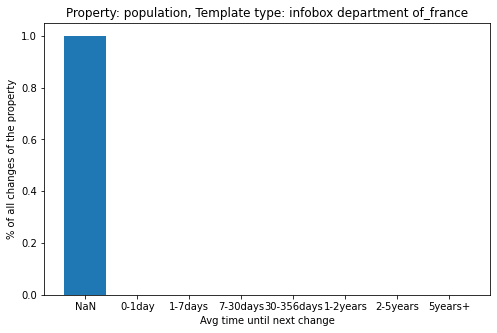

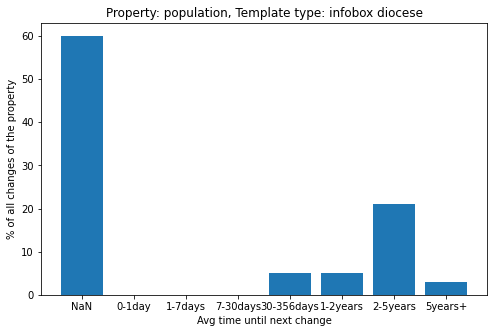

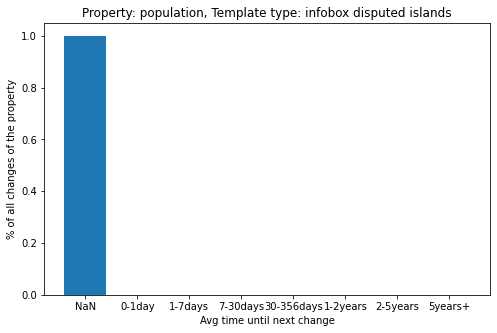

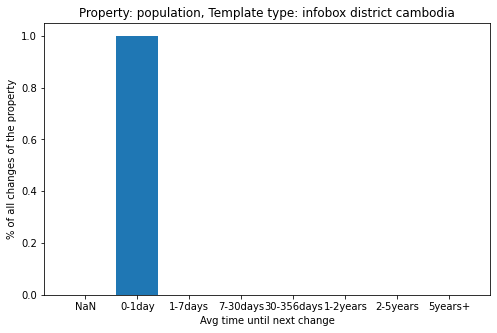

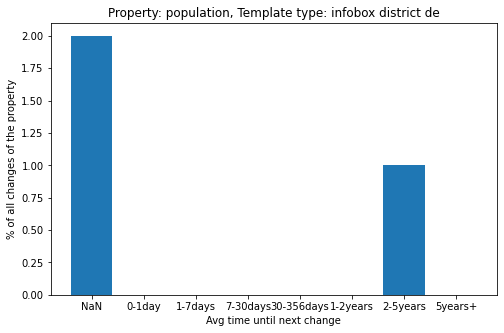

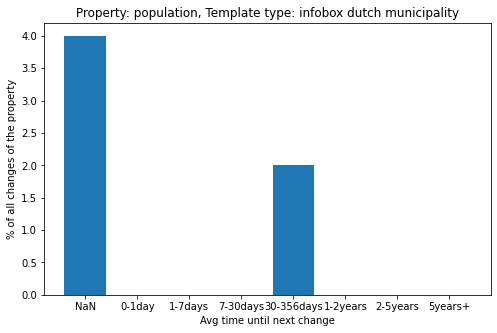

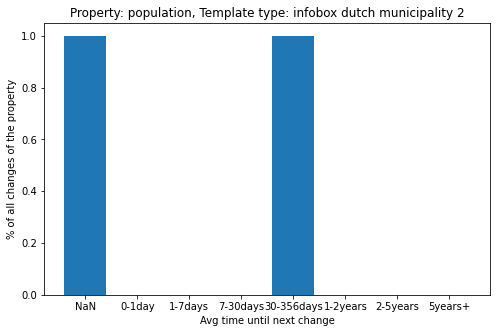

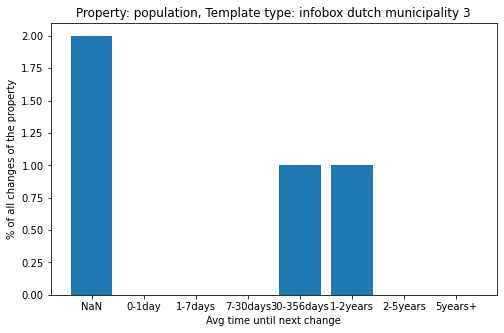

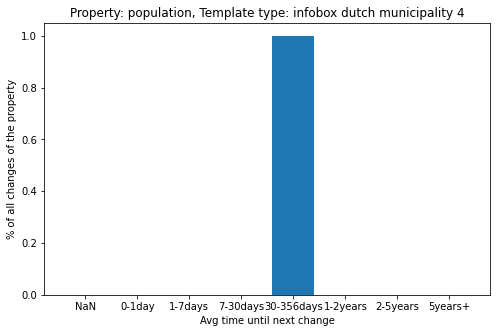

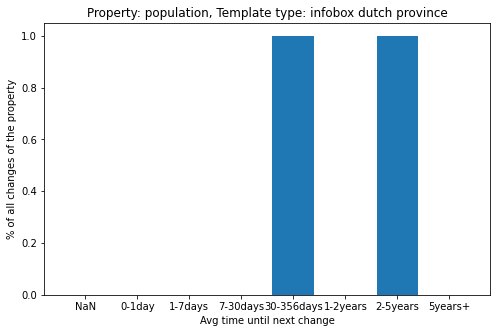

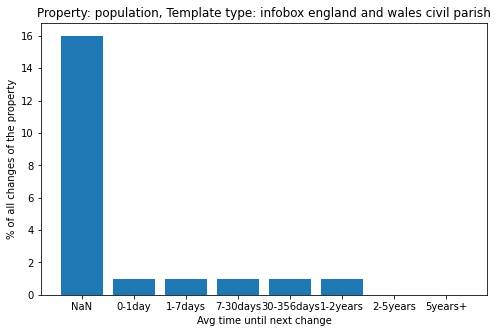

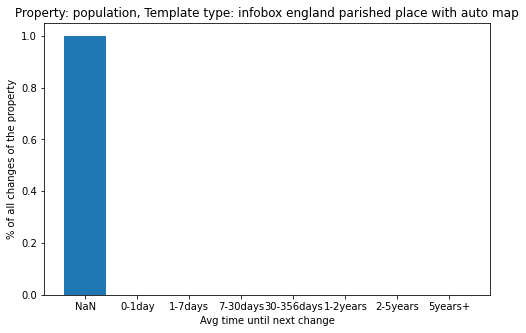

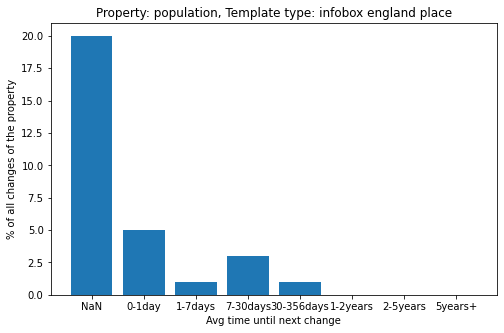

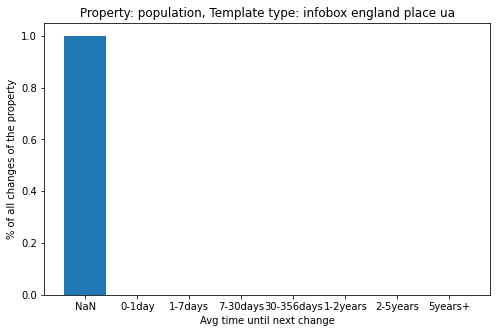

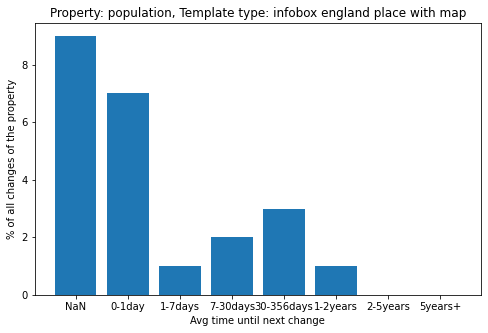

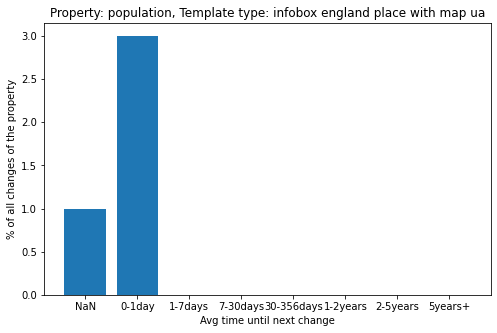

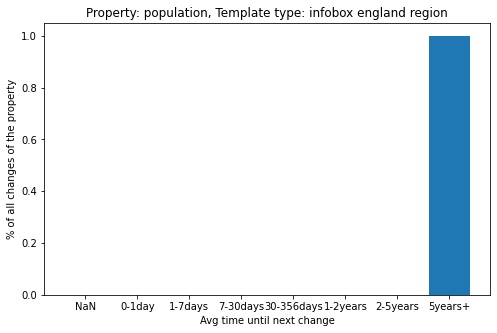

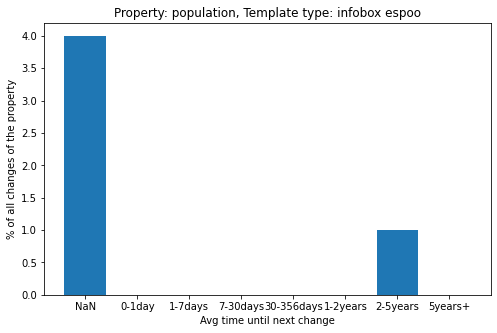

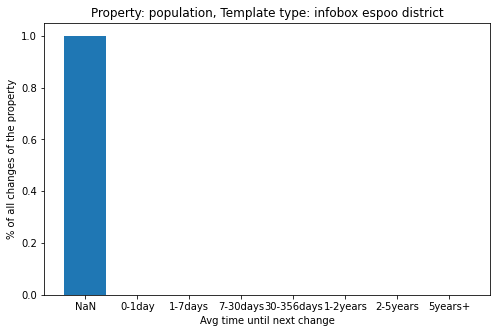

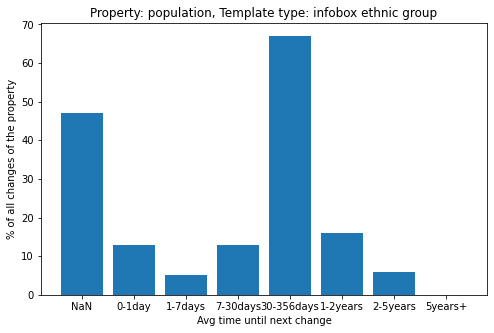

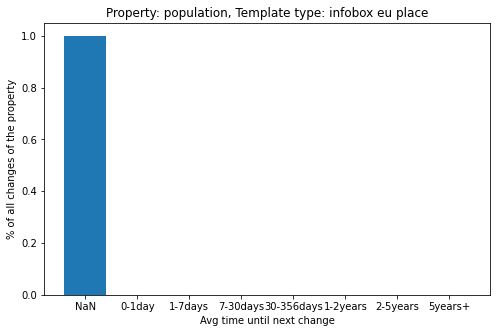

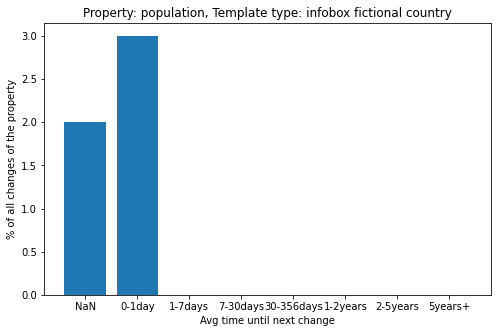

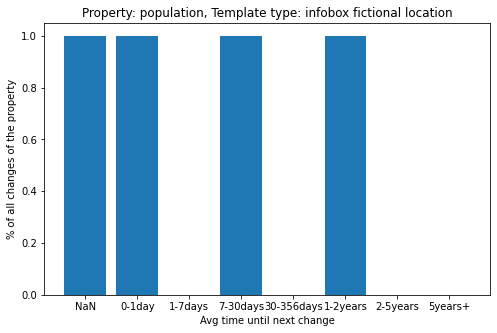

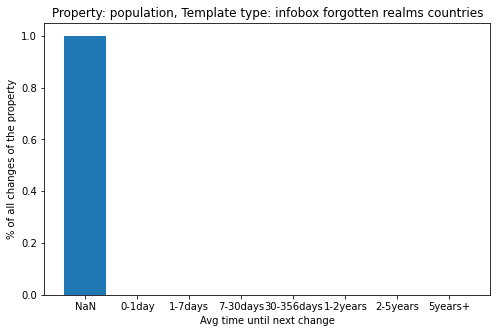

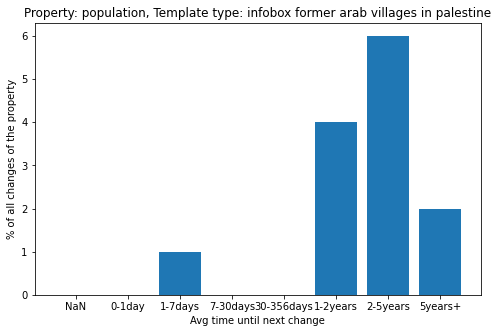

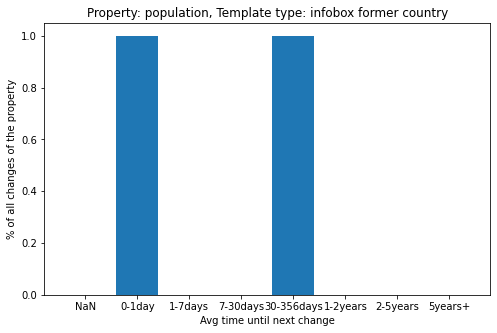

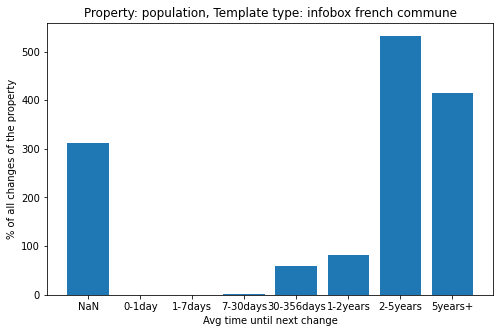

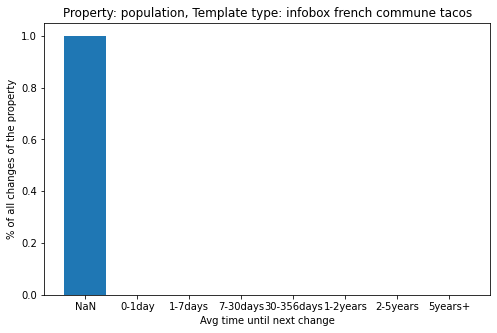

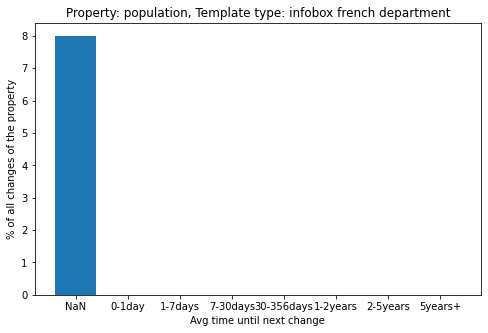

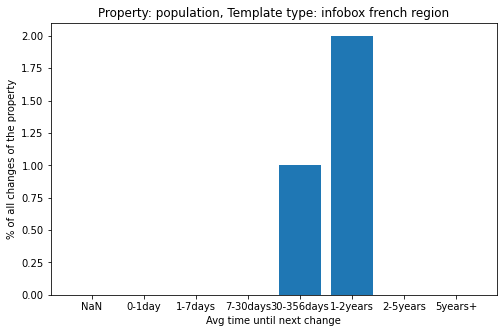

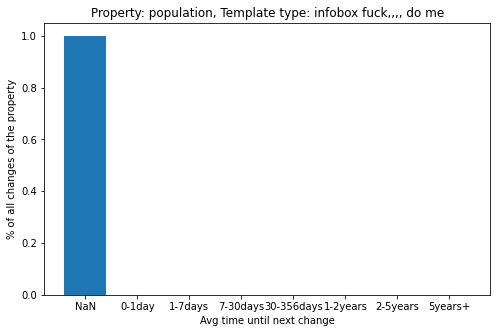

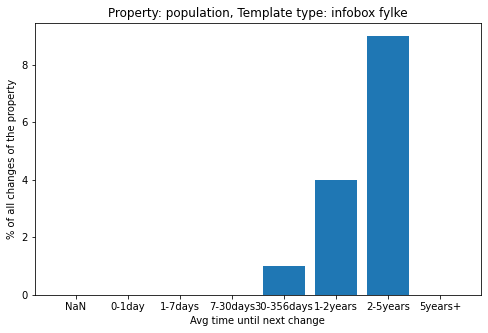

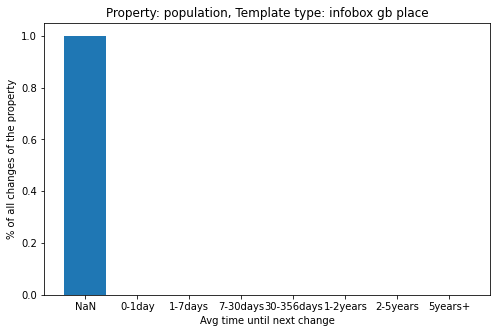

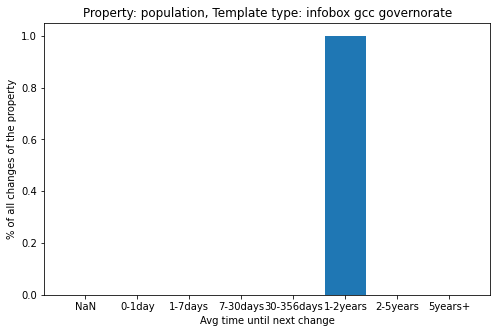

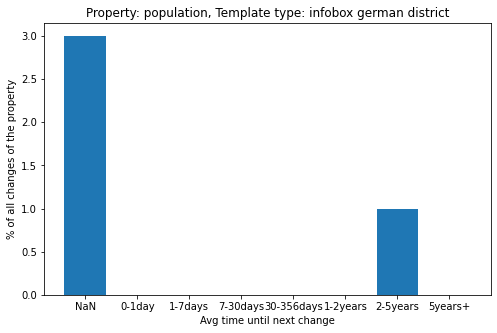

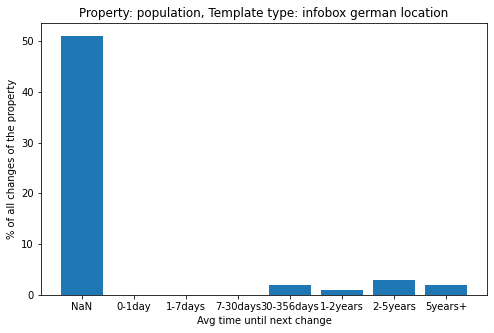

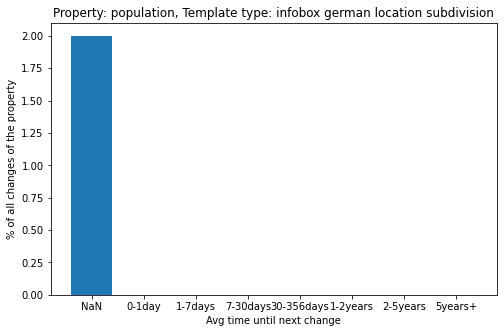

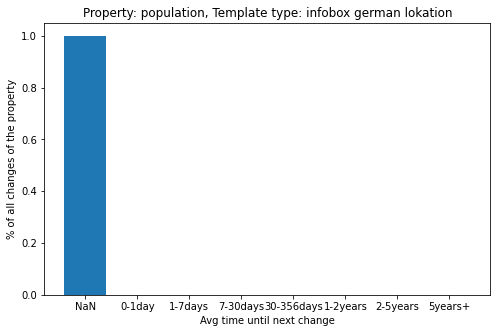

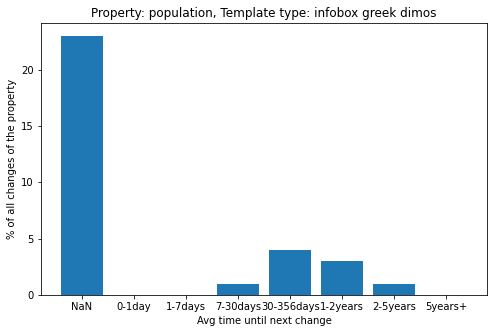

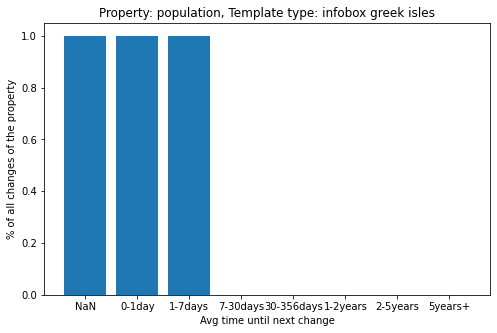

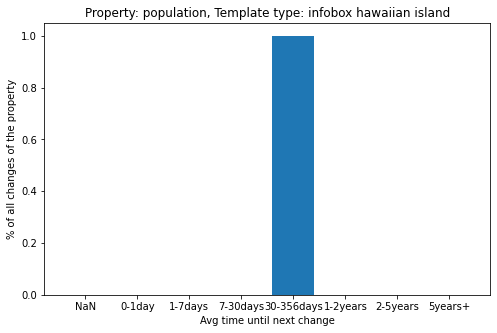

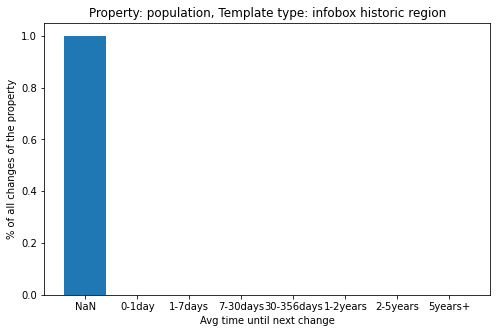

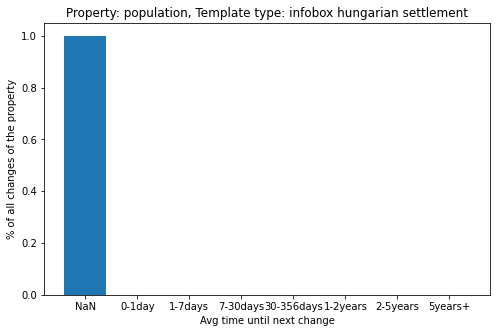

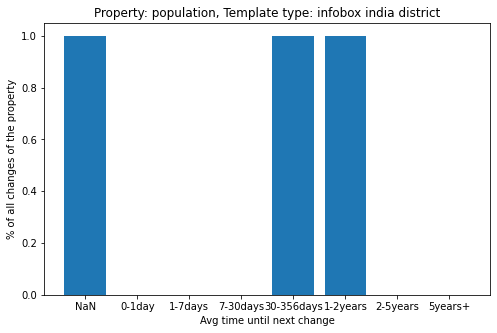

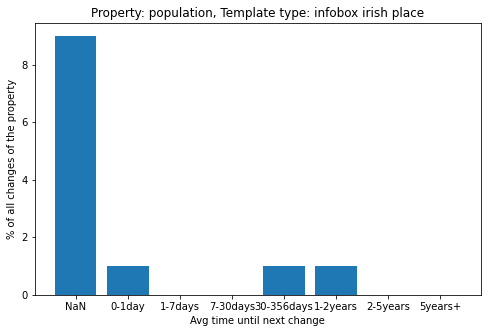

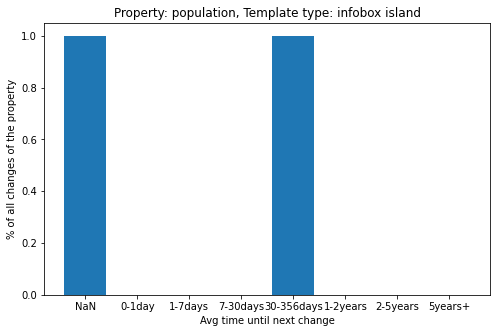

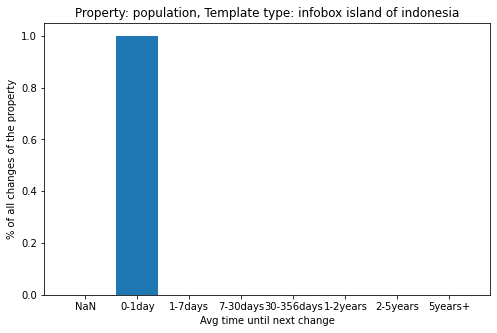

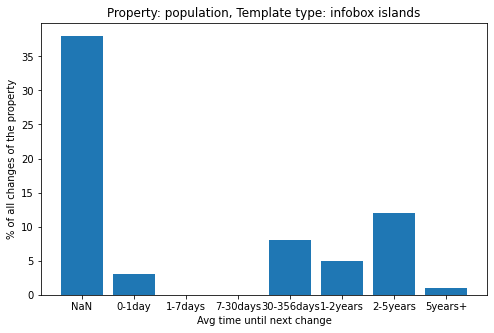

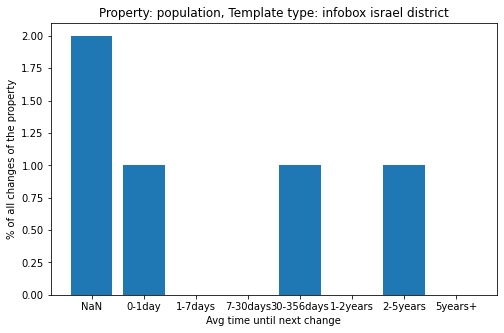

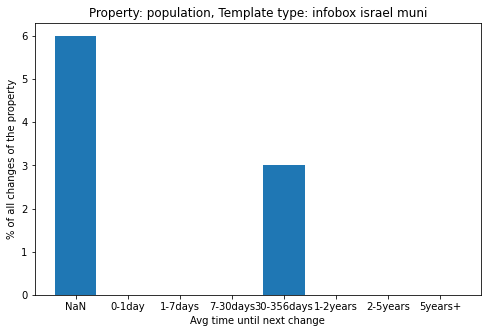

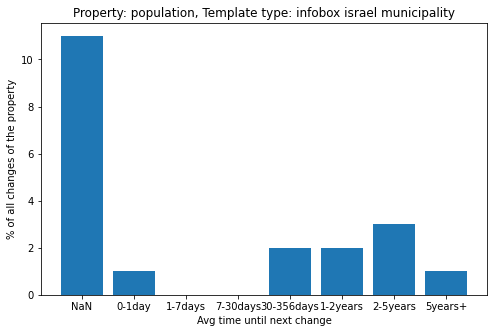

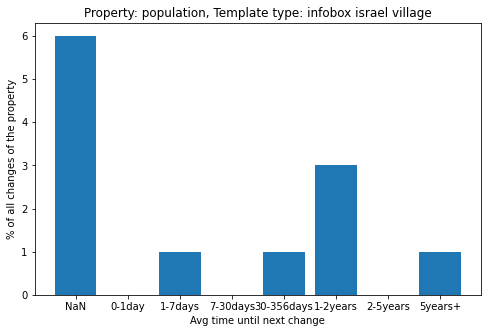

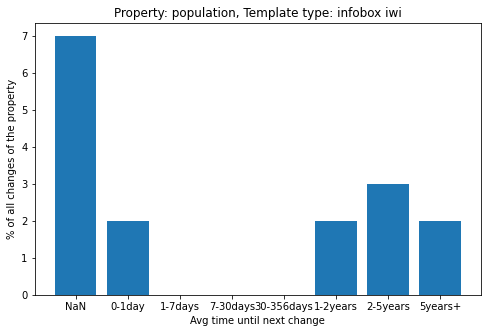

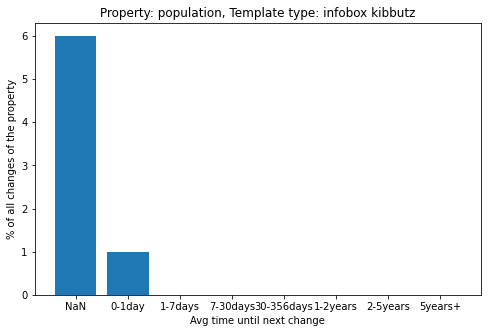

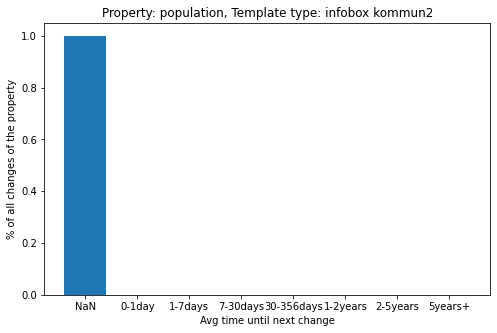

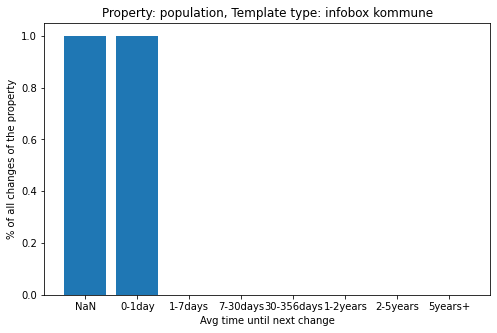

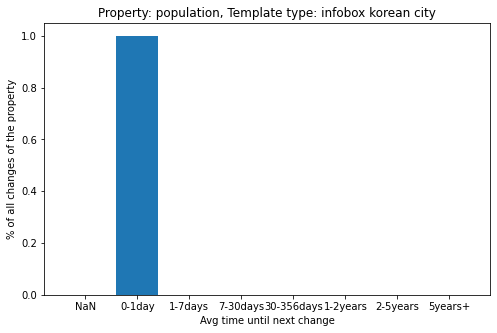

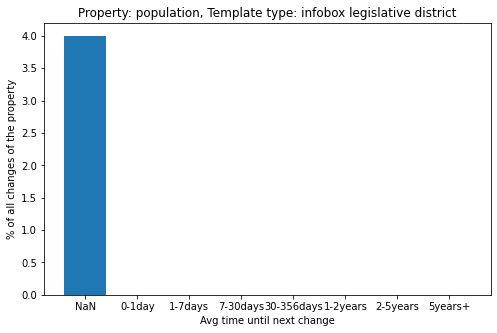

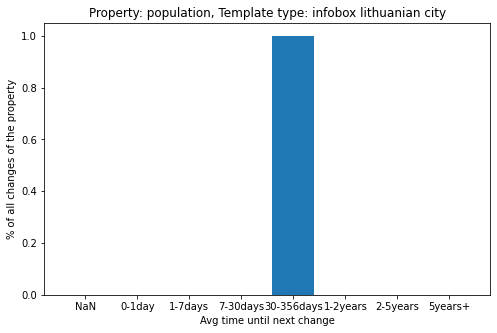

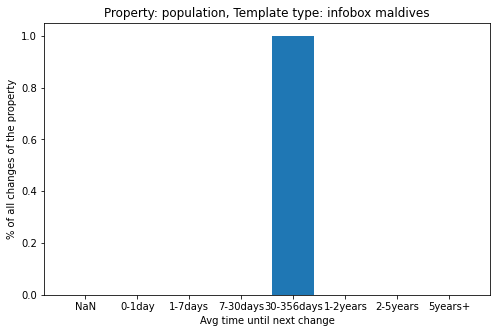

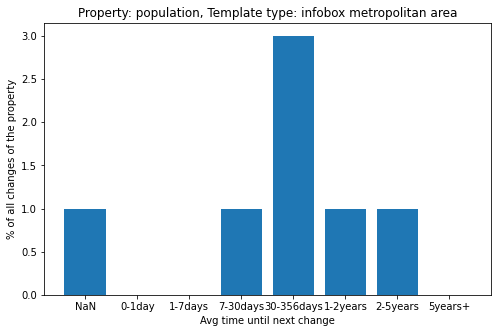

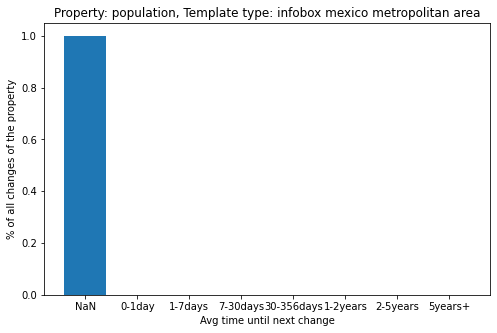

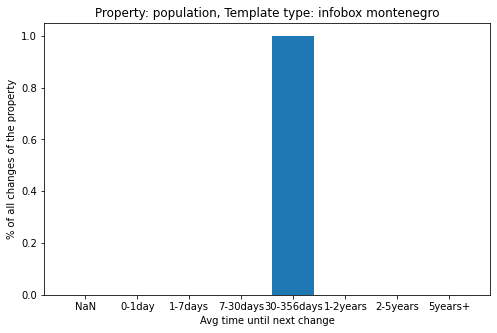

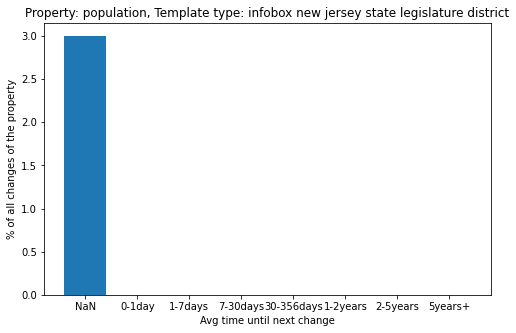

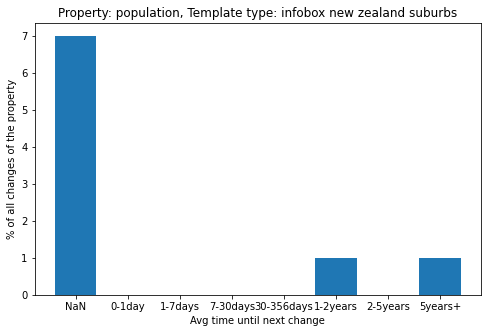

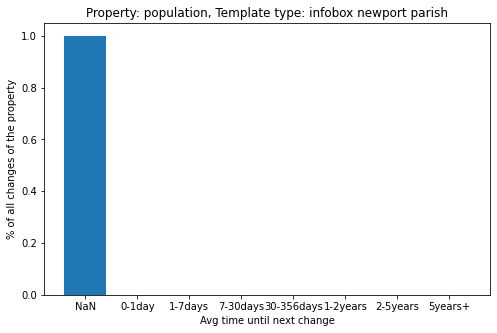

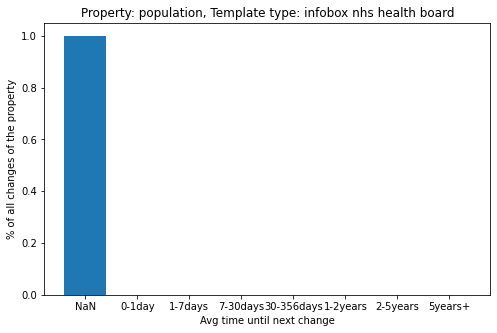

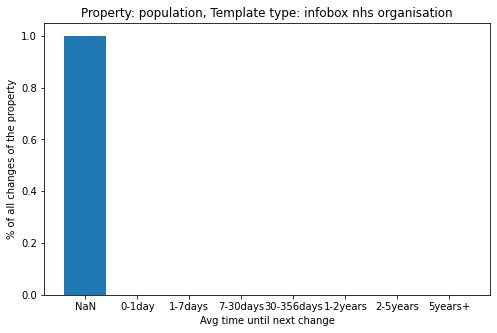

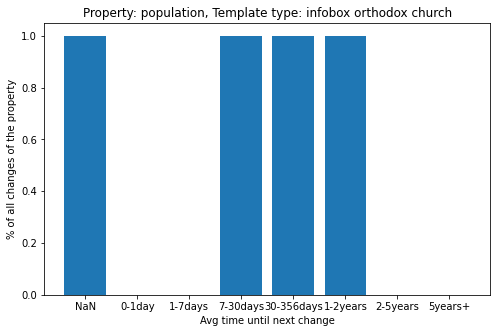

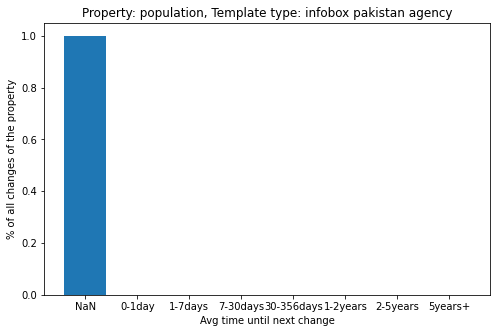

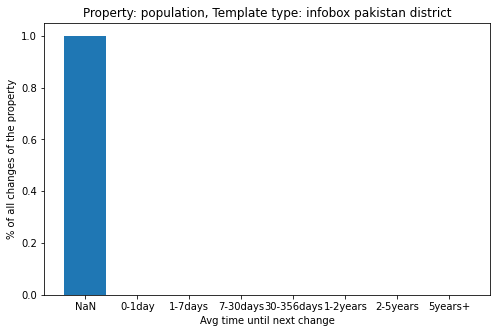

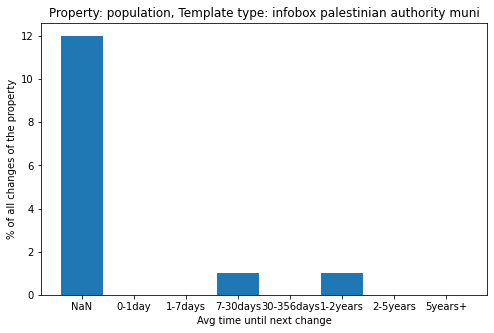

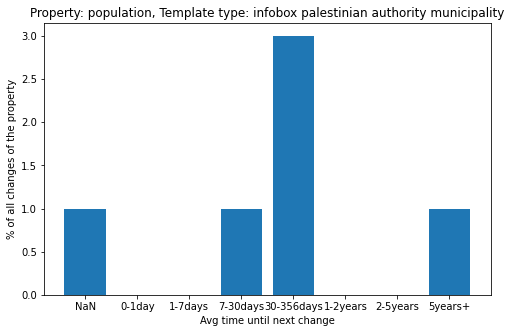

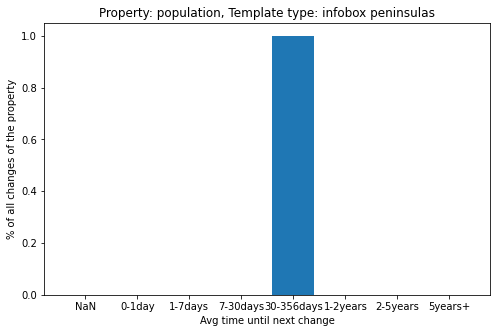

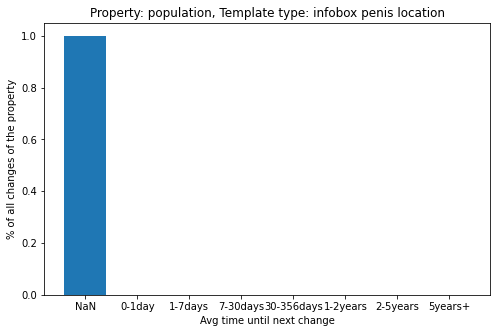

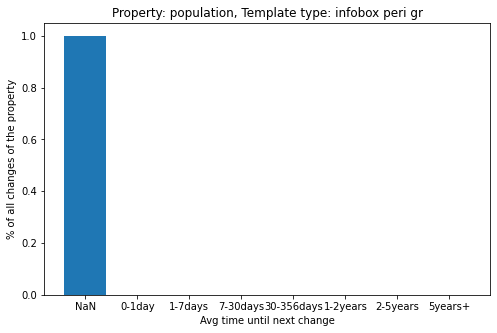

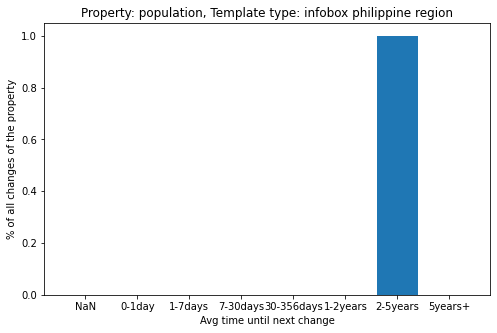

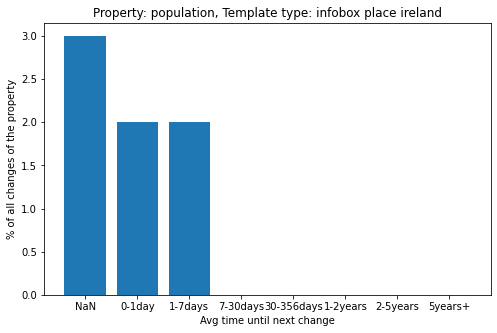

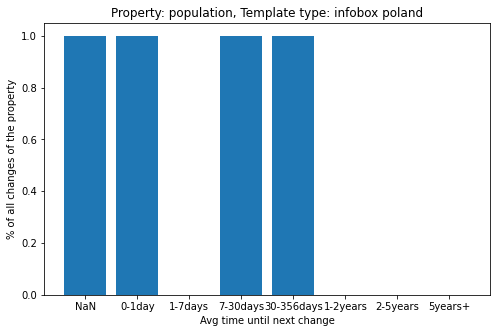

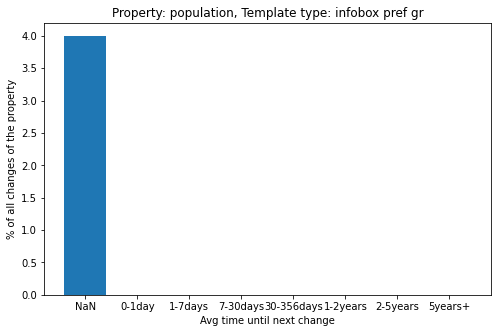

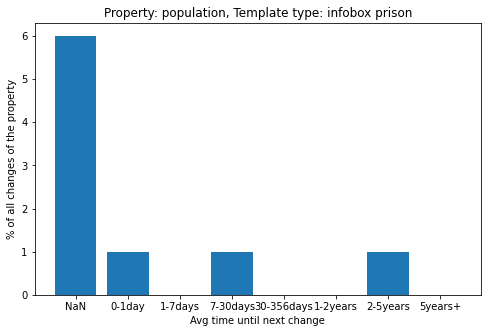

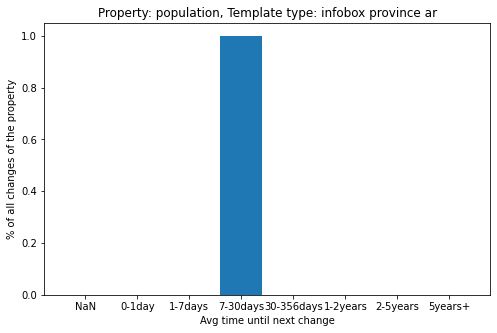

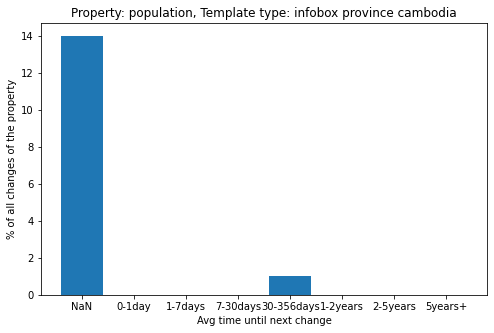

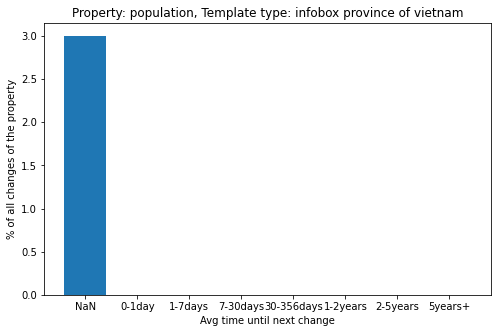

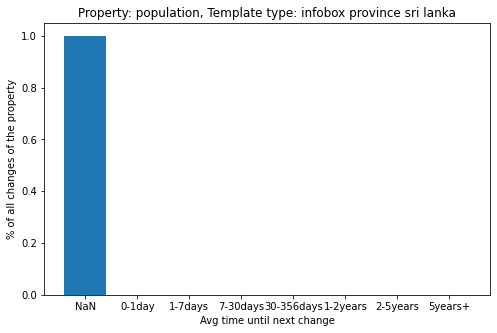

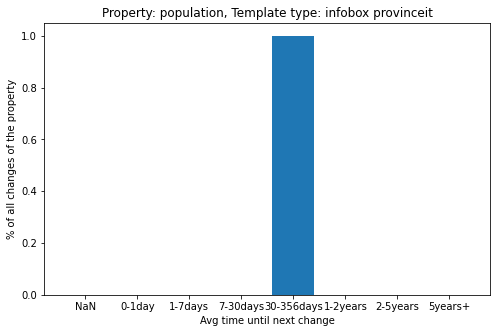

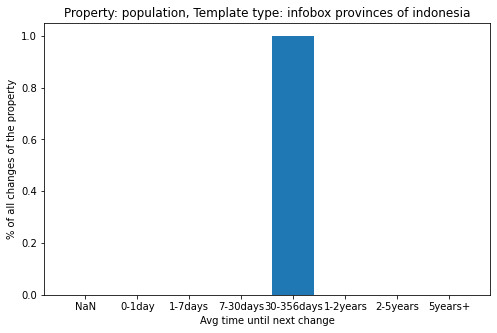

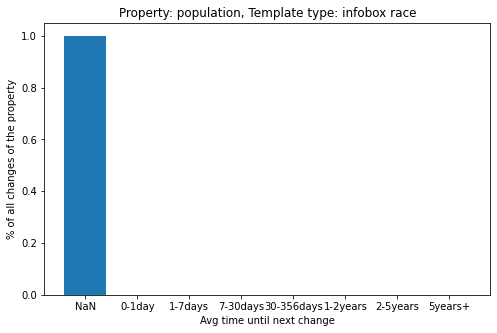

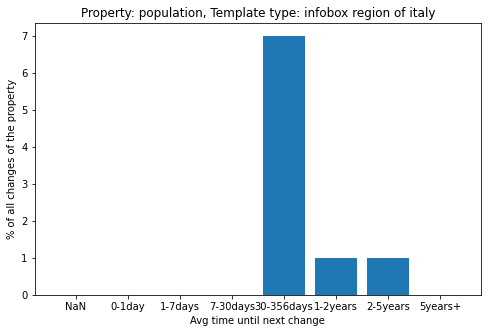

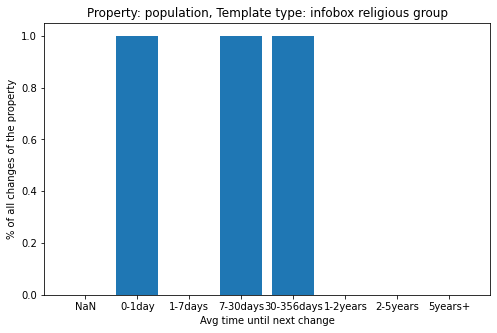

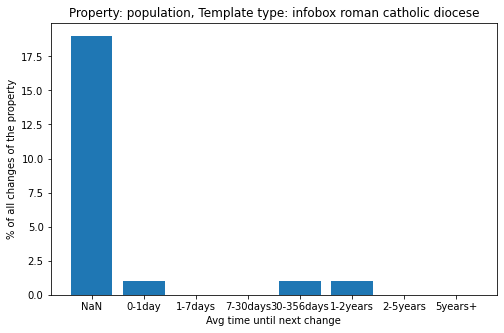

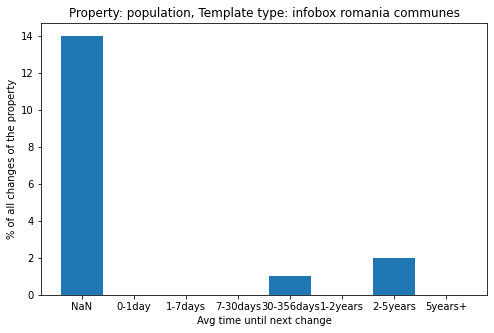

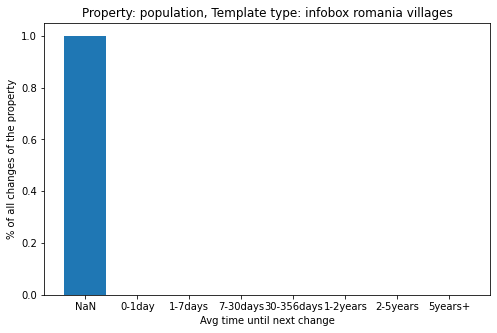

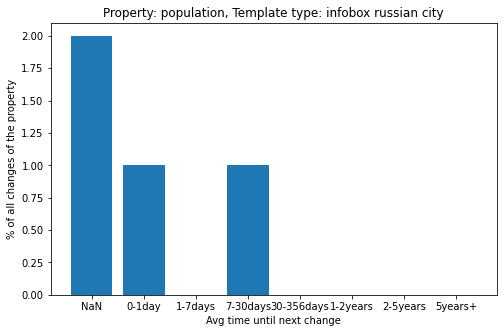

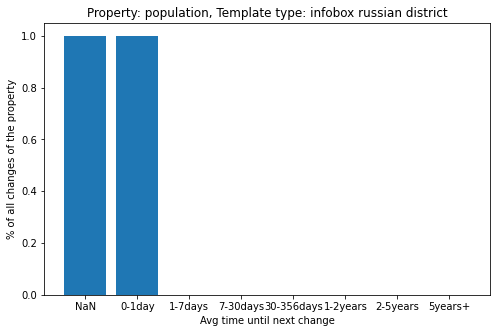

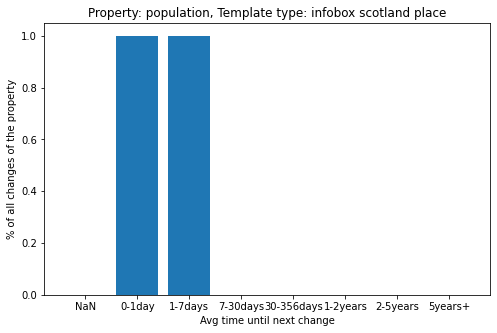

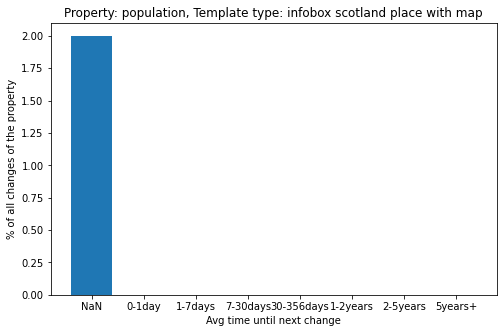

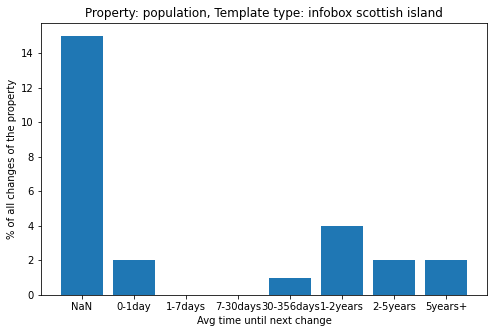

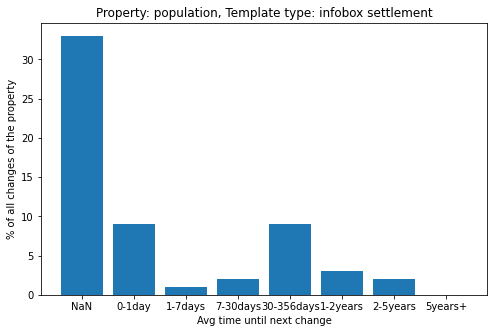

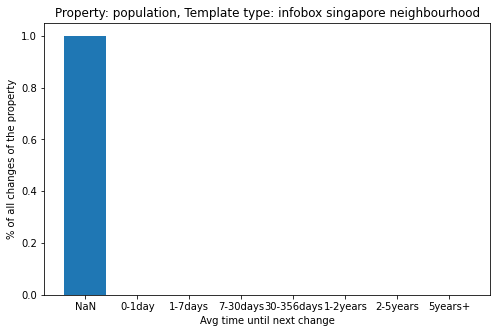

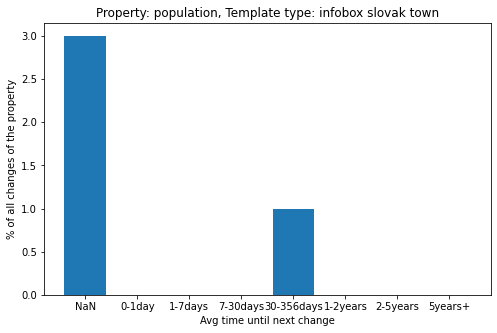

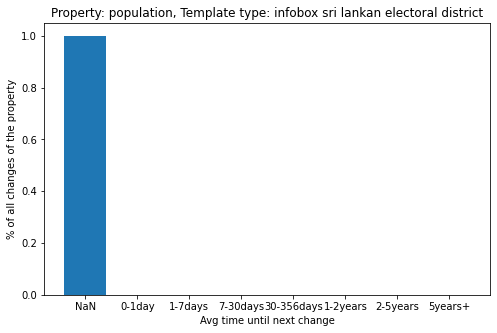

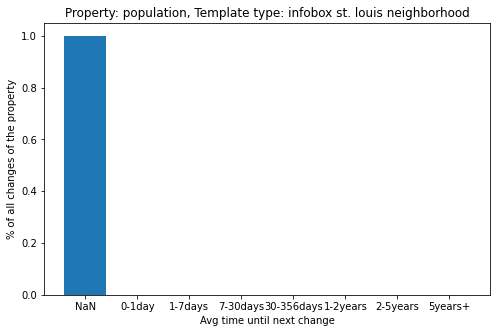

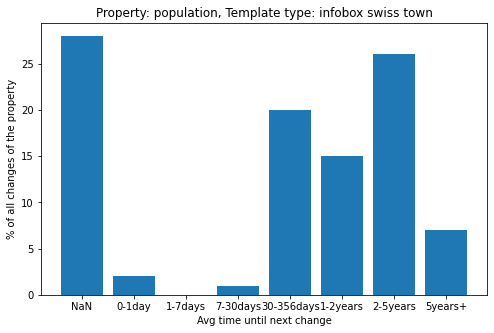

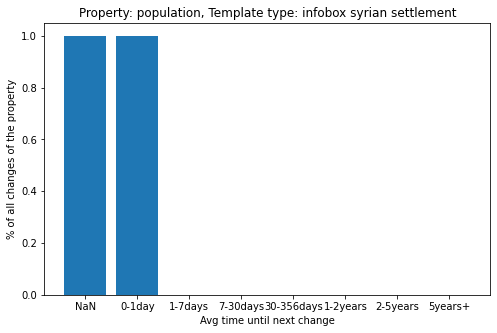

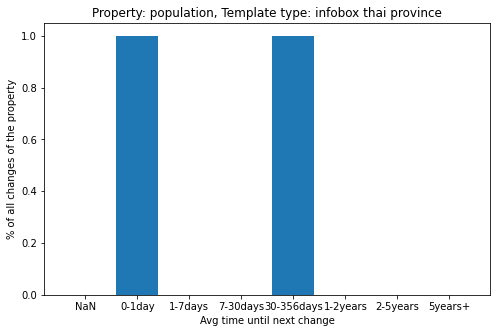

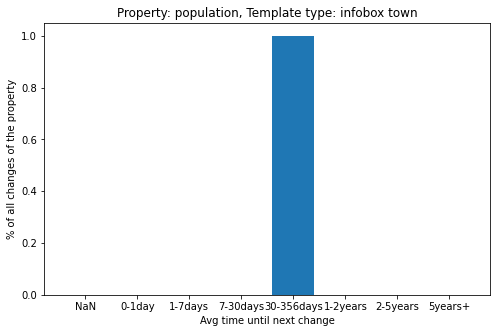

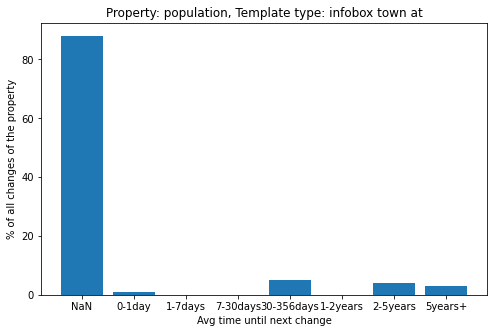

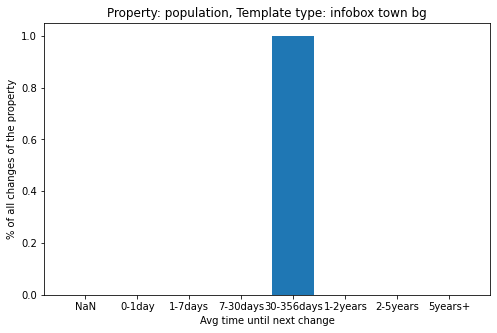

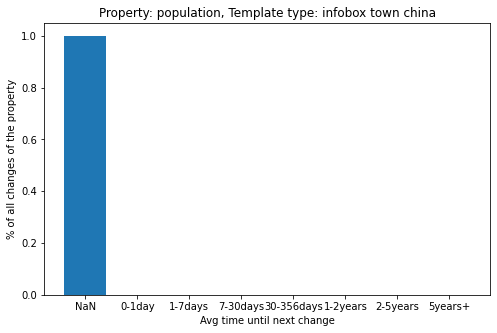

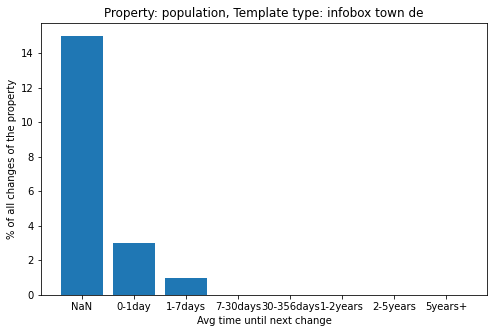

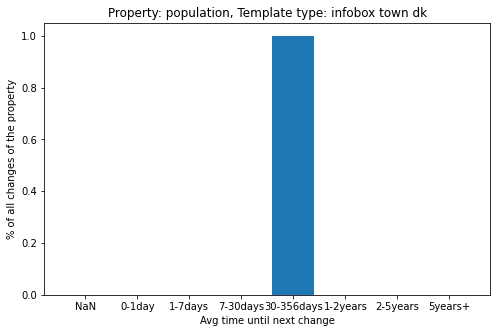

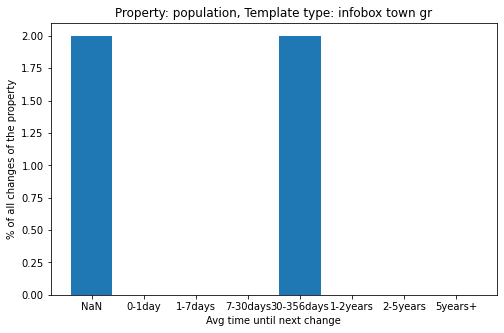

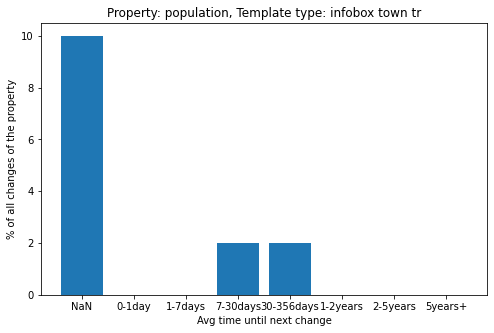

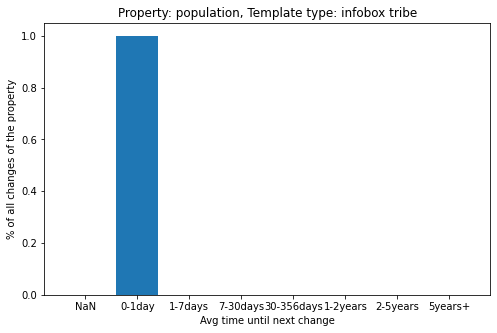

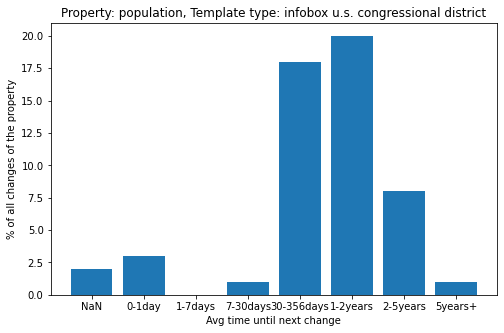

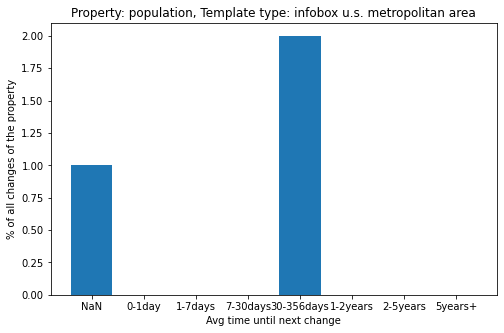

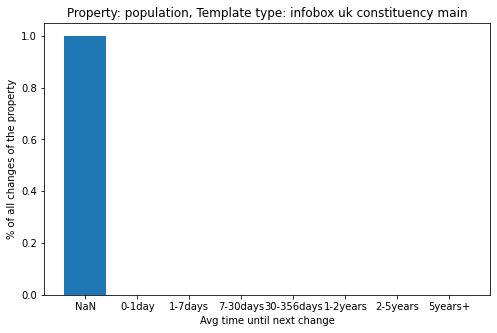

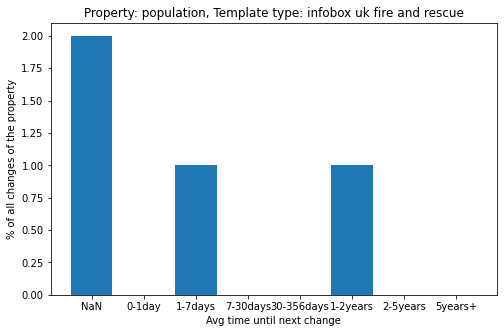

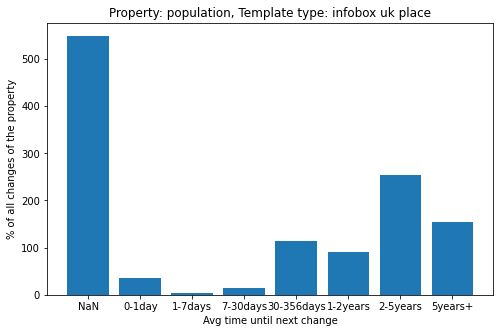

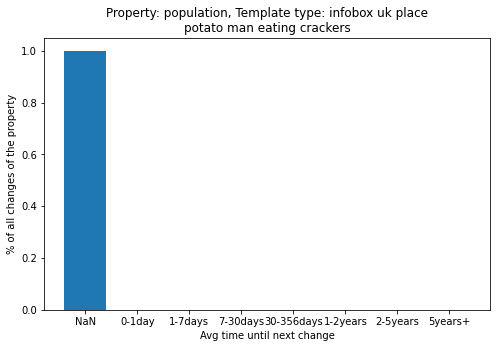

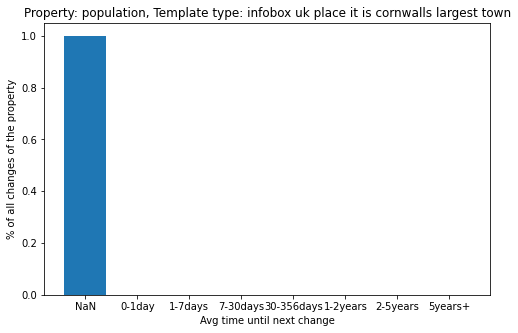

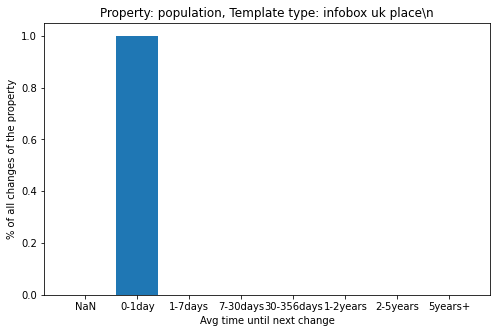

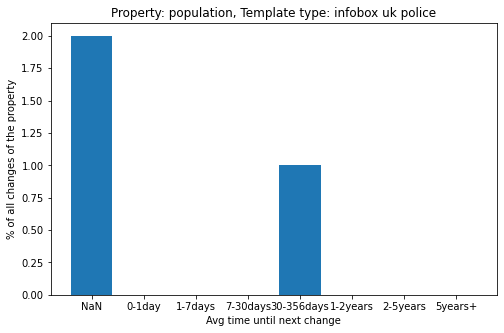

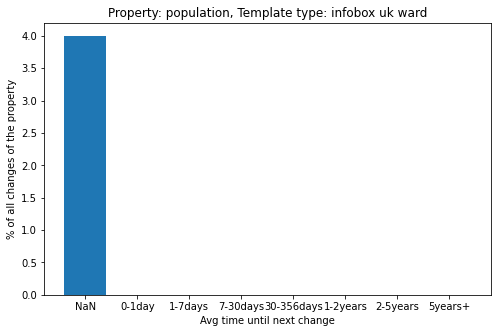

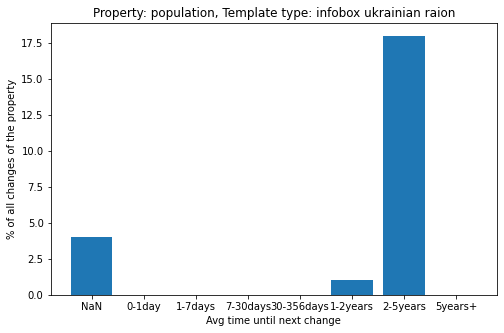

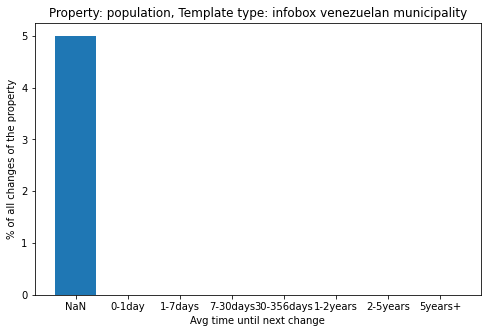

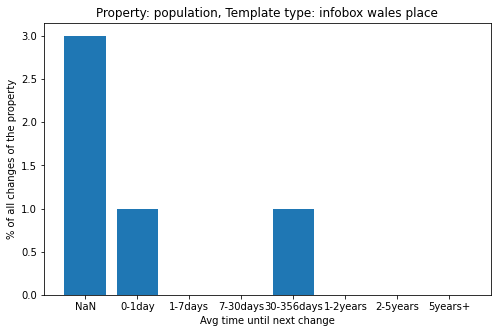

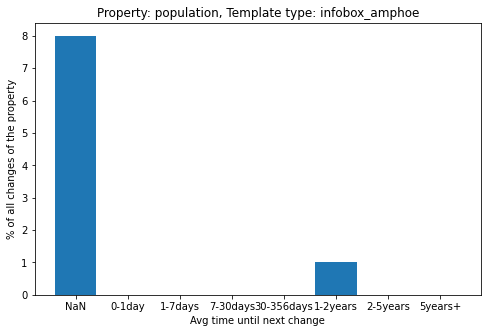

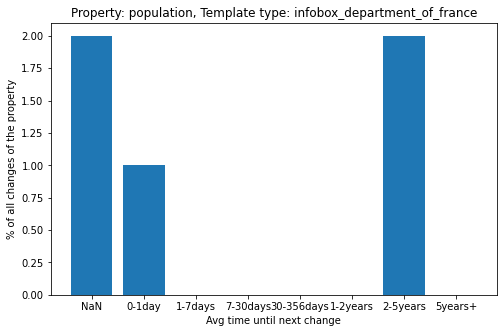

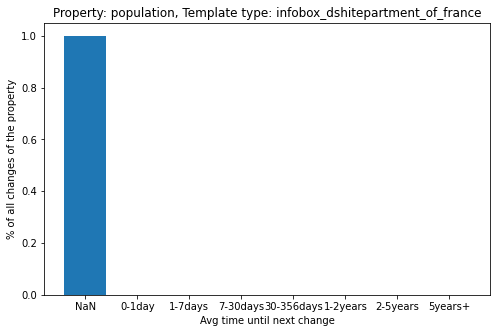

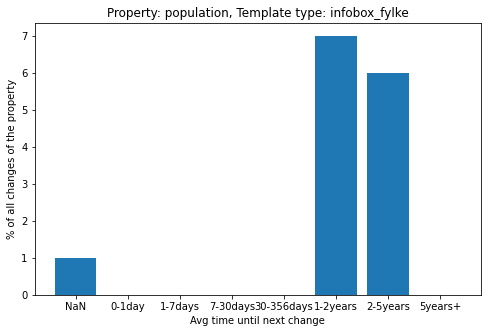

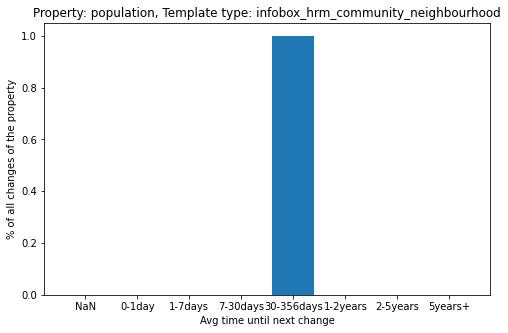

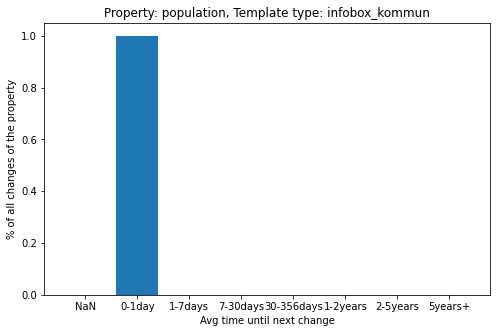

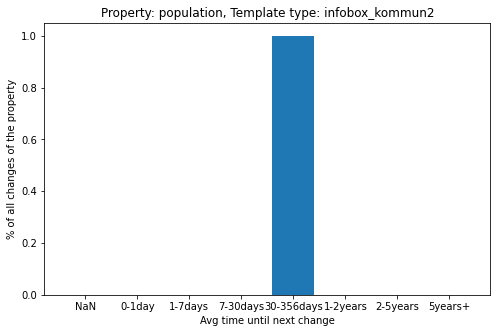

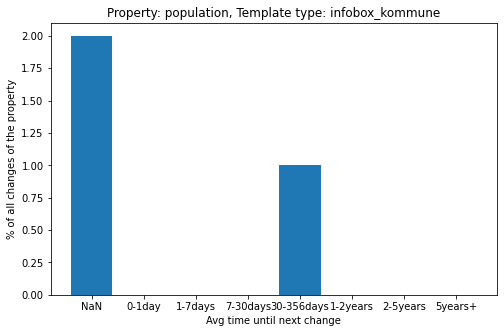

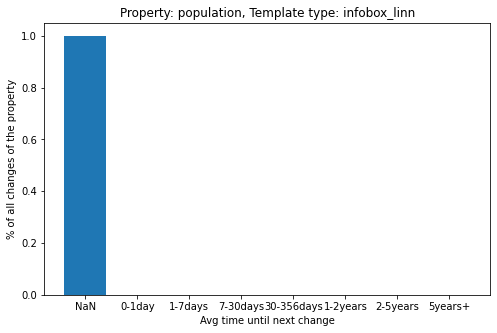

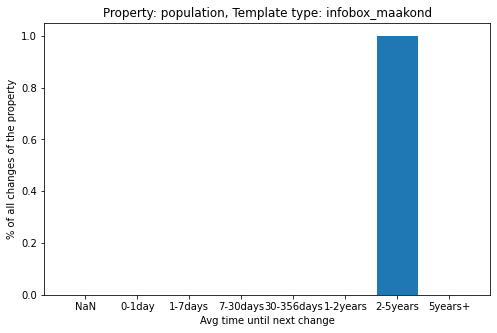

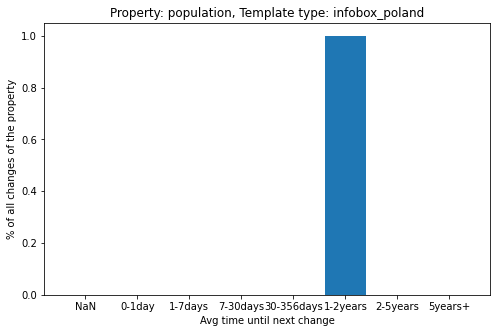

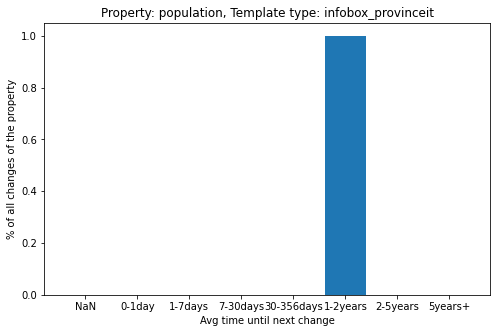

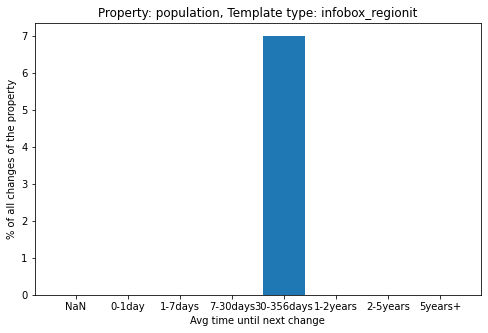

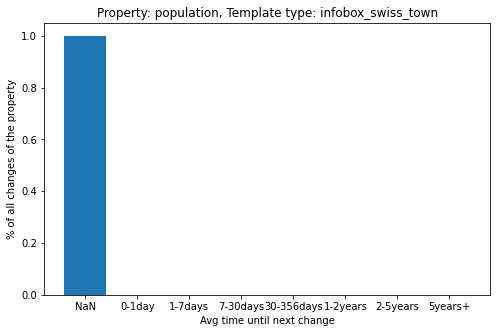

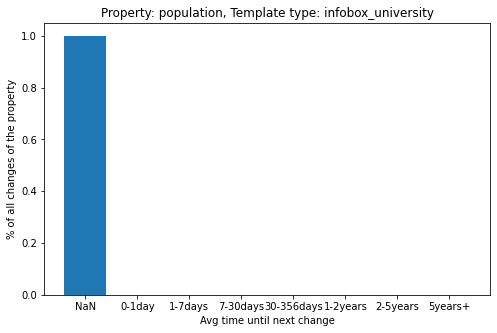

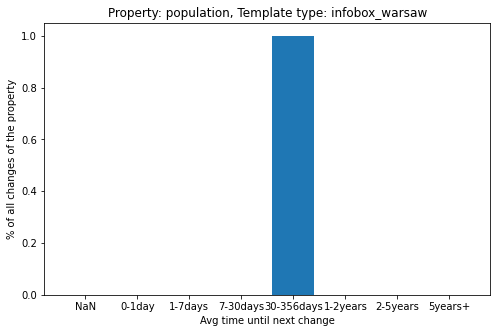

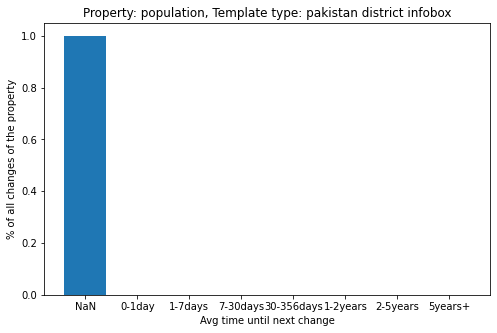

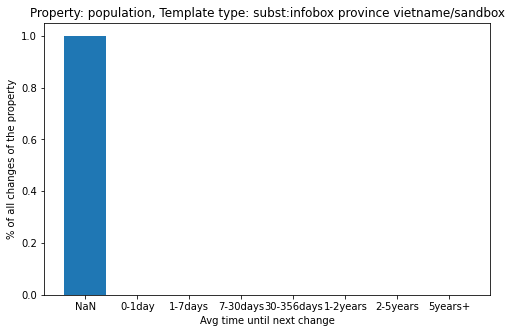

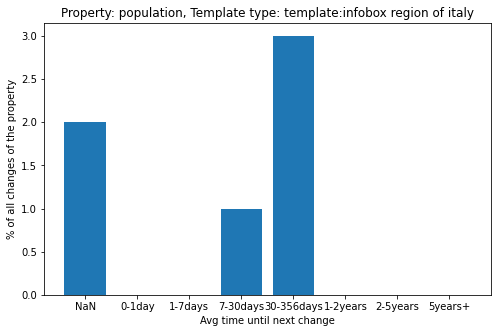

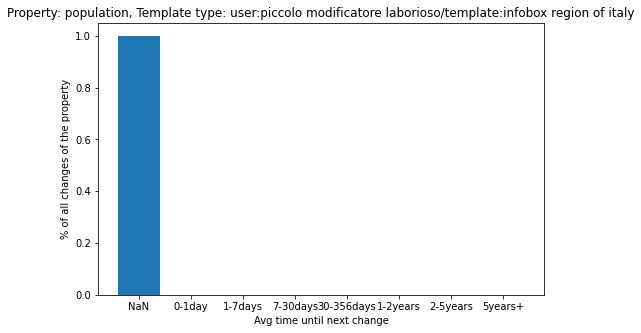

In [83]:
for temp in template_types:
    plt.figure(figsize=(8,5))
    plt.bar(labels,\
            binned_counts.filter(items = [temp], axis=0).values[0])
    plt.title('Property: population, Template type: {}'.format(temp))
    plt.ylabel('% of all changes of the property')
    plt.xlabel('Avg time until next change')
    plt.show()

In [9]:
import math

bins = [
    pd.Timedelta(minutes = -1),
    pd.Timedelta(minutes = 0),
    pd.Timedelta(days = 1),
    pd.Timedelta(days = 7),
    pd.Timedelta(days = 30),
    pd.Timedelta(days = 356),
    pd.Timedelta(days = 712),
    pd.Timedelta(days = 1750),
    pd.Timedelta(days=35600)
]

labels = ['NaN','0-1day', '1-7days', '7-30days', '30-356days', '1-2years', '2-5years', '5years+']

property_list = ['population', 'num_episodes', 'score', 'wins','losses', 'year']

def plot_time_to_changes(df, property_list):
    height = math.ceil(len(property_list) / 2)
    fig, axs = plt.subplots(height, 2, figsize=(16,16))
    
    for i,property_name in enumerate(property_list):
        g = data[data['name']==property_name].groupby(['key','name'])
        avg_time_diff = g.apply(lambda x: x['timestamp'].diff().mean())
        deltas = pd.cut(avg_time_diff, bins, labels = labels)
        binned_counts = deltas.value_counts(normalize=True, sort=False)
        
        axs[i//2, i%2].bar(binned_counts.index.astype(str), binned_counts.values)
        axs[i//2, i%2].set_title('Property: {}'.format(property_name))
        axs[i//2, i%2].set_ylabel('% of all changes of the property')
        axs[i//2, i%2].set_xlabel('Avg time until next change')
    #plt.savefig('test.png')
    plt.show()
    

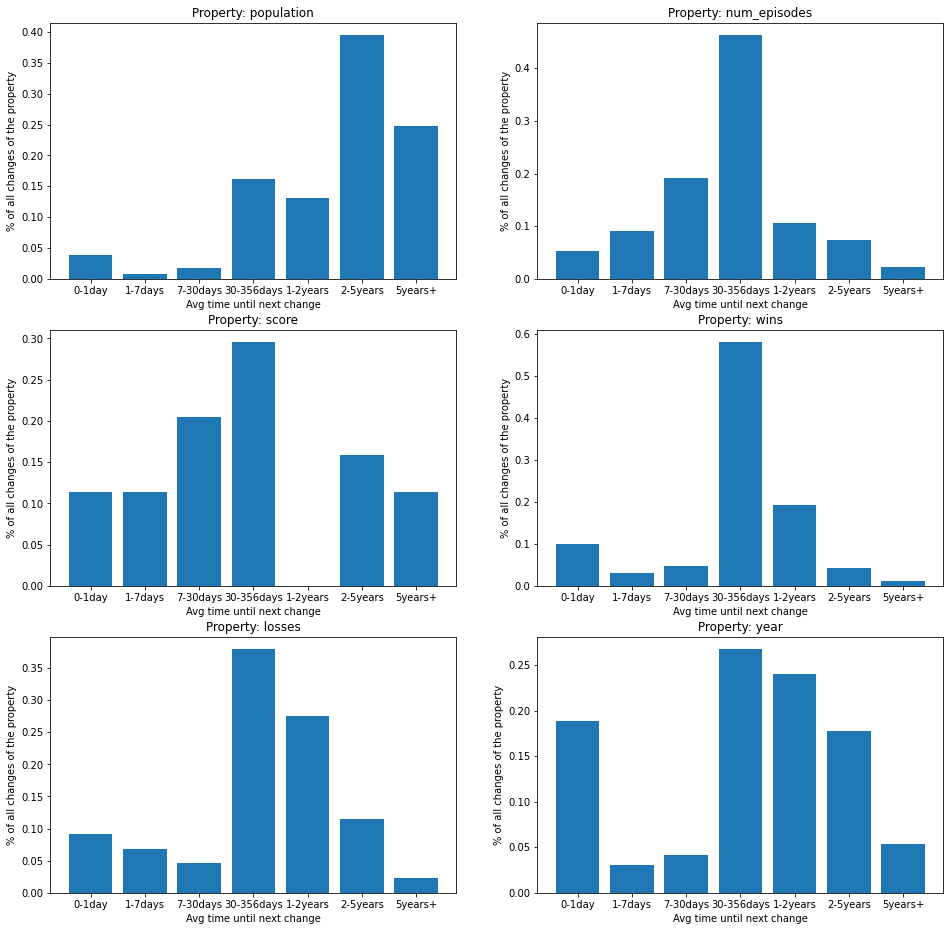

In [26]:
plot_time_to_changes(data,property_list)

## Label data as static or dynamic

In [20]:
tqdm.pandas()

In [18]:
data_only_creations = data[data['creation']==True]

In [22]:
g = data.groupby(['key','name','template'])
avg_time_diff = g.progress_apply(lambda x: x['timestamp'].sort_values().diff().mean()).reset_index()
avg_time_diff.rename(columns={0:'avgChangeFrequ'},inplace=True)
avg_time_diff = avg_time_diff[avg_time_diff['avgChangeFrequ'] > pd.Timedelta(days = 366)]

Include properties that were never changed

In [25]:
changes_and_creations = pd.concat([avg_time_diff, data_only_creations], axis=0)
changes_and_creations.drop_duplicates(['key','name','template'], inplace=True)

In [39]:
count_static_infoboxes = changes_and_creations['name'].value_counts()

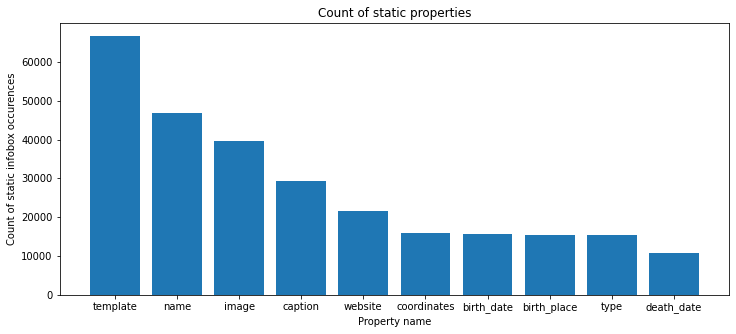

In [43]:
plt.figure(figsize=(12,5))
plt.bar(count_static_infoboxes[:10].index,\
        count_static_infoboxes[:10].values)
plt.title('Count of static properties')
plt.ylabel('Count of static infobox occurences')
plt.xlabel('Property name')
plt.show()